In [244]:
import argparse
import os
import random
import time
import math

# deep learning
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torchvision.utils as vutils

# machine learning
from sklearn.decomposition import PCA

# data
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# signal processing
from scipy import signal
from scipy.stats import entropy

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [245]:
import socket
myHostName = socket.gethostname()
print(myHostName)

Tarins-MacBook.local


In [246]:
device = torch.device("mps")
# device = torch.device("cpu")

# number of channels the signal has
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# number of classes in the conditional dcgan
num_classes = 3

# number of signals per iteration
batch_size = 32

# Number of training epochs
# num_epochs = int(32 * (6000/1684))
num_epochs = 32

# Learning rate for optimizers
lr_g = 0.00002
lr_d = 0.00002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# type of gan
gans_type = "dcgans"

### Dataloader

Getting parameters such as data mean and sd for standardisation

In [247]:
class GWDataset(Dataset):
    def __init__(self, signals_csv, parameters_csv):
        y = pd.read_csv(parameters_csv)
        self.data = pd.read_csv(signals_csv).astype('float32')
        # remove erroneous parameters
        keep_signals_idx = np.array(y[y['beta1_IC_b'] > 0].index)
        y = y.iloc[keep_signals_idx,:]
        # self.parameters['beta1_IC_b_bins'] = pd.qcut(self.parameters['beta1_IC_b'], q=10, labels=False)
        # self.parameters = self.parameters[['beta1_IC_b_bins']].astype('float32')

        ranges = [0, 0.06, 0.17, 1]
        labels = [0, 1, 2]
        num_classes = len(labels)
        y = y['beta1_IC_b']
        y = pd.cut(y, bins=ranges, labels=labels).astype('int')
        y = y.values
        y = np.eye(num_classes)[y]
        y = np.reshape(y, (y.shape[0], y.shape[1], 1)).astype('float32')

        self.parameters = y
        self.original_parameters = self.parameters
        self.augmented_parameters = np.empty(shape = (0, self.parameters.shape[1])).astype('float32')

        # drop corresponding signals which have erroneous parameter values
        self.data = self.data.iloc[:,keep_signals_idx]
        self.data = self.data.values
        self.original_data = self.data
        self.augmented_data = np.empty(shape = (256, 0)).astype('float32')

        ### signal augmentation section ###
        total_noise_mean = 0
        total_noise_std = 0
        
        temp_data = np.empty(shape = (256, 0)).astype('float32')

        for i in range(0, self.data.shape[1]):
            signal = self.data[:, i]
            signal = signal.reshape(1, -1)

            background_noise_segment = signal[:, 0:int(len(signal[0]) - 256)]
            signal = signal[:, int(len(signal[0]) - 256):len(signal[0])]

            temp_data = np.insert(temp_data, temp_data.shape[1], signal, axis=1)            

            background_noise_mean = background_noise_segment.mean()
            background_noise_std = background_noise_segment.std()

            total_noise_mean = total_noise_mean + background_noise_mean
            total_noise_std = total_noise_std + background_noise_std

        self.background_noise_mean = total_noise_mean / self.data.shape[1]
        self.background_noise_std = total_noise_std / self.data.shape[1]

        self.data = temp_data
        ### end signal augmentation section ###

    ### augmentation methods ###
    def shift_augmentation(self, signal):
        shift = np.random.normal(0, 25, 1)
        shifted_signal = np.roll(signal, int(shift))
        
        return shifted_signal

    def scale_augmentation(self, signal):
        scale_factor = np.random.normal(1, 0.2, 1)
        scale_factor = np.maximum(scale_factor, 0)
        scaled_signal = scale_factor * signal
        return scaled_signal

    def jittering_augmentation(self, signal):
        # todo: add noise only after time of core bounce
        # noise_start_time = 203
        noise = np.random.normal(0, 1, signal.shape[1])
        jittered_signal = signal + noise
    
        return jittered_signal

    def mixture_augmentation(self, signal_1, signal_2):
        distance_multiplier = np.random.normal(0.5, 0.2, 1)
        # clip signal to range [0,1] as this is the multiplier by the normalised difference in signals
        distance_multiplier = np.clip(distance_multiplier, 0, 1)
        mixture_signal = signal_1 + distance_multiplier * (signal_2 - signal_1)

        return mixture_signal

    def window_warping_augmentation(self, signal):
        # take window size of 10% of the signal with a warping factor of 2 or 0.5 (from literature)
        warping_factor =  random.choice([0.5, 2])
        # warping_factor = 0.5

        window_size = math.floor(signal.shape[1] / 10)
        scaled_window_size = warping_factor * window_size

        # don't warp anything a little bit before the core-bounce - preserves core-bounce position
        window_min_idx = 203

        # find random reference position for start of window warping
        window_start_idx = np.random.randint(window_min_idx, signal.shape[1] - scaled_window_size*2)
        window_end_idx = window_start_idx + window_size

        # select between warping by factor 1/2 or 2
        if (warping_factor == 2):
            # extract values before, at and after the window
            # clip end of signal to make up for extra size due to window warping
            signal_before_window = signal[0][:window_start_idx]
            signal_window = signal[0][window_start_idx:window_end_idx]
            signal_after_window = signal[0][window_end_idx:int(signal.shape[1]-(window_size))]
            # print(signal_after_window)

            # time points
            t = np.arange(len(signal_window))
            warped_t = np.arange(0, len(signal_window), 0.5)

            # interpolation for window warping
            signal_window_warped = np.interp(warped_t, t, signal_window)

            # combine signals
            warped_signal = np.concatenate((signal_before_window, signal_window_warped, signal_after_window), axis=0)
        elif (warping_factor == 0.5):
            # extract values before, at and after the window
            # clip end of signal to make up for extra size due to window warping
            signal_before_window = signal[0][:window_start_idx]
            signal_window = signal[0][window_start_idx:window_end_idx]
            signal_after_window = signal[0][window_end_idx:]
            # add values to end of signal to make up for downsampled window
            signal_after_window = np.pad(signal_after_window, (0, int(window_size - scaled_window_size)), mode='edge')

            signal_window_warped = signal_window[::int(1/warping_factor)]

            warped_signal = np.concatenate((signal_before_window, signal_window_warped, signal_after_window), axis=0)
        else:
            warped_signal = signal

        return warped_signal

    ### critical functions ###
    def calc_stats(self):
        self.mean = self.data.mean()
        print('Signal Dataset mean: ',  self.mean)
        self.std = np.std(self.data, axis=None)
        print('Signal Dataset std: ',  self.std)
        self.scaling_factor = 5
        print('Signal Dataset scaling factor (to match noise in generator): ',  self.scaling_factor)

    def get_common(self):
        self.common_ylim_signal = (self.data[:,:].min(), self.data[:,:].max())
        return self.common_ylim_signal
    
    def standardize(self, signal):
        standardized_signal = (signal - self.mean) / self.std
        standardized_signal = standardized_signal / self.scaling_factor
        return standardized_signal


    def augmentation(self, desired_augmented_data_count):
        while self.data.shape[1] < desired_augmented_data_count:
            idx_1 = np.random.randint(0, self.data.shape[1])
            signal_1 = self.data[:, idx_1]
            signal_1 = signal_1.reshape(1, -1)

            # second signal used only used for mixture signals data augmentation
            idx_2 = np.random.choice([x for x in range(0, self.data.shape[1]) if x != idx_1])
            signal_2 = self.data[:, idx_2]
            signal_2 = signal_2.reshape(1, -1)

            # call selected augmentation function here
            # augmented_signal = self.window_warping_augmentation(signal_1)
            augmented_signal = self.mixture_augmentation(signal_1, signal_2)

            self.augmented_data = np.insert(self.augmented_data, self.augmented_data.shape[1], augmented_signal, axis=1)
            self.data = np.insert(self.data, self.data.shape[1], augmented_signal, axis=1)

            # just sample parameters for now, haven't figured out a way to augment them to make consistent with signal augmentation
            augmented_parameter = self.parameters[idx_1, :]

            self.augmented_parameters = np.insert(self.augmented_parameters, self.augmented_parameters.shape[0], augmented_parameter, axis=0)
            self.parameters = np.insert(self.parameters, self.parameters.shape[0], augmented_parameter, axis=0)

        print("Signal Dataset Size after Data Augmentation: ", self.data.shape)
        print("Parameter Dataset Size after Data Augmentation : ", self.parameters.shape)

    ### overloads ###
    def __len__(self):
        return self.data.shape[1]

    def __getitem__(self, idx):
        signal = self.data[:, idx]
        signal = signal.reshape(1, -1)

        parameter = self.parameters[idx,:]

        signal_standardized = self.standardize(signal)

        return signal_standardized, parameter

In [248]:
def plot_waveforms_standardised(real_signals_batch, real_parameter_batch):
    fig, axes = plt.subplots(4, 4, figsize=(15, 12))
    axes = axes.flatten()

    # Plot each signal on a separate subplot
    for i, ax in enumerate(axes):
        x = np.arange(real_signals_batch.size(dim=2))
        y = real_signals_batch[i, :, :].flatten()
        ax.plot(x, y)

        ax.axvline(x=50, color='black', linestyle='--', alpha=0.5)
        ax.set_title(f'Signal {i + 1}')
        ax.grid(True)
        ax.set_ylim(common_ylim)


        # Get parameter values as a NumPy array
        parameters = real_parameter_batch[i, :].numpy()[0]

        # Combine parameter names and values, format as a string
        # parameters_with_names = f'{parameter_names[0]}: {parameters[0]:.6f}\n{parameter_names[1]}: {parameters[1]:.2f}, {parameter_names[2]}: {parameters[2]:.2f}'
        # ax.set_xlabel(f'Parameters:\n{parameters_with_names}')

    for i in range(512, 8 * 4):
        fig.delaxes(axes[i])

    plt.tight_layout()

    plt.show()

def plot_waveforms(real_signals_batch, real_parameter_batch):
    fig, axes = plt.subplots(4, 4, figsize=(15, 12))
    axes = axes.flatten()

    # Plot each signal on a separate subplot
    for i, ax in enumerate(axes):
        x = np.arange(real_signals_batch.size(dim=2))
        y = real_signals_batch[i, :, :].flatten()
        y = y * dataset.scaling_factor
        y = y * dataset.std + dataset.mean
        ax.plot(x, y)

        ax.axvline(x=50, color='black', linestyle='--', alpha=0.5)
        ax.set_title(f'Signal {i + 1}')
        ax.grid(True)
        ax.set_ylim(common_ylim_signal)

        # Get parameter values as a NumPy array
        parameters = real_parameter_batch[i, :].numpy()[0]

        # Combine parameter names and values, format as a string
        # parameters_with_names = f'{parameter_names[0]}: {parameters[0]:.6f}\n{parameter_names[1]}: {parameters[1]:.2f}, {parameter_names[2]}: {parameters[2]:.2f}'
        # ax.set_xlabel(f'Parameters:\n{parameters_with_names}')

    for i in range(512, 8 * 4):
        fig.delaxes(axes[i])

    plt.tight_layout()

    plt.show()

Signal Dataset Size after Data Augmentation:  (256, 6000)
Parameter Dataset Size after Data Augmentation :  (6000, 3, 1)
Signal Dataset mean:  -0.5094816
Signal Dataset std:  33.823277
Signal Dataset scaling factor (to match noise in generator):  5
torch.Size([32, 3, 1])
Signal Batch Size:  torch.Size([32, 1, 256])


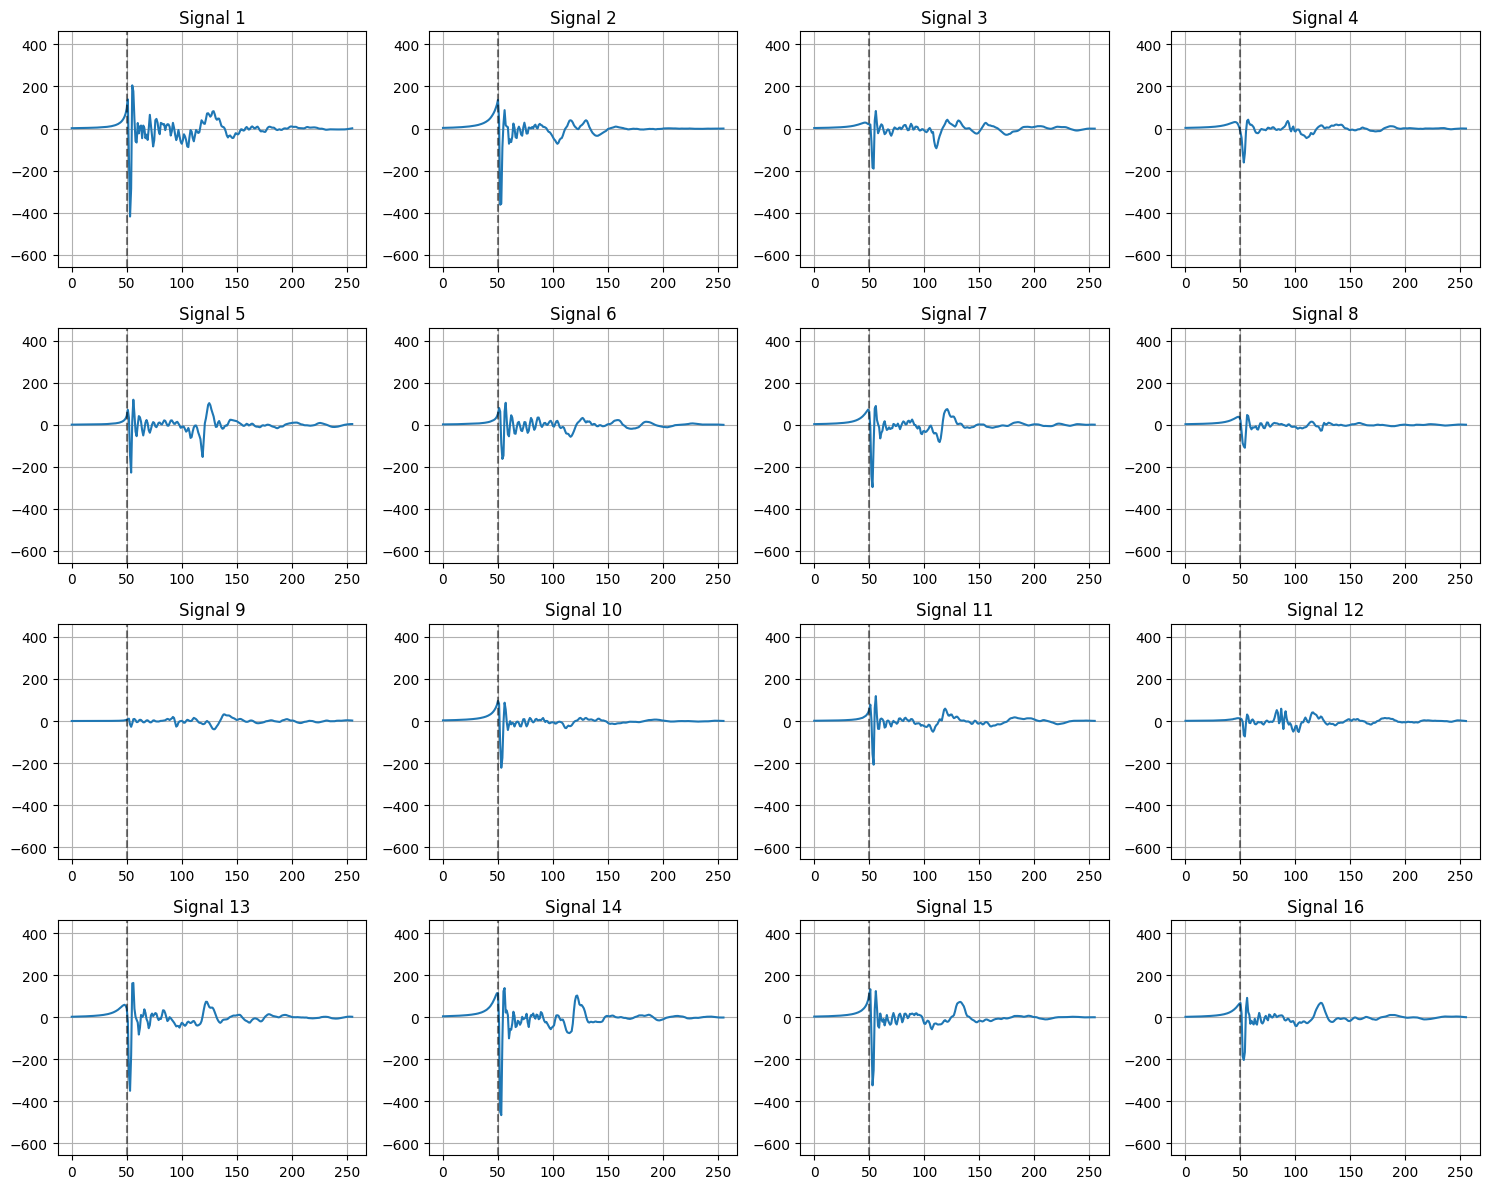

In [249]:
dataset = GWDataset("../data/gw-raw-data/richers_1764.csv", "../data/gw-raw-data/richers_1764_parameters.csv")

common_ylim_signal = dataset.get_common()
dataset.augmentation(6000)
dataset.calc_stats()
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

real_signals_batch, real_parameter_batch  = next(iter(dataloader))

print(real_parameter_batch.shape)

print("Signal Batch Size: ", real_signals_batch.shape)

common_ylim = (real_signals_batch[:,:,:].min(), real_signals_batch[:,:,:].max())
parameter_names = ['beta1_IC_b', 'A(km)', 'omega_0(rad|s)']

plot_waveforms(real_signals_batch, real_parameter_batch)
# plot_waveforms_standardised(real_signals_batch, real_parameter_batch)

In [250]:
dataset.__len__()

6000

### Weight Initialisation (Random Noise)

In [251]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator

In [252]:
if (gans_type == 'fccdcgans'):
    class Generator(nn.Module):
        def __init__(self):
            super().__init__()
            self.z_reshape = nn.Sequential(
                nn.Linear(nz, 64),
                nn.LeakyReLU(True)
            )
        
            self.y_reshape = nn.Sequential(
                nn.Linear(num_classes, 10),
                nn.LeakyReLU(True),
            )

            self.main = nn.Sequential(
                nn.ConvTranspose1d(110, ngf * 32, kernel_size=4, stride=1, padding=0, bias=False),
                nn.BatchNorm1d(ngf * 32),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 32, ngf * 16, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 16),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 16, ngf * 8, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 8),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 4),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 2),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
            )

        def forward(self, z, y):
            print(z.shape)
            print(y.shape)
            z = torch.reshape(z, (z.shape[0], z.shape[2], z.shape[1]))
            print(z.shape)
            # z = self.z_reshape(z)
            print(z.shape)
            y = torch.reshape(y, (y.shape[0], y.shape[2], y.shape[1]))
            y = self.y_reshape(y)
            print(y.shape)
            z = torch.cat([z, y], 2)
            print(z.shape)
            z = torch.reshape(z, (z.shape[0], z.shape[2], z.shape[1]))
            z = self.main(z)
            print(z.shape)
            return z

if (gans_type == 'cdcgans'):
    class Generator(nn.Module):
        def __init__(self):
            super().__init__()
            self.z_reshape = nn.Sequential(
                nn.ConvTranspose1d(nz, ngf * 16, kernel_size=4, stride=1, padding=0, bias=False),
                nn.LeakyReLU(True)
            )
        
            self.y_reshape = nn.Sequential(
                nn.ConvTranspose1d(num_classes, ngf * 16, kernel_size=4, stride=1, padding=0, bias=False),
                nn.LeakyReLU(True),
            )

            self.main = nn.Sequential(
                # nn.ConvTranspose1d(ngf * 32, ngf * 32, kernel_size=4, stride=2, padding=1, bias=False),
                # nn.BatchNorm1d(ngf * 32),
                # nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 32, ngf * 16, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 16),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 16, ngf * 8, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 8),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 4),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 2),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
            )

        def forward(self, z, y):
            # print(z.shape)
            # print(y.shape)
            z = self.z_reshape(z)
            # print(z.shape)
            y = self.y_reshape(y)
            # print(y.shape)
            z = torch.cat([z, y], 1)
            print(z.shape)
            z = self.main(z)
            # print(z.shape)
            return z

if gans_type == 'dcgans':
    class Generator(nn.Module):
        def __init__(self):
            super().__init__()
            self.main = nn.Sequential(
                nn.ConvTranspose1d(nz, ngf * 32, kernel_size=4, stride=1, padding=0, bias=False),
                nn.BatchNorm1d(ngf * 32),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 32, ngf * 16, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 16),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 16, ngf * 8, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 8),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 4),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 2),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
            )

        def forward(self, z):
            z = self.main(z)
            return z
        
if gans_type == 'gans':
    class Generator(nn.Module):
        def __init__(self):
            super(Generator, self).__init__()
            self.main = nn.Sequential(
                nn.Linear(nz, ngf),
                nn.BatchNorm1d(ngf),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Linear(ngf, ngf * 2),
                nn.BatchNorm1d(ngf * 2),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Linear(ngf * 2, ngf * 4),
                nn.BatchNorm1d(ngf * 4),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Linear(ngf * 4, ngf * 8),
                nn.BatchNorm1d(ngf * 8),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Linear(ngf * 8, 512),
            )

        def forward(self, z):
            z = z.view(z.size(0), -1)  # Flatten the tensor
            z = self.main(z)
            z = z.view(z.size(0), 1, 512)
            return z

In [253]:
netG = Generator().to(device)

netG.apply(weights_init)

print(netG)

if (gans_type == 'cdcgans' or gans_type == 'fccdcgans'):
    model = Generator()
    summary(netG, input_size=[(nz, nc), (num_classes, 1)])
elif gans_type == 'dcgans' or gans_type == 'gans':
    model = Generator()
    summary(model, input_size=(nz, nc))

Generator(
  (main): Sequential(
    (0): ConvTranspose1d(100, 2048, kernel_size=(4,), stride=(1,), bias=False)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=True)
    (3): ConvTranspose1d(2048, 1024, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=True)
    (6): ConvTranspose1d(1024, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=True)
    (9): ConvTranspose1d(512, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=True)
    (12): ConvTranspose1d(256, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias

### Discriminator

In [254]:
if (gans_type == "fccdcgans"):
    class Discriminator(nn.Module):
        def __init__(self):
            super().__init__()
            self.y_reshape = nn.Sequential(
                nn.Linear(num_classes, 256)
            )

            self.main = nn.Sequential(
                # has same affect as taking in signal with 2 channels
                nn.Conv1d(2, ndf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Conv1d(ndf, ndf * 2, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Conv1d(ndf * 2, ndf * 4, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Conv1d(ndf * 4, ndf * 8, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 16),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Conv1d(ndf * 16, ndf * 32, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 32),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Conv1d(ndf * 32, ndf * 64, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 64),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),
                
                nn.Conv1d(ndf * 64, nc, kernel_size=4,
                        stride=2, padding=0, bias=False)
            )

            self.fc = nn.Sequential(
                nn.LazyLinear(1),
                nn.Dropout(0.2),
                nn.Sigmoid()
            )

        def forward(self, x, y):
            # print(x.shape)
            # print(y.shape)
            x = torch.reshape(x, (x.shape[0], x.shape[2], x.shape[1]))
            # print(x.shape)
            y = torch.reshape(y, (y.shape[0], y.shape[2], y.shape[1]))
            y = self.y_reshape(y)
            # print(y.shape)
            y = torch.reshape(y, (y.shape[0], y.shape[2], y.shape[1]))
            p = torch.cat([x, y], 2)
            p = torch.reshape(p, (p.shape[0], p.shape[2], p.shape[1]))
            # print(p.shape)
            p = self.main(p)
            # print(p.shape)
            p = x.view(p.shape[0], -1)  # Flatten the tensor
            # print(p.shape)
            p = self.fc(p)
            print(p.shape)
            return p

elif (gans_type == "cdcgans"):
    class Discriminator(nn.Module):
        def __init__(self):
            super().__init__()
            self.y_reshape = nn.Sequential(
                nn.Conv1d(num_classes, 256, kernel_size=3, stride=2, padding=1, bias=False)
            )

            self.main = nn.Sequential(
                # convolution takes in 2x size now aftert concatination
                nn.Conv1d(2, ndf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Conv1d(ndf, ndf * 2, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Conv1d(ndf * 2, ndf * 4, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Conv1d(ndf * 4, ndf * 8, kernel_size=4,
                        stride=2, padding=1, bias=False),
                # nn.BatchNorm1d(ndf * 16),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout(0.2),

                # nn.Conv1d(ndf * 16, ndf * 32, kernel_size=4,
                #         stride=2, padding=1, bias=False),
                # nn.BatchNorm1d(ndf * 32),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout(0.2),

                # nn.Conv1d(ndf * 32, ndf * 64, kernel_size=4,
                #         stride=2, padding=1, bias=False),
                # nn.BatchNorm1d(ndf * 64),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout(0.2),
                
                # nn.Conv1d(ndf * 64, nc, kernel_size=4,
                #         stride=2, padding=0, bias=False)
            )

            self.fc = nn.Sequential(
                nn.LazyLinear(1),
                nn.Dropout(0.2),
                nn.Sigmoid()
            )

        def forward(self, x, y):
            print(x.shape)
            print(y.shape)
            # swithc signal dimensions to match parameter dimensions after convolution
            x = torch.reshape(x, (x.shape[0], x.shape[2], x.shape[1]))
            print(x.shape)
            y = self.y_reshape(y)
            print(y.shape)
            p = torch.cat([x, y], 2)
            p = torch.reshape(p, (p.shape[0], p.shape[2], p.shape[1]))
            print(p.shape)
            p = self.main(p)
            print(p.shape)
            p = x.view(p.shape[0], -1)  # Flatten the tensor
            print(p.shape)
            p = self.fc(p)
            print(p.shape)
            return p

elif (gans_type == "dcgans"):
    class Discriminator(nn.Module):
        def __init__(self):
            super(Discriminator, self).__init__()
            self.main = nn.Sequential(
                nn.Conv1d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2),

                nn.Conv1d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2),

                nn.Conv1d(ndf * 2, ndf * 4, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2),

                nn.Conv1d(ndf * 4, ndf * 8, kernel_size=4,
                        stride=2, padding=0, bias=False),
                nn.BatchNorm1d(ndf * 8),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2),

                ### Can increase model complexity here ###
                # nn.Conv1d(ndf * 8, ndf * 16, kernel_size=4,
                #         stride=2, padding=1, bias=False),
                # nn.BatchNorm1d(ndf * 16),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout1d(0.2),

                # nn.Conv1d(ndf * 16, ndf * 32, kernel_size=4,
                #         stride=2, padding=1, bias=False),
                # nn.BatchNorm1d(ndf * 32),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout1d(0.2),

                # nn.Conv1d(ndf * 32, nc, kernel_size=4,
                #         stride=2, padding=1, bias=False),
                # nn.BatchNorm1d(ndf * 64),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout1d(0.2),
                
                # nn.Conv1d(ndf * 64, nc, kernel_size=4,
                #         stride=2, padding=0, bias=False)
            )

            self.fc = nn.Sequential(
                nn.LazyLinear(1),
                nn.Dropout(0.2),
                nn.Sigmoid()
            )

        def forward(self, x):
            x = self.main(x)
            x = x.view(x.shape[0], -1)  # Flatten the tensor
            x = self.fc(x)
            return x

elif (gans_type == "gans"):
    class Discriminator(nn.Module):
        def __init__(self):
            super(Discriminator, self).__init__()
            self.main = nn.Sequential(
                nn.Linear(512, 256),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Linear(256, 128),
                # nn.BatchNorm1d(128),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Linear(128, 64),
                # nn.BatchNorm1d(64),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Linear(64, 32),
                # nn.BatchNorm1d(32),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Linear(32, 16),
                # nn.BatchNorm1d(16),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Linear(16, 1),
                nn.Sigmoid(),
            )

        def forward(self, x):
            x = x.view(x.size(0), -1)  # Flatten the tensor
            x = self.main(x)
            return x

In [255]:
netD = Discriminator().to(device)

netD.apply(weights_init)

print(netD)

if (gans_type == "cdcgans" or gans_type == "fccdcgans"):
    model = Discriminator()
    summary(model, input_size=[(nc, 256), (num_classes, 1)])
elif gans_type == 'dcgans' or gans_type == 'gans':
    model = Discriminator()
    summary(model, input_size=(nc, 256))

Discriminator(
  (main): Sequential(
    (0): Conv1d(1, 64, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout1d(p=0.2, inplace=False)
    (3): Conv1d(64, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout1d(p=0.2, inplace=False)
    (7): Conv1d(128, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (8): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout1d(p=0.2, inplace=False)
    (11): Conv1d(256, 512, kernel_size=(4,), stride=(2,), bias=False)
    (12): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Dropout1d(p=0.2, inplace=False

/Users/tarineccleston/Documents/software-ds/gw-generative-models/.venv/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Loss functions and Optimisers

In [256]:
criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))

# learning-rate decay scheduler
schedulerD = lr_scheduler.LinearLR(optimizerD, start_factor=1.0, end_factor=0.5, total_iters=30)
schedulerG = lr_scheduler.LinearLR(optimizerG, start_factor=1.0, end_factor=0.5, total_iters=30)

# establish convention for real and fake labels during training
real_label = 1.0
fake_label = 0.0

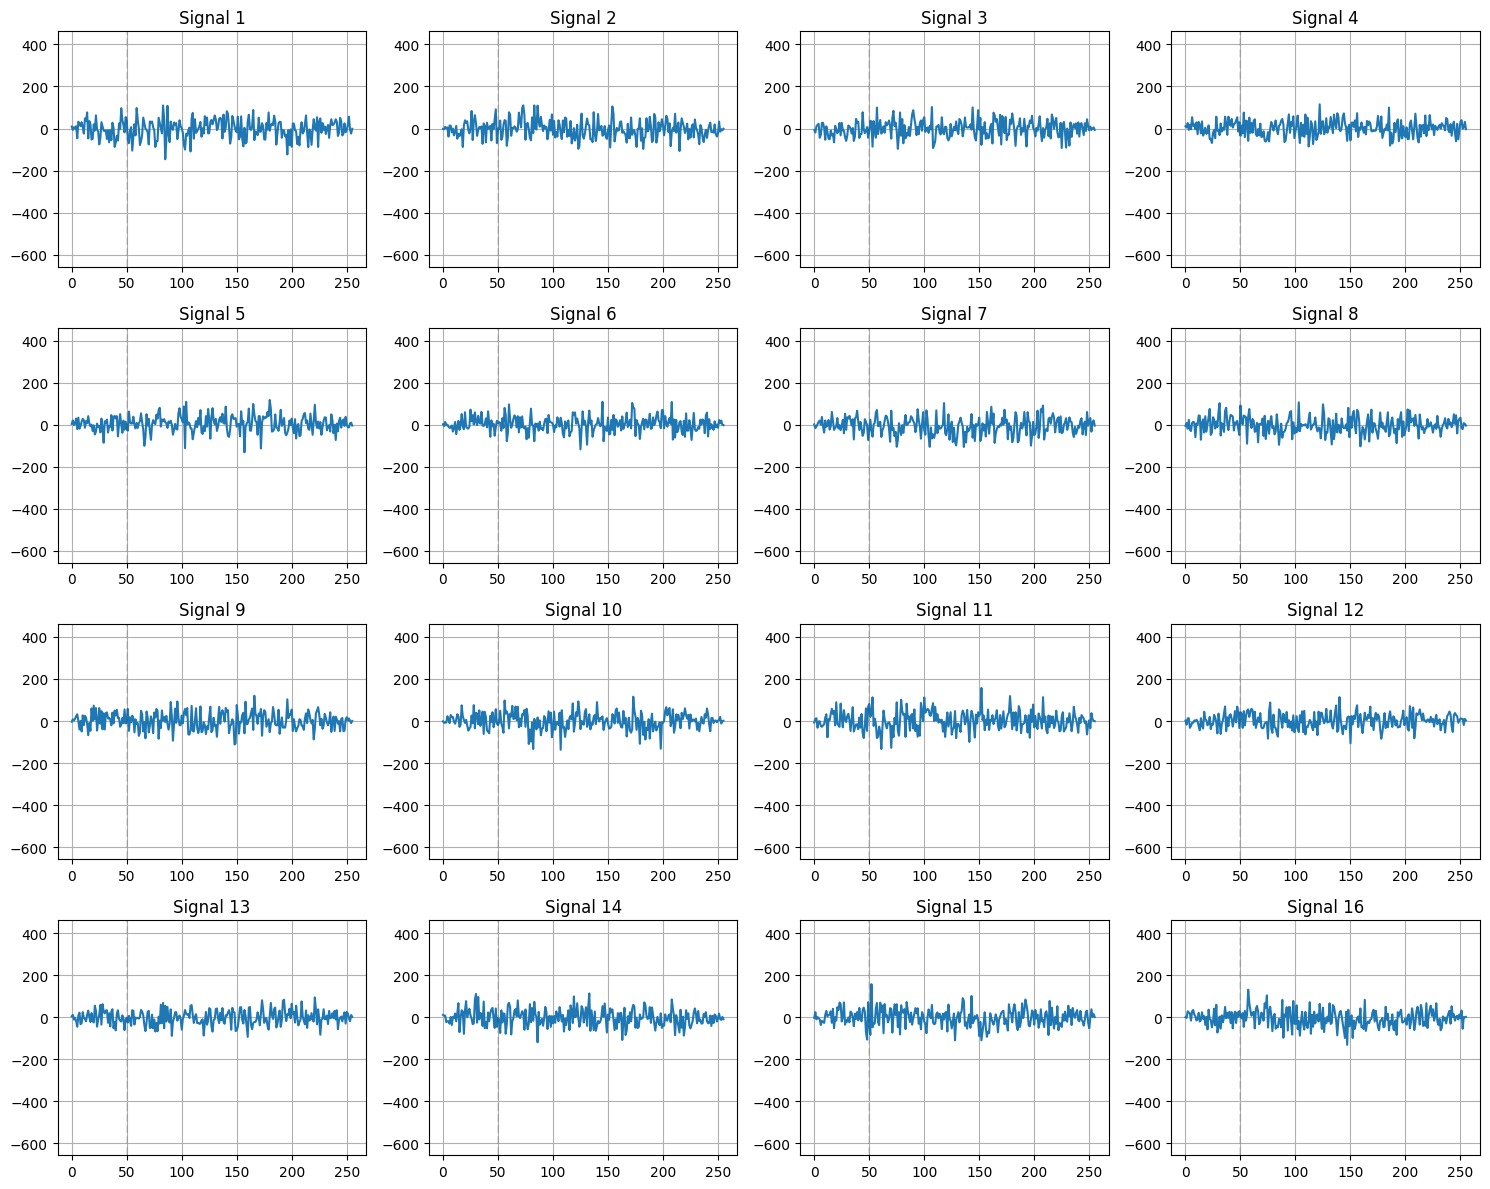

In [257]:
# create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(batch_size, nz, 1, device=device)
# fixed_parameter_noise = torch.randn(batch_size, num_classes, 1, device=device)

fixed_random_indices = torch.randint(0, num_classes, (batch_size,)).long()
# create a one-hot encoding from the random indices
fixed_random_one_hot_encoding = torch.nn.functional.one_hot(fixed_random_indices, num_classes=num_classes).float()
fixed_random_one_hot_encoding = fixed_random_one_hot_encoding.unsqueeze(-1)

# plot generated signals before training
with torch.no_grad():
    if (gans_type == 'cdcgans' or gans_type == 'fccdcgans'):
        fake_signals = netG(fixed_noise, fixed_random_one_hot_encoding).detach().cpu()
    else:
        fake_signals = netG(fixed_noise).detach().cpu()
    fig, axes = plt.subplots(4, 4, figsize=(15, 12))

    axes = axes.flatten()

    # plot each signal on a separate subplot
    for i, ax in enumerate(axes):
        x = np.arange(fake_signals.size(dim=2))
        y = fake_signals[i, :, :].flatten()
        y = y * dataset.scaling_factor
        y = y * dataset.std + dataset.mean
        ax.plot(x, y)

        ax.axvline(x=50, color='black', linestyle='--', alpha=0.1)
        ax.set_title(f'Signal {i+1}')
        ax.grid(True)
        ax.set_ylim(common_ylim_signal)

    for i in range(512, 8*4):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.savefig('../data/gw-dcgans-images/gw-dcgans_epoch_0.png')
    plt.show()

### Training

Starting Training Loop...
[0/32][0/188]	Loss_D: 1.2812	Loss_G: 0.7736	D(x): 0.5458	D(G(z)): 0.4717 / 0.4731
[0/32][50/188]	Loss_D: 0.8725	Loss_G: 1.0747	D(x): 0.7612	D(G(z)): 0.3563 / 0.3749
[0/32][100/188]	Loss_D: 0.7692	Loss_G: 1.3516	D(x): 0.7886	D(G(z)): 0.2817 / 0.3079
[0/32][150/188]	Loss_D: 0.7003	Loss_G: 1.6236	D(x): 0.8282	D(G(z)): 0.2379 / 0.2539
Epoch 0: SGD Discriminator lr 0.0000200 -> 0.0000197
Epoch 0: SGD Generator lr 0.0000200 -> 0.0000197


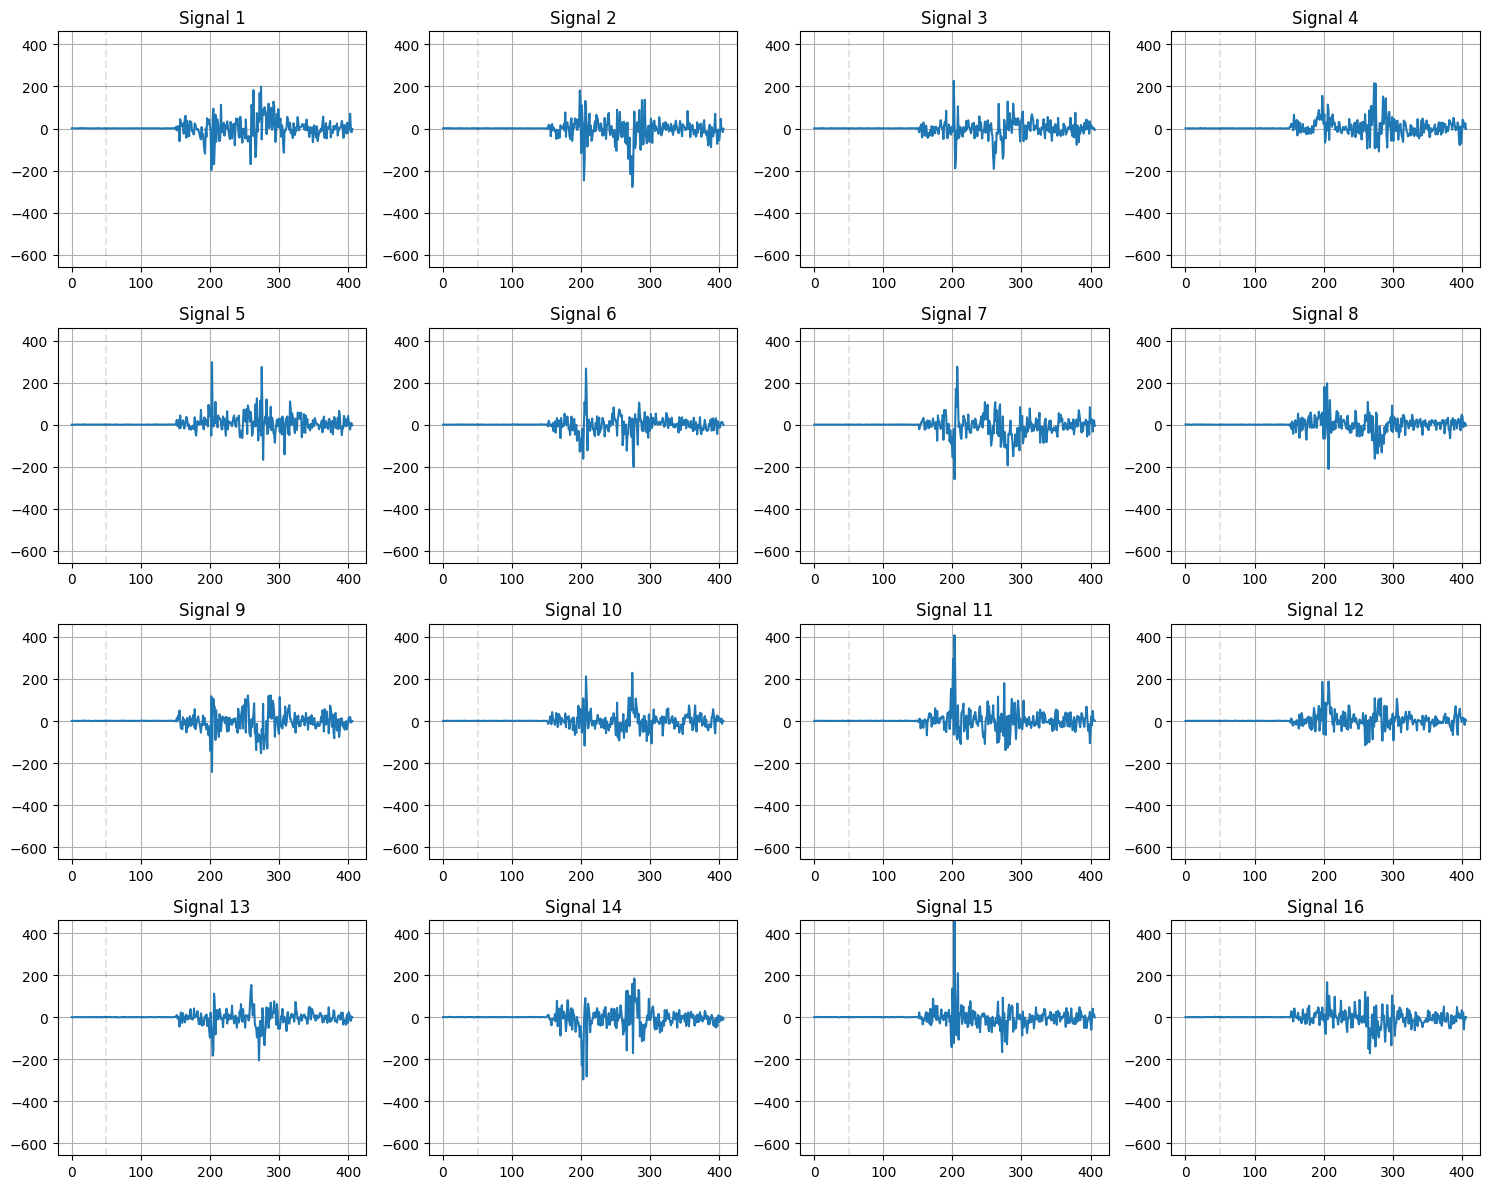

[1/32][0/188]	Loss_D: 0.6935	Loss_G: 1.6118	D(x): 0.7974	D(G(z)): 0.2194 / 0.2774
[1/32][50/188]	Loss_D: 0.7205	Loss_G: 1.6325	D(x): 0.8409	D(G(z)): 0.2264 / 0.2868
[1/32][100/188]	Loss_D: 0.7667	Loss_G: 1.4978	D(x): 0.7675	D(G(z)): 0.2531 / 0.3077
[1/32][150/188]	Loss_D: 0.6848	Loss_G: 1.8932	D(x): 0.8946	D(G(z)): 0.2498 / 0.2235
Epoch 1: SGD Discriminator lr 0.0000197 -> 0.0000193
Epoch 1: SGD Generator lr 0.0000197 -> 0.0000193


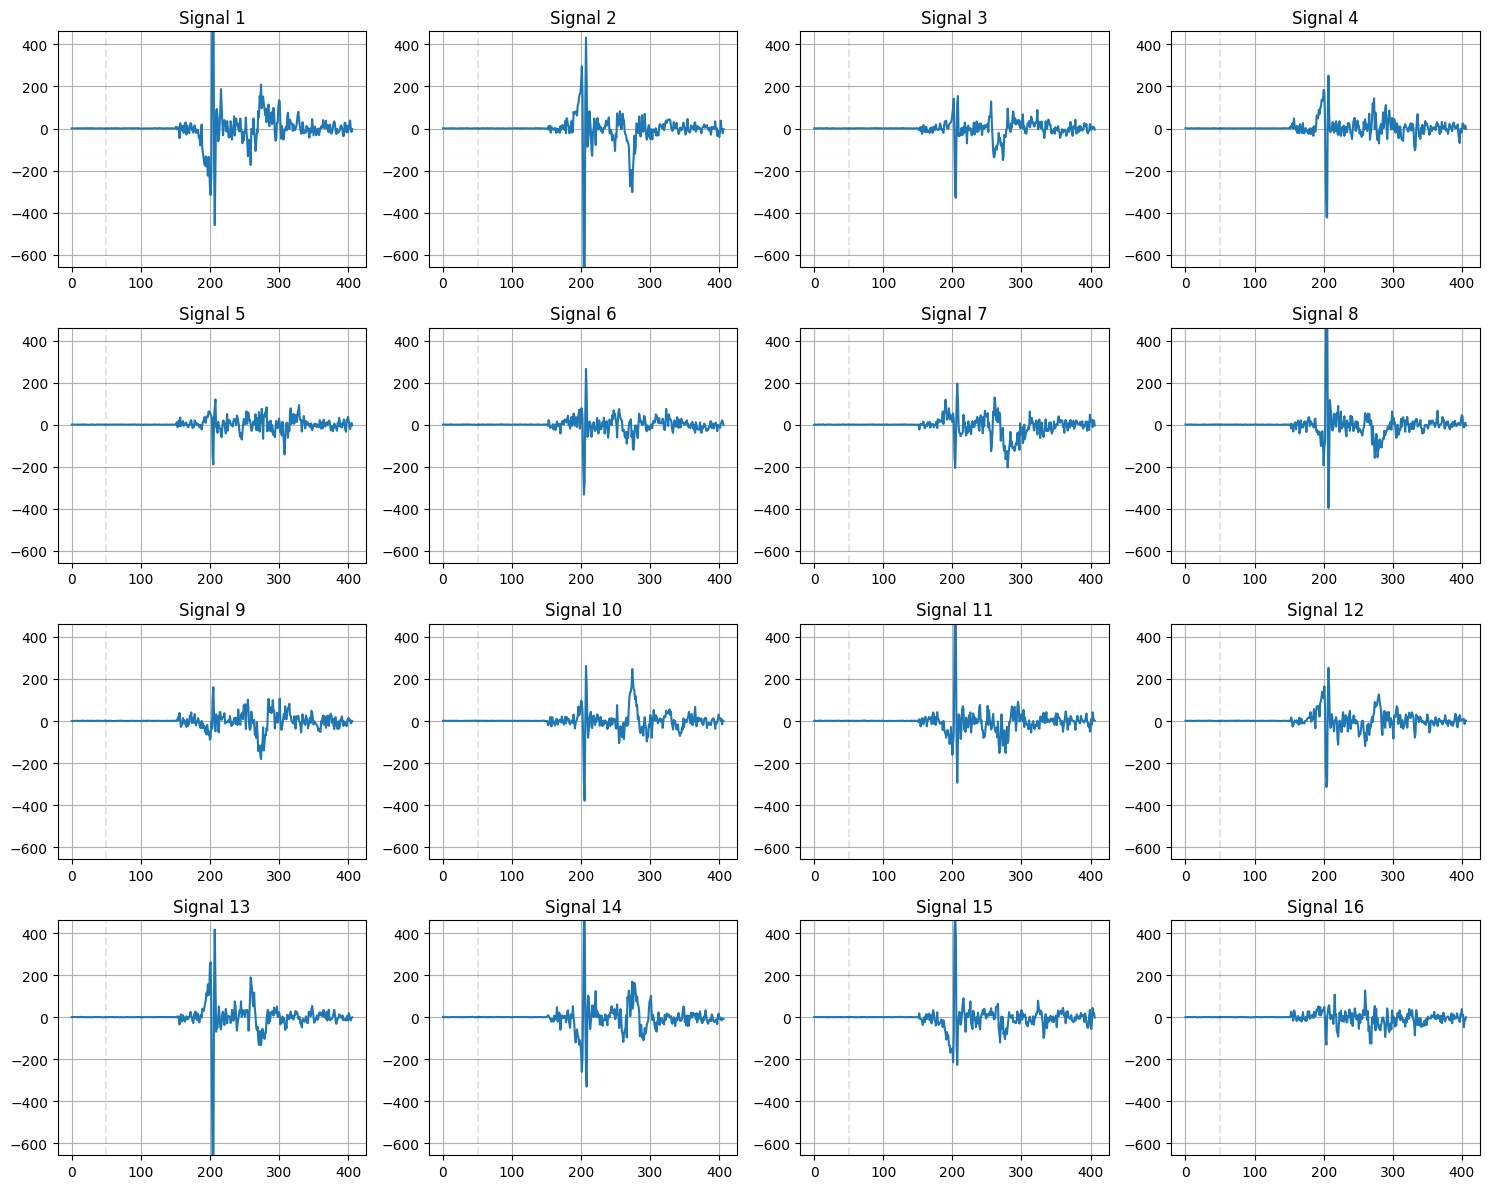

[2/32][0/188]	Loss_D: 0.6329	Loss_G: 1.5071	D(x): 0.8872	D(G(z)): 0.2803 / 0.2719
[2/32][50/188]	Loss_D: 0.6668	Loss_G: 1.7767	D(x): 0.8306	D(G(z)): 0.2324 / 0.2367
[2/32][100/188]	Loss_D: 0.6734	Loss_G: 1.6272	D(x): 0.8813	D(G(z)): 0.2562 / 0.2494
[2/32][150/188]	Loss_D: 0.5866	Loss_G: 1.6826	D(x): 0.9027	D(G(z)): 0.2477 / 0.2393
Epoch 2: SGD Discriminator lr 0.0000193 -> 0.0000190
Epoch 2: SGD Generator lr 0.0000193 -> 0.0000190


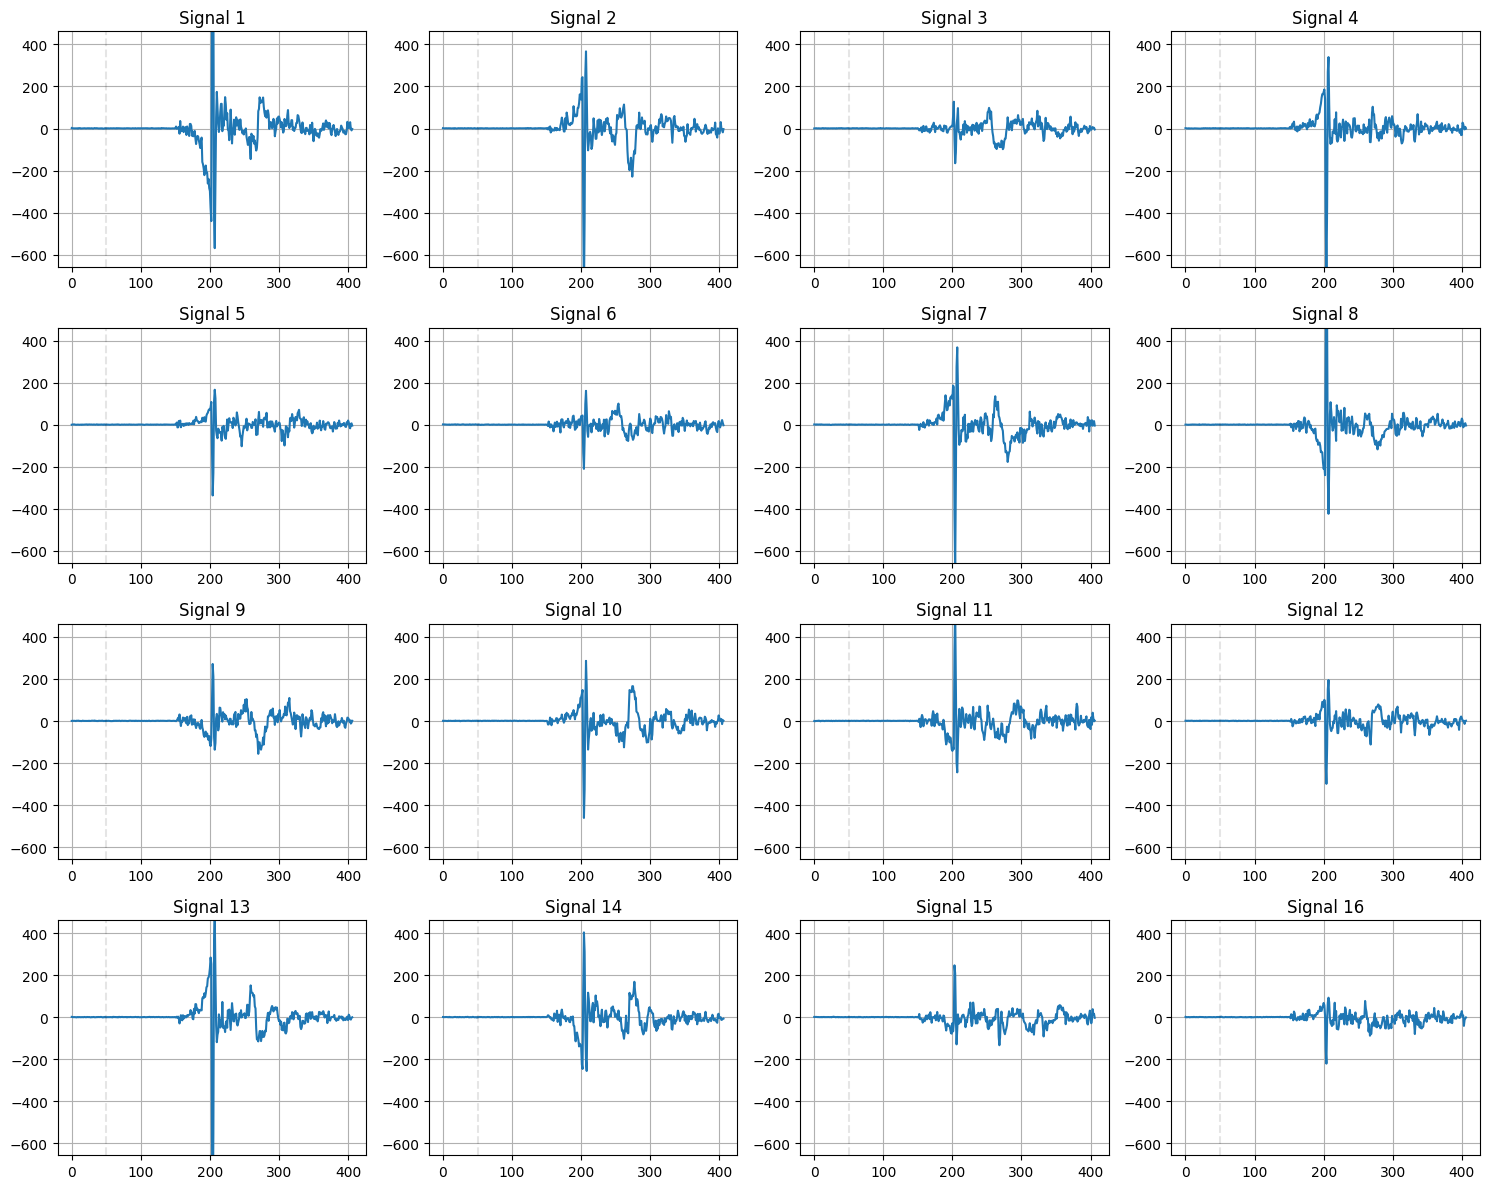

[3/32][0/188]	Loss_D: 0.8070	Loss_G: 1.4399	D(x): 0.8165	D(G(z)): 0.2831 / 0.3048
[3/32][50/188]	Loss_D: 0.6269	Loss_G: 1.6863	D(x): 0.8680	D(G(z)): 0.2194 / 0.2544
[3/32][100/188]	Loss_D: 0.6391	Loss_G: 1.8769	D(x): 0.8852	D(G(z)): 0.1911 / 0.2141
[3/32][150/188]	Loss_D: 0.6649	Loss_G: 1.9721	D(x): 0.8645	D(G(z)): 0.2107 / 0.2158
Epoch 3: SGD Discriminator lr 0.0000190 -> 0.0000187
Epoch 3: SGD Generator lr 0.0000190 -> 0.0000187


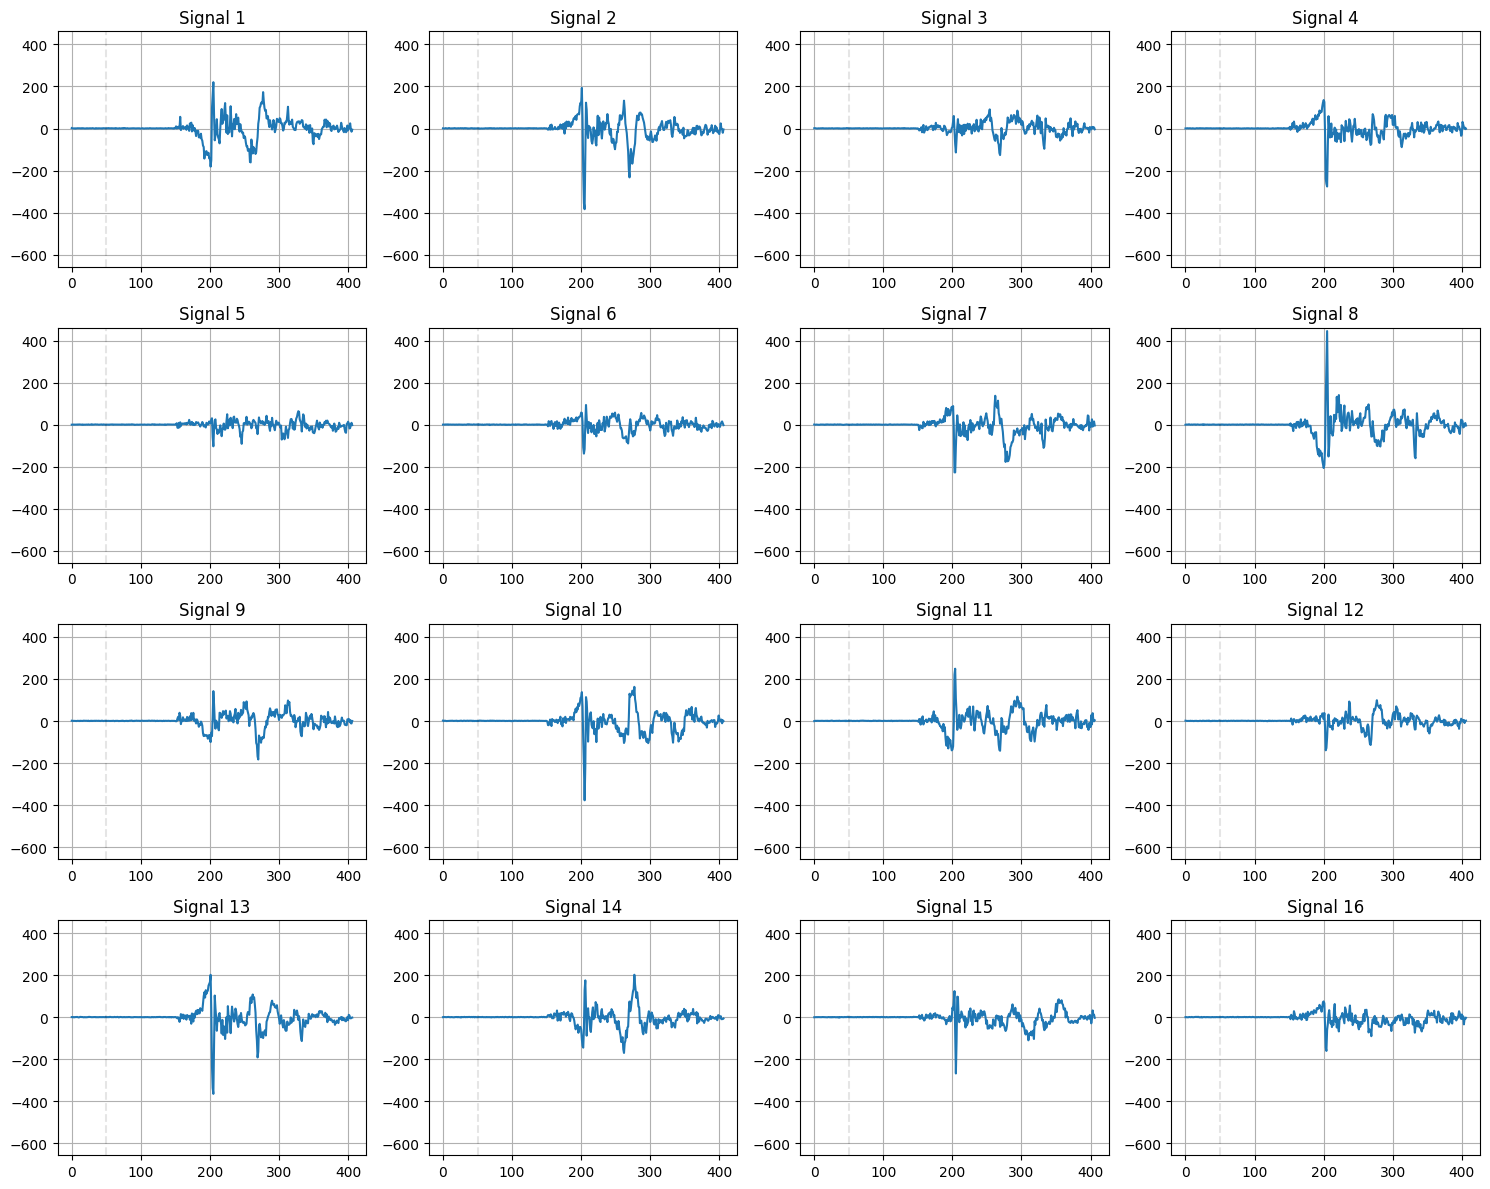

[4/32][0/188]	Loss_D: 0.7049	Loss_G: 1.5924	D(x): 0.8802	D(G(z)): 0.3236 / 0.2534
[4/32][50/188]	Loss_D: 0.7128	Loss_G: 1.2011	D(x): 0.8627	D(G(z)): 0.3140 / 0.3610
[4/32][100/188]	Loss_D: 0.6181	Loss_G: 1.6661	D(x): 0.9148	D(G(z)): 0.2675 / 0.2819
[4/32][150/188]	Loss_D: 0.8369	Loss_G: 1.4973	D(x): 0.8255	D(G(z)): 0.3467 / 0.3174
Epoch 4: SGD Discriminator lr 0.0000187 -> 0.0000183
Epoch 4: SGD Generator lr 0.0000187 -> 0.0000183


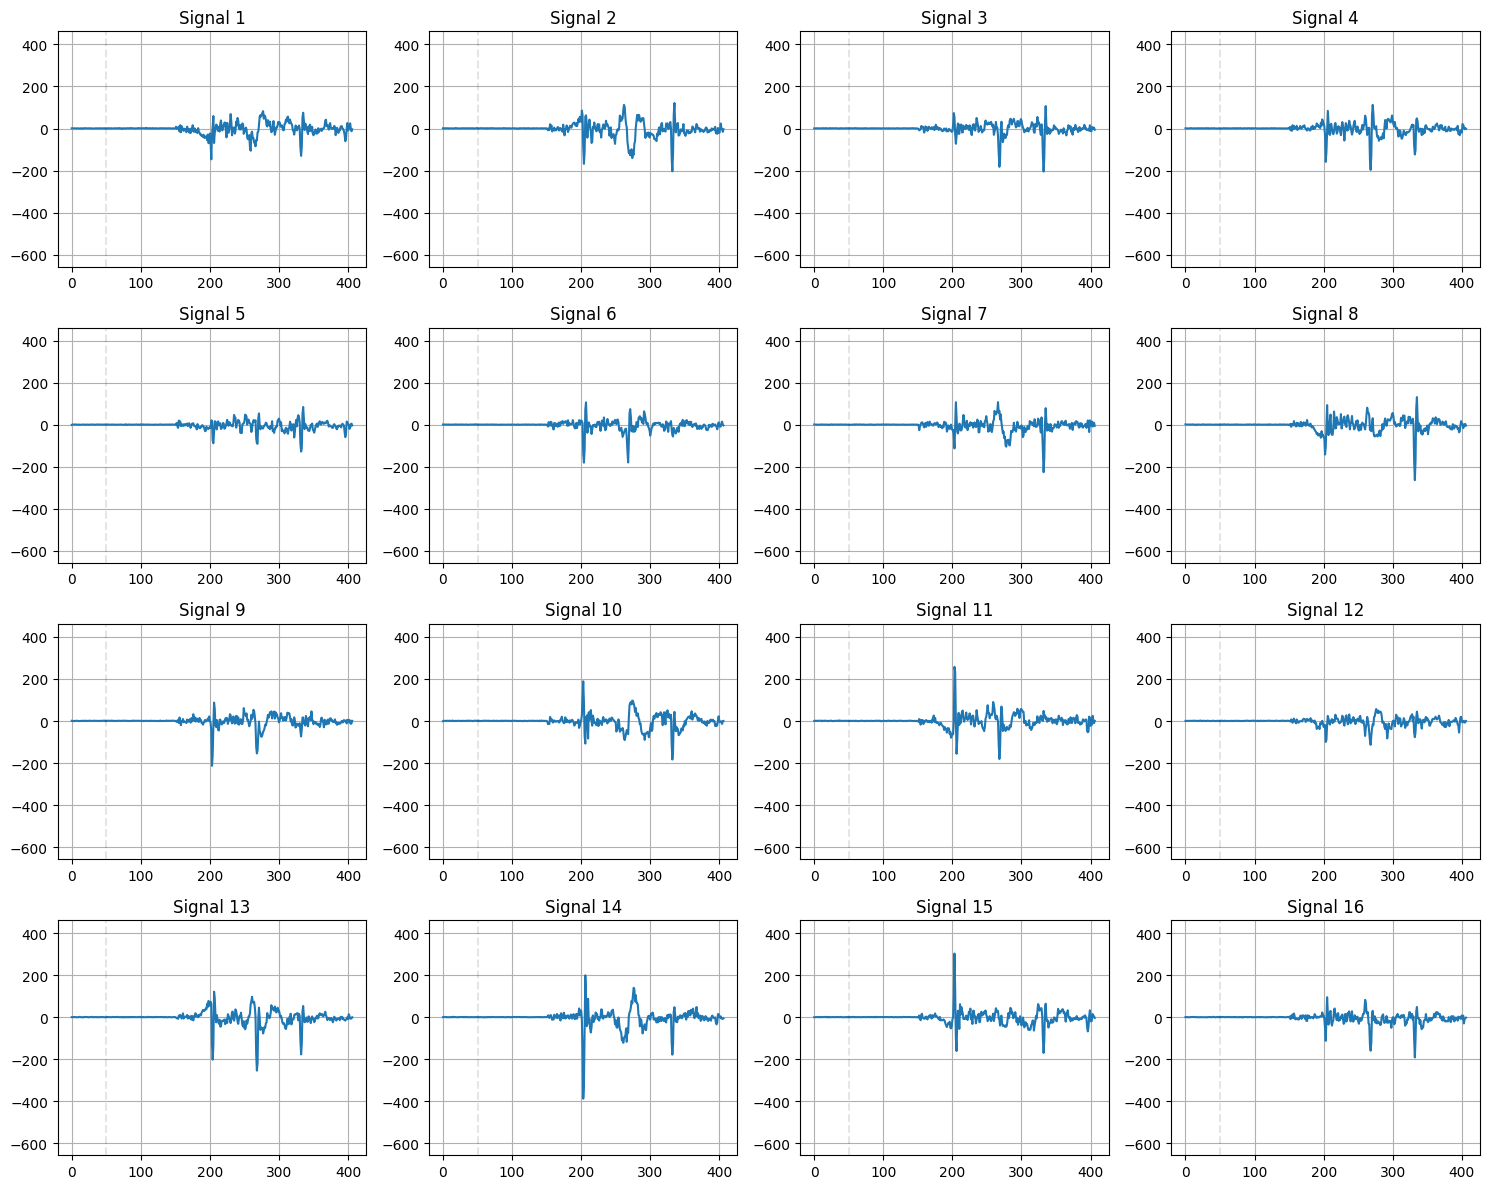

[5/32][0/188]	Loss_D: 0.6333	Loss_G: 1.7121	D(x): 0.8632	D(G(z)): 0.1852 / 0.2521
[5/32][50/188]	Loss_D: 0.7439	Loss_G: 1.4143	D(x): 0.8468	D(G(z)): 0.3005 / 0.3184
[5/32][100/188]	Loss_D: 0.7271	Loss_G: 2.2100	D(x): 0.8158	D(G(z)): 0.1510 / 0.1982
[5/32][150/188]	Loss_D: 0.7635	Loss_G: 1.5894	D(x): 0.8265	D(G(z)): 0.2775 / 0.2827
Epoch 5: SGD Discriminator lr 0.0000183 -> 0.0000180
Epoch 5: SGD Generator lr 0.0000183 -> 0.0000180


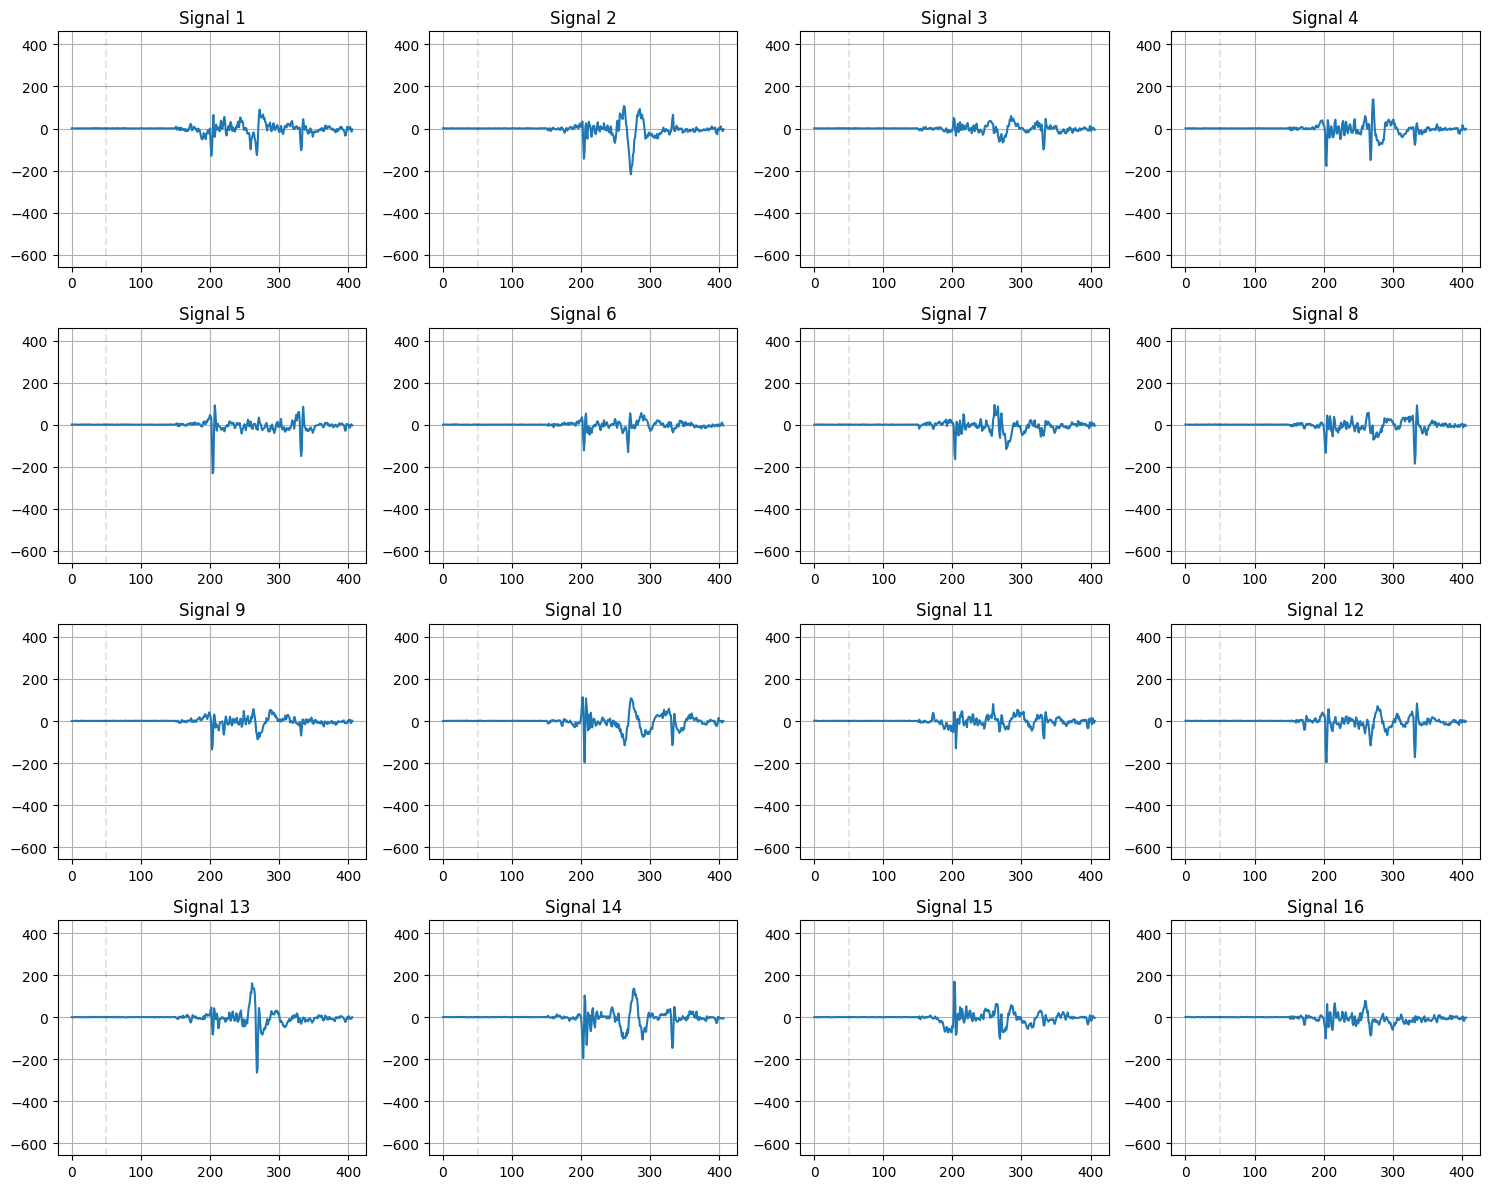

[6/32][0/188]	Loss_D: 0.7354	Loss_G: 1.8928	D(x): 0.8763	D(G(z)): 0.3240 / 0.2484
[6/32][50/188]	Loss_D: 0.7191	Loss_G: 2.0573	D(x): 0.8247	D(G(z)): 0.2110 / 0.2138
[6/32][100/188]	Loss_D: 0.6237	Loss_G: 2.0967	D(x): 0.8451	D(G(z)): 0.1552 / 0.1997
[6/32][150/188]	Loss_D: 0.7145	Loss_G: 2.4408	D(x): 0.8453	D(G(z)): 0.1748 / 0.1647
Epoch 6: SGD Discriminator lr 0.0000180 -> 0.0000177
Epoch 6: SGD Generator lr 0.0000180 -> 0.0000177


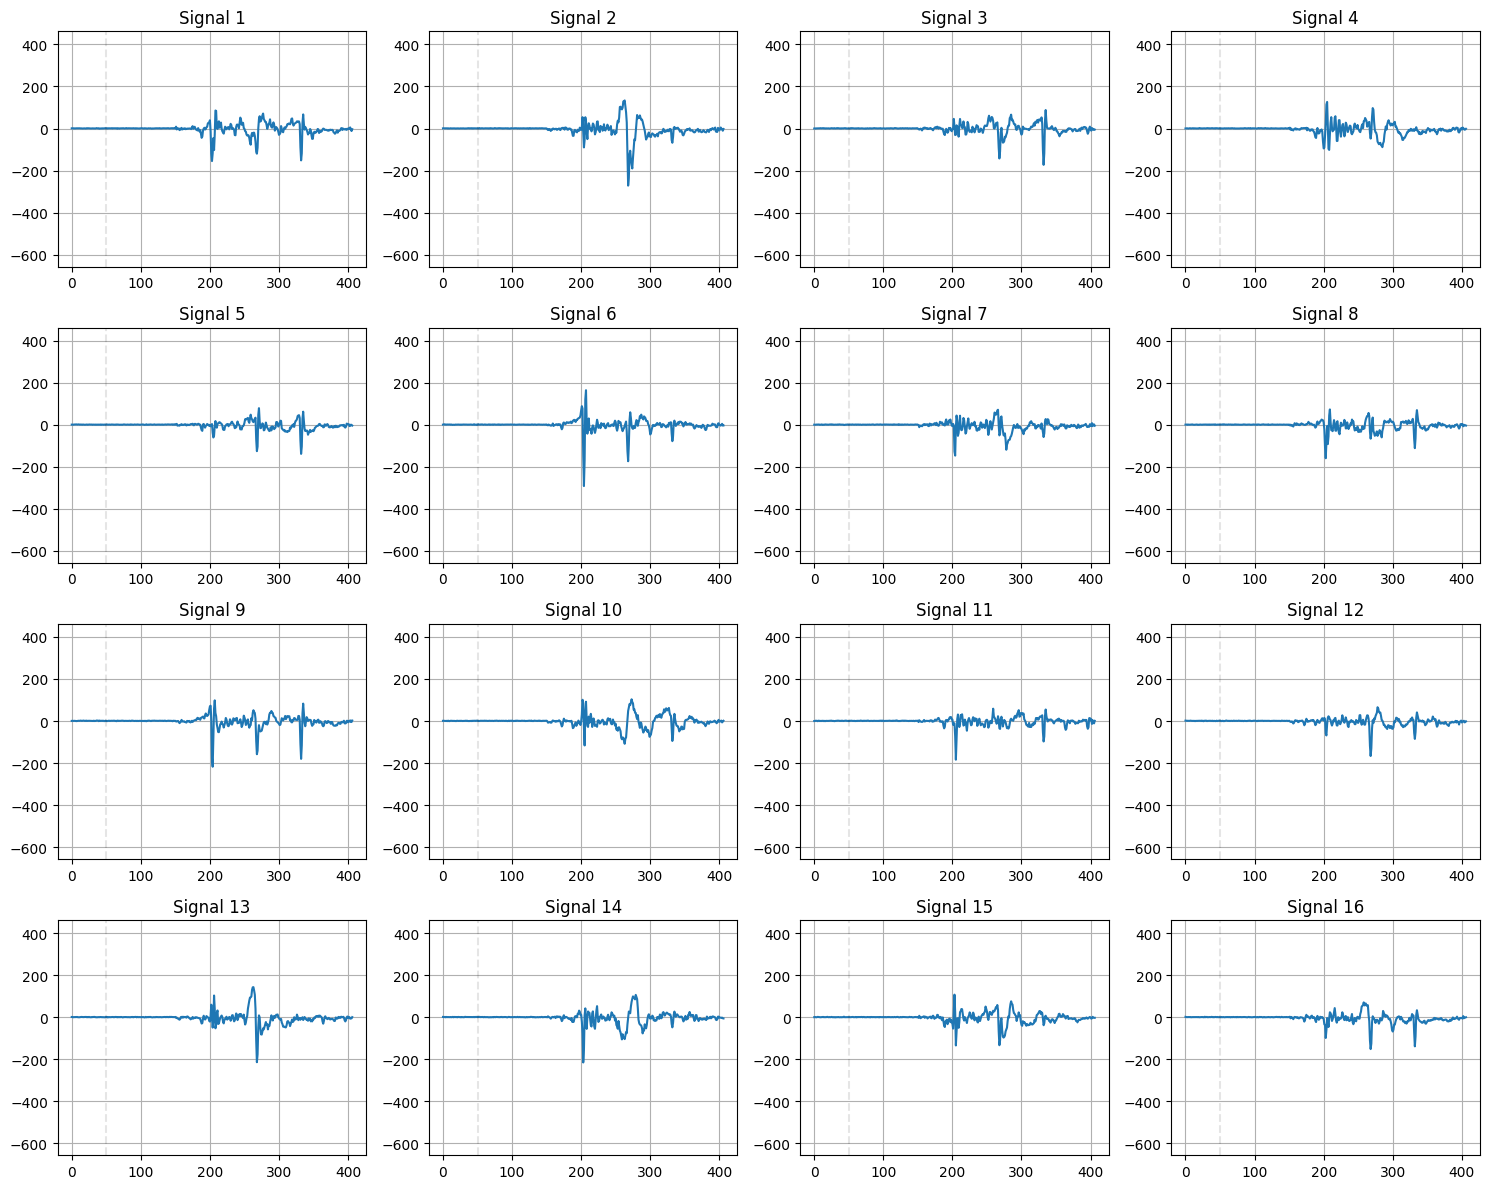

[7/32][0/188]	Loss_D: 0.6271	Loss_G: 1.7429	D(x): 0.9314	D(G(z)): 0.2366 / 0.2816
[7/32][50/188]	Loss_D: 0.8428	Loss_G: 2.1370	D(x): 0.7516	D(G(z)): 0.2439 / 0.1799
[7/32][100/188]	Loss_D: 0.7532	Loss_G: 1.6778	D(x): 0.8381	D(G(z)): 0.3161 / 0.2694
[7/32][150/188]	Loss_D: 0.6345	Loss_G: 1.8284	D(x): 0.8589	D(G(z)): 0.1511 / 0.2409
Epoch 7: SGD Discriminator lr 0.0000177 -> 0.0000173
Epoch 7: SGD Generator lr 0.0000177 -> 0.0000173


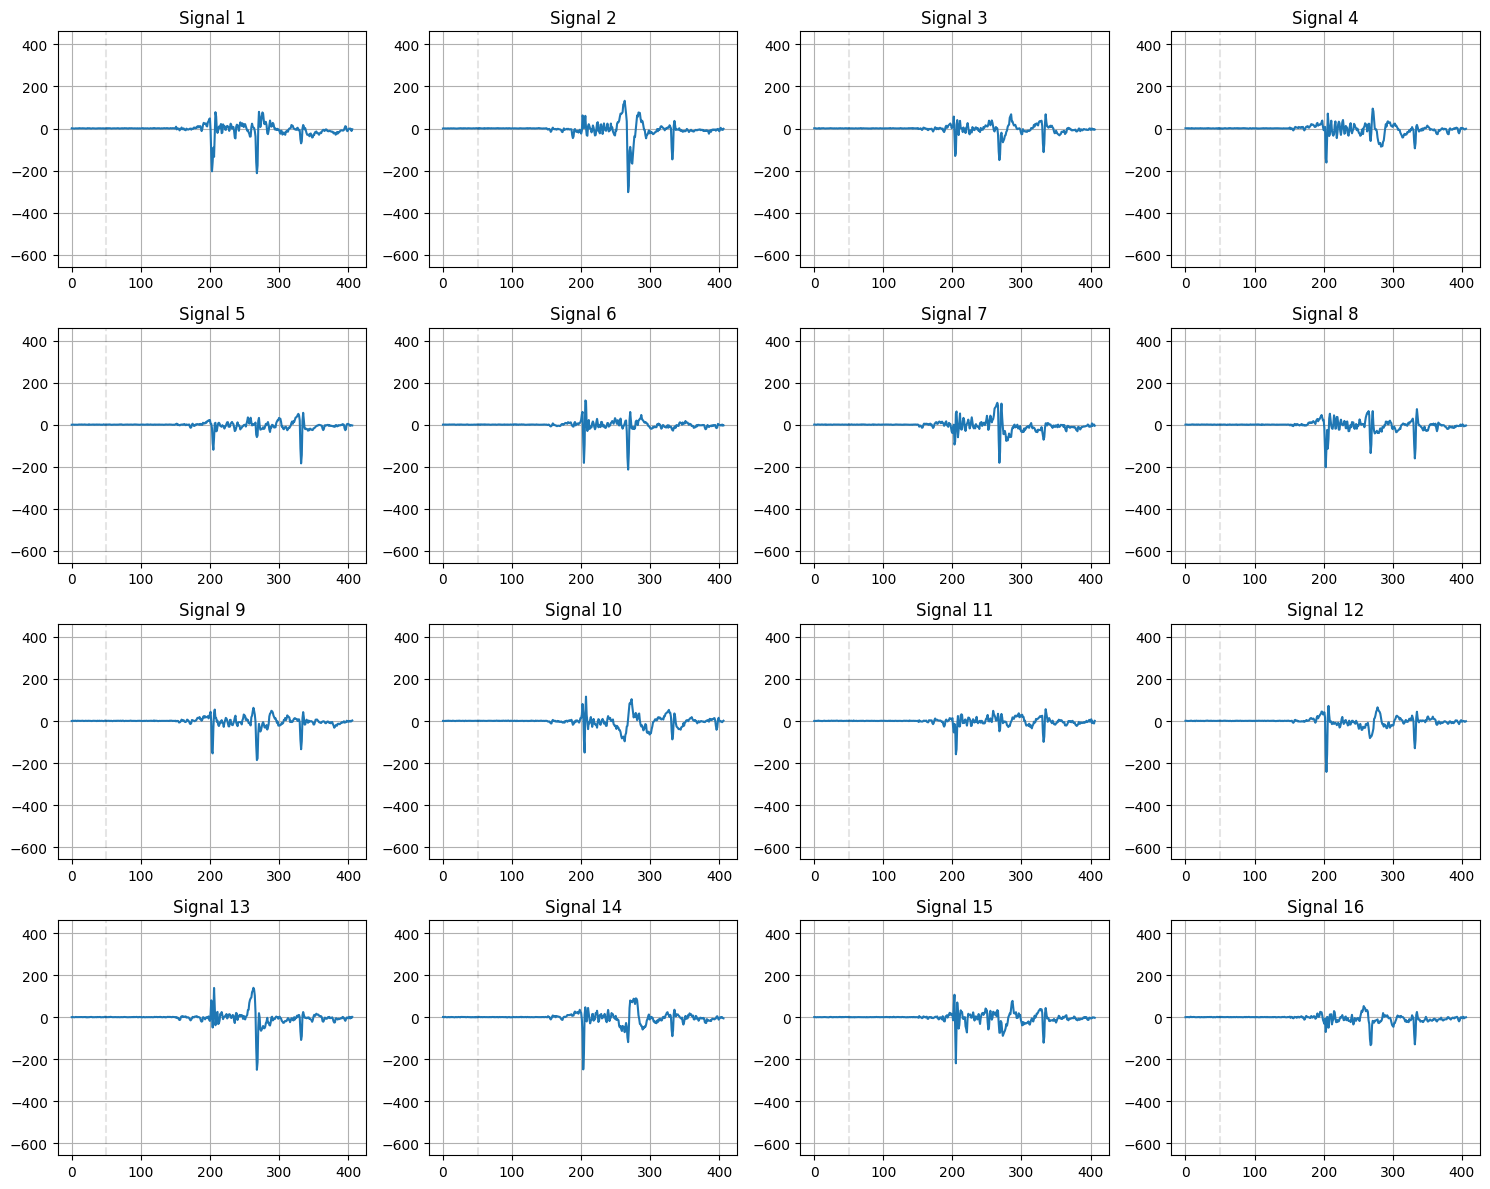

[8/32][0/188]	Loss_D: 0.6683	Loss_G: 2.1255	D(x): 0.8332	D(G(z)): 0.1915 / 0.1689
[8/32][50/188]	Loss_D: 0.7306	Loss_G: 1.3459	D(x): 0.8598	D(G(z)): 0.3284 / 0.3551
[8/32][100/188]	Loss_D: 0.5889	Loss_G: 2.4550	D(x): 0.8785	D(G(z)): 0.1509 / 0.1376
[8/32][150/188]	Loss_D: 0.5978	Loss_G: 1.7766	D(x): 0.8508	D(G(z)): 0.1854 / 0.2407
Epoch 8: SGD Discriminator lr 0.0000173 -> 0.0000170
Epoch 8: SGD Generator lr 0.0000173 -> 0.0000170


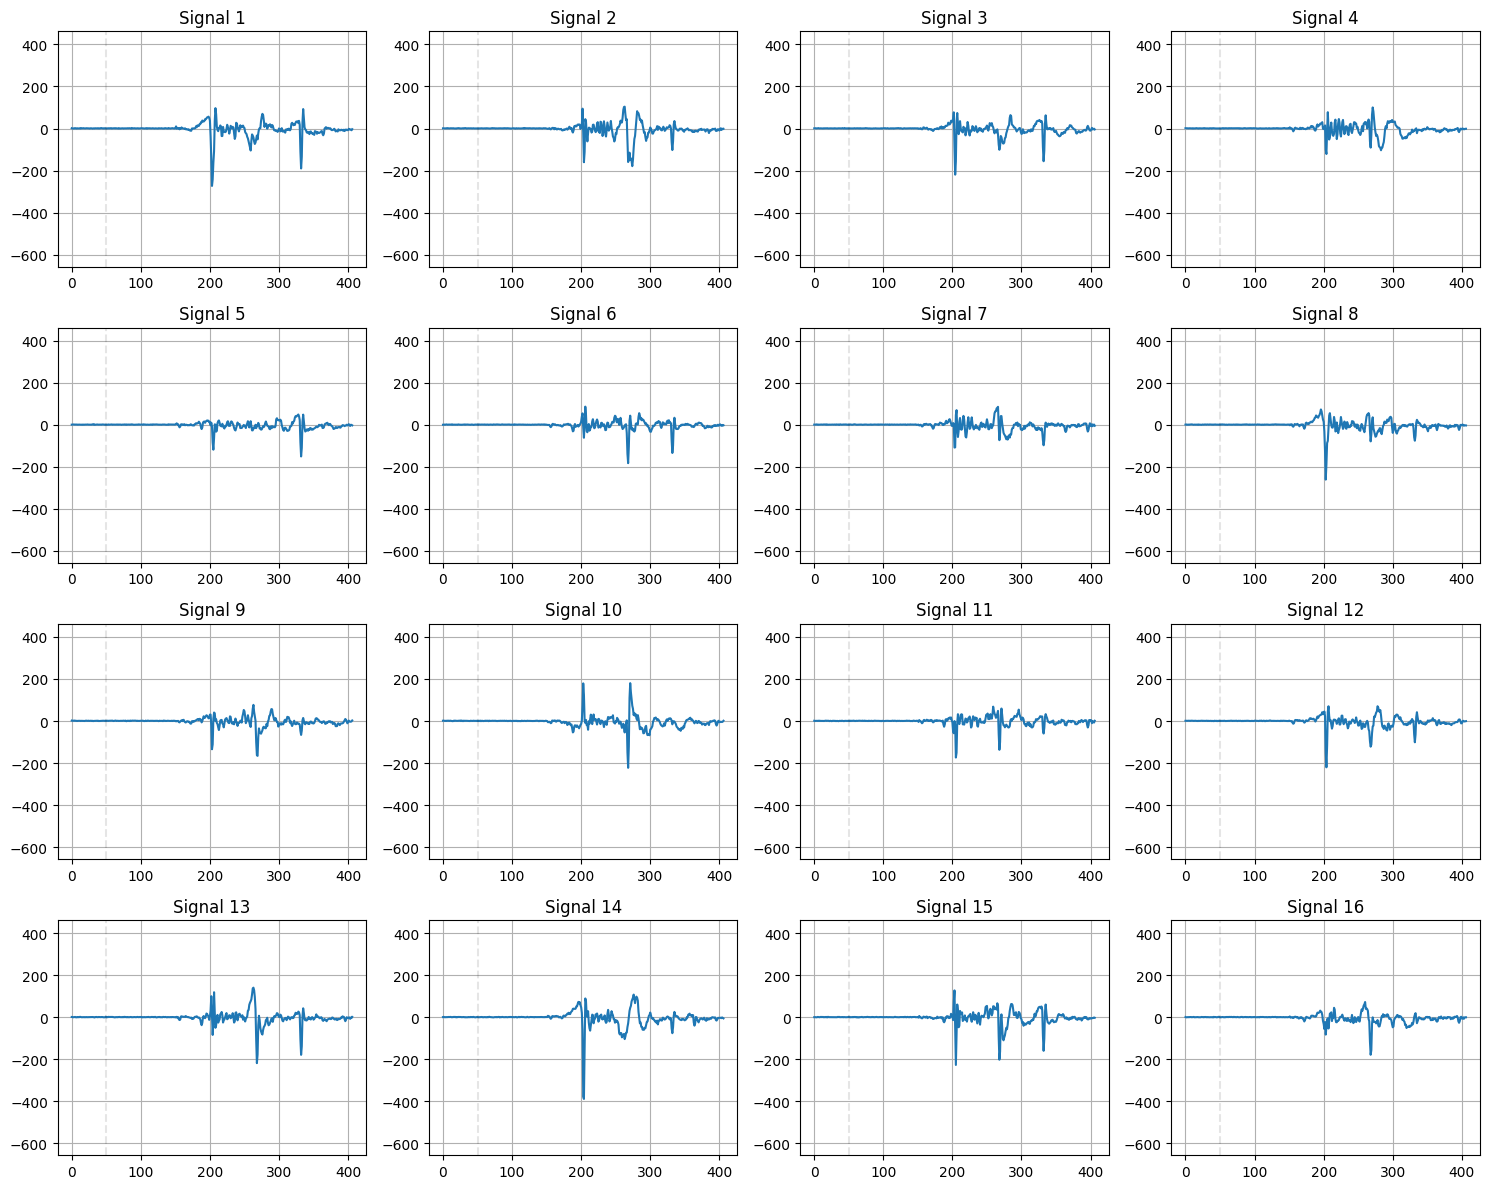

[9/32][0/188]	Loss_D: 0.7077	Loss_G: 2.2856	D(x): 0.8505	D(G(z)): 0.2095 / 0.1745
[9/32][50/188]	Loss_D: 0.6891	Loss_G: 2.2301	D(x): 0.8377	D(G(z)): 0.1718 / 0.1919
[9/32][100/188]	Loss_D: 0.6457	Loss_G: 1.8821	D(x): 0.8599	D(G(z)): 0.2143 / 0.2188
[9/32][150/188]	Loss_D: 0.7235	Loss_G: 2.0352	D(x): 0.8201	D(G(z)): 0.2212 / 0.1952
Epoch 9: SGD Discriminator lr 0.0000170 -> 0.0000167
Epoch 9: SGD Generator lr 0.0000170 -> 0.0000167


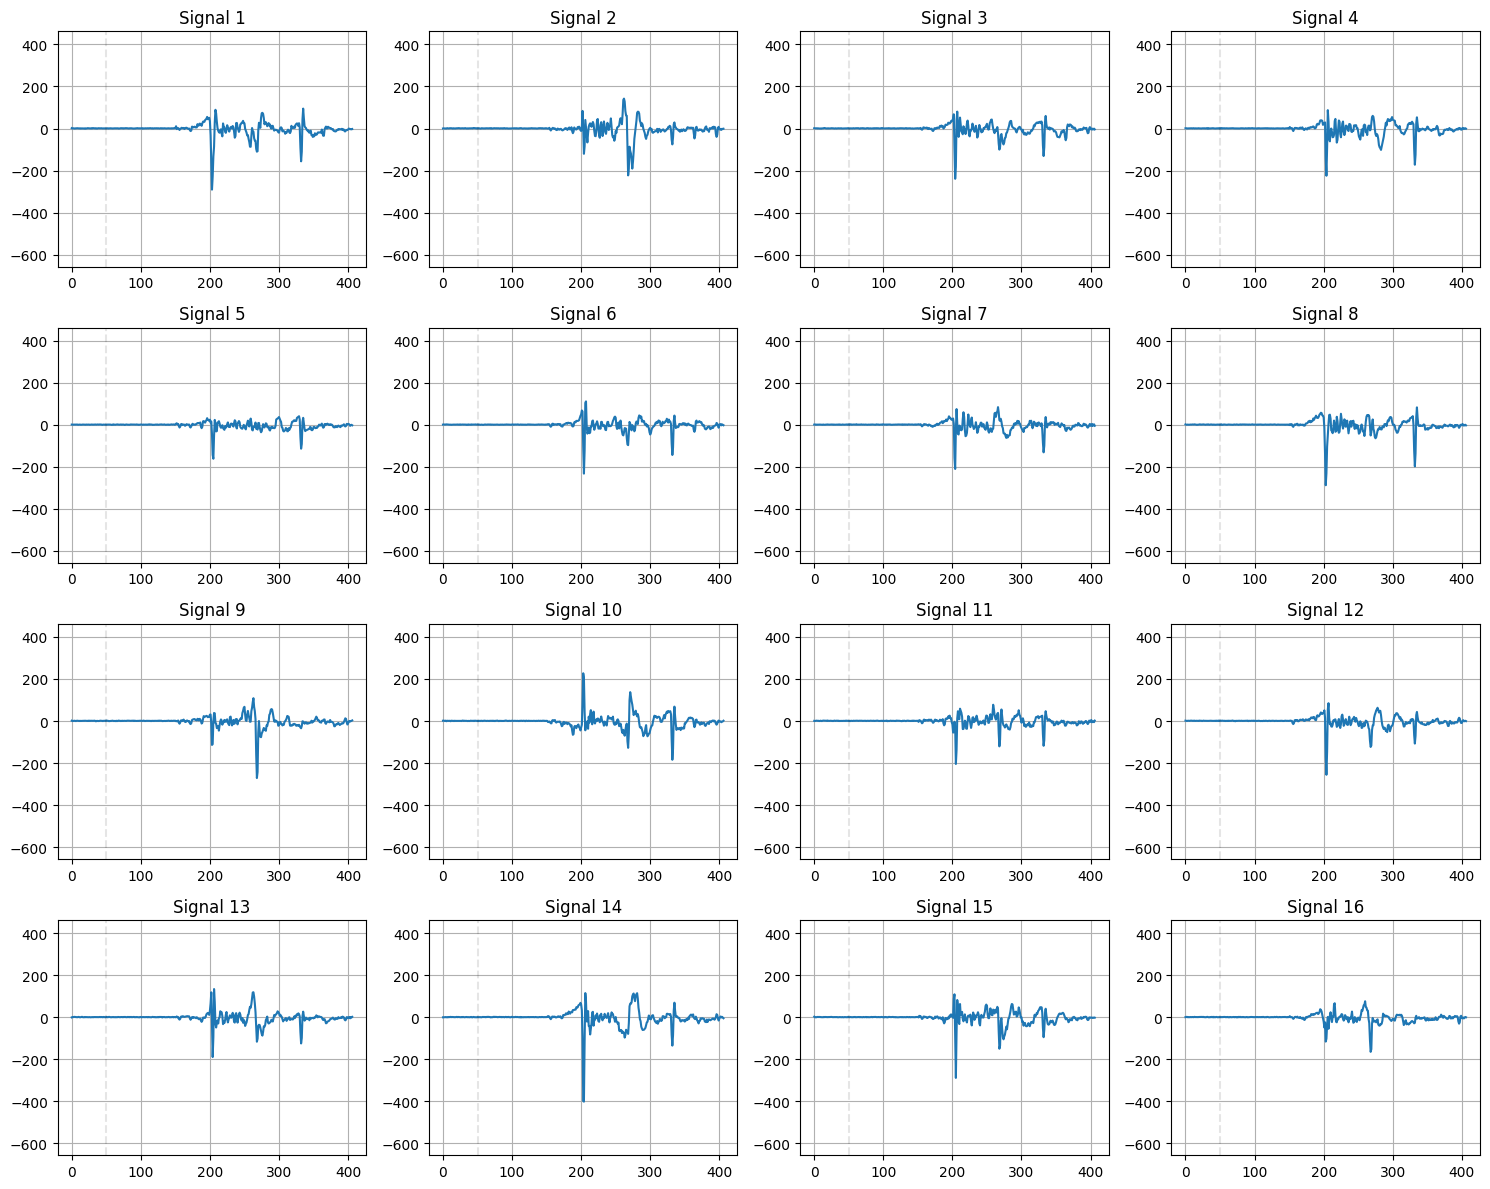

[10/32][0/188]	Loss_D: 0.7101	Loss_G: 1.7715	D(x): 0.8655	D(G(z)): 0.2931 / 0.2284
[10/32][50/188]	Loss_D: 0.7231	Loss_G: 1.9088	D(x): 0.8450	D(G(z)): 0.2473 / 0.2201
[10/32][100/188]	Loss_D: 0.6624	Loss_G: 1.7298	D(x): 0.8923	D(G(z)): 0.2443 / 0.2550
[10/32][150/188]	Loss_D: 0.5753	Loss_G: 2.0382	D(x): 0.8832	D(G(z)): 0.2157 / 0.1775
Epoch 10: SGD Discriminator lr 0.0000167 -> 0.0000163
Epoch 10: SGD Generator lr 0.0000167 -> 0.0000163


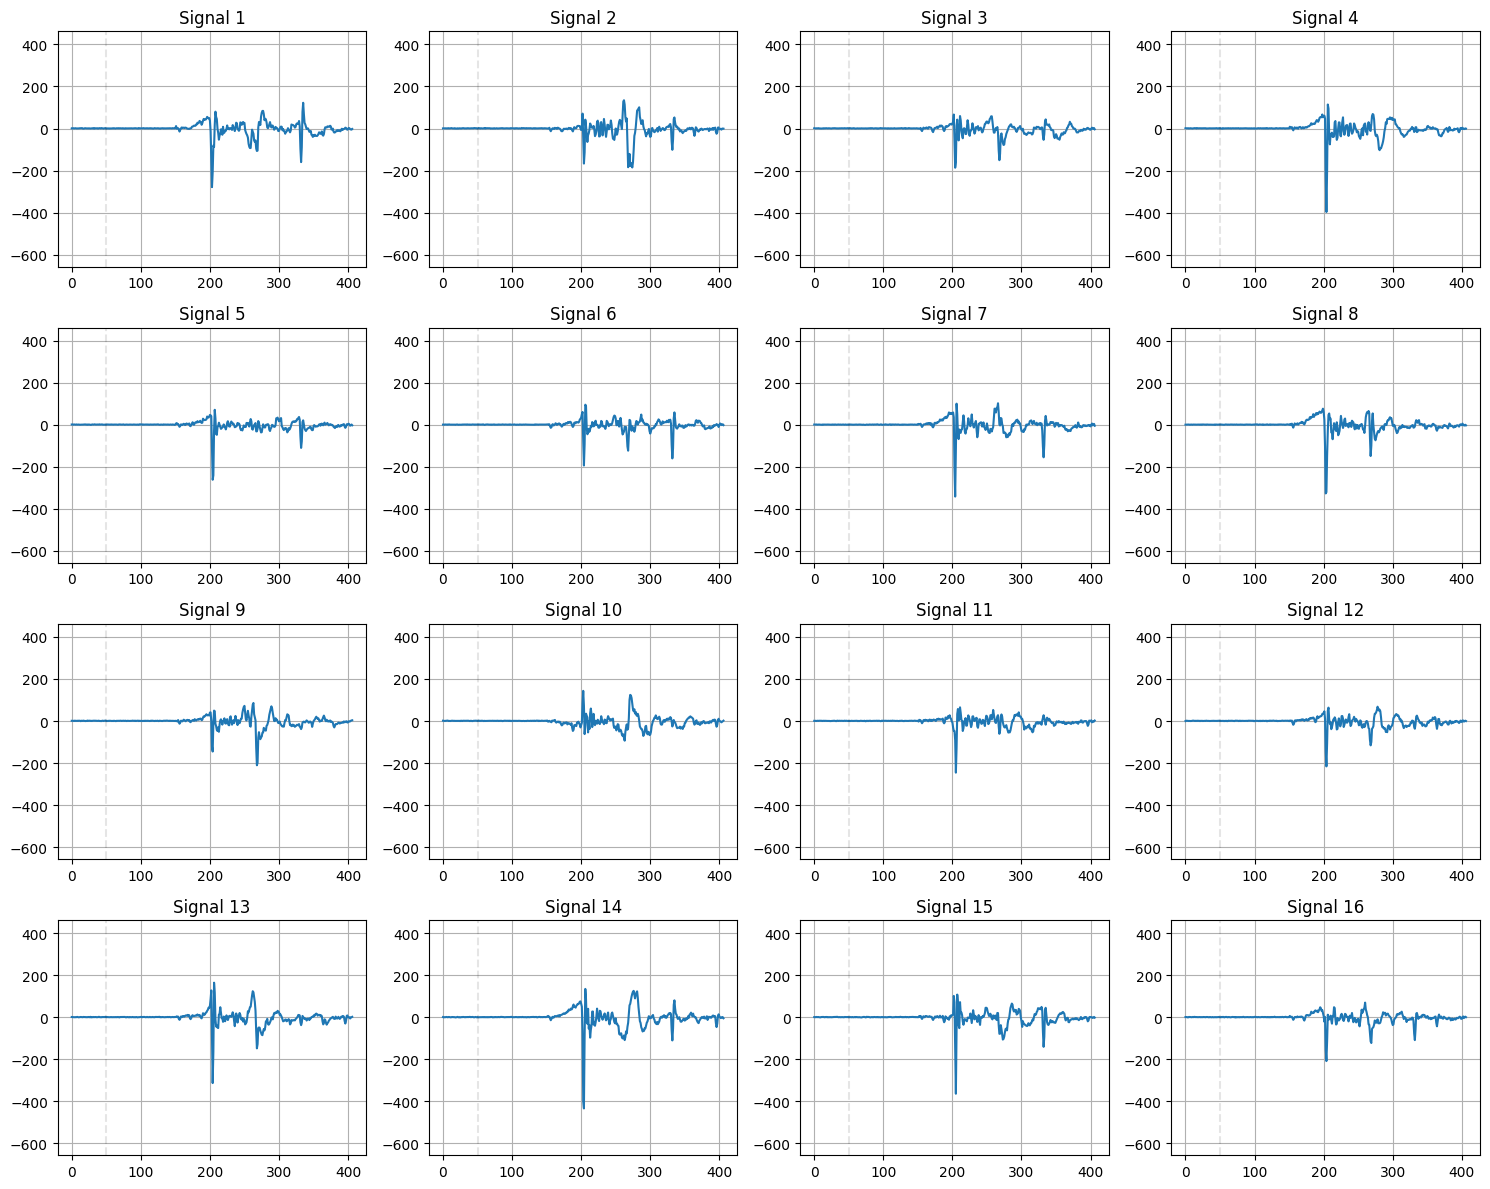

[11/32][0/188]	Loss_D: 0.5682	Loss_G: 2.1443	D(x): 0.9389	D(G(z)): 0.1752 / 0.2278
[11/32][50/188]	Loss_D: 0.6449	Loss_G: 1.2379	D(x): 0.8950	D(G(z)): 0.2968 / 0.3348
[11/32][100/188]	Loss_D: 0.6864	Loss_G: 2.0205	D(x): 0.8652	D(G(z)): 0.2648 / 0.2052
[11/32][150/188]	Loss_D: 0.7572	Loss_G: 1.4703	D(x): 0.8316	D(G(z)): 0.2958 / 0.2959
Epoch 11: SGD Discriminator lr 0.0000163 -> 0.0000160
Epoch 11: SGD Generator lr 0.0000163 -> 0.0000160


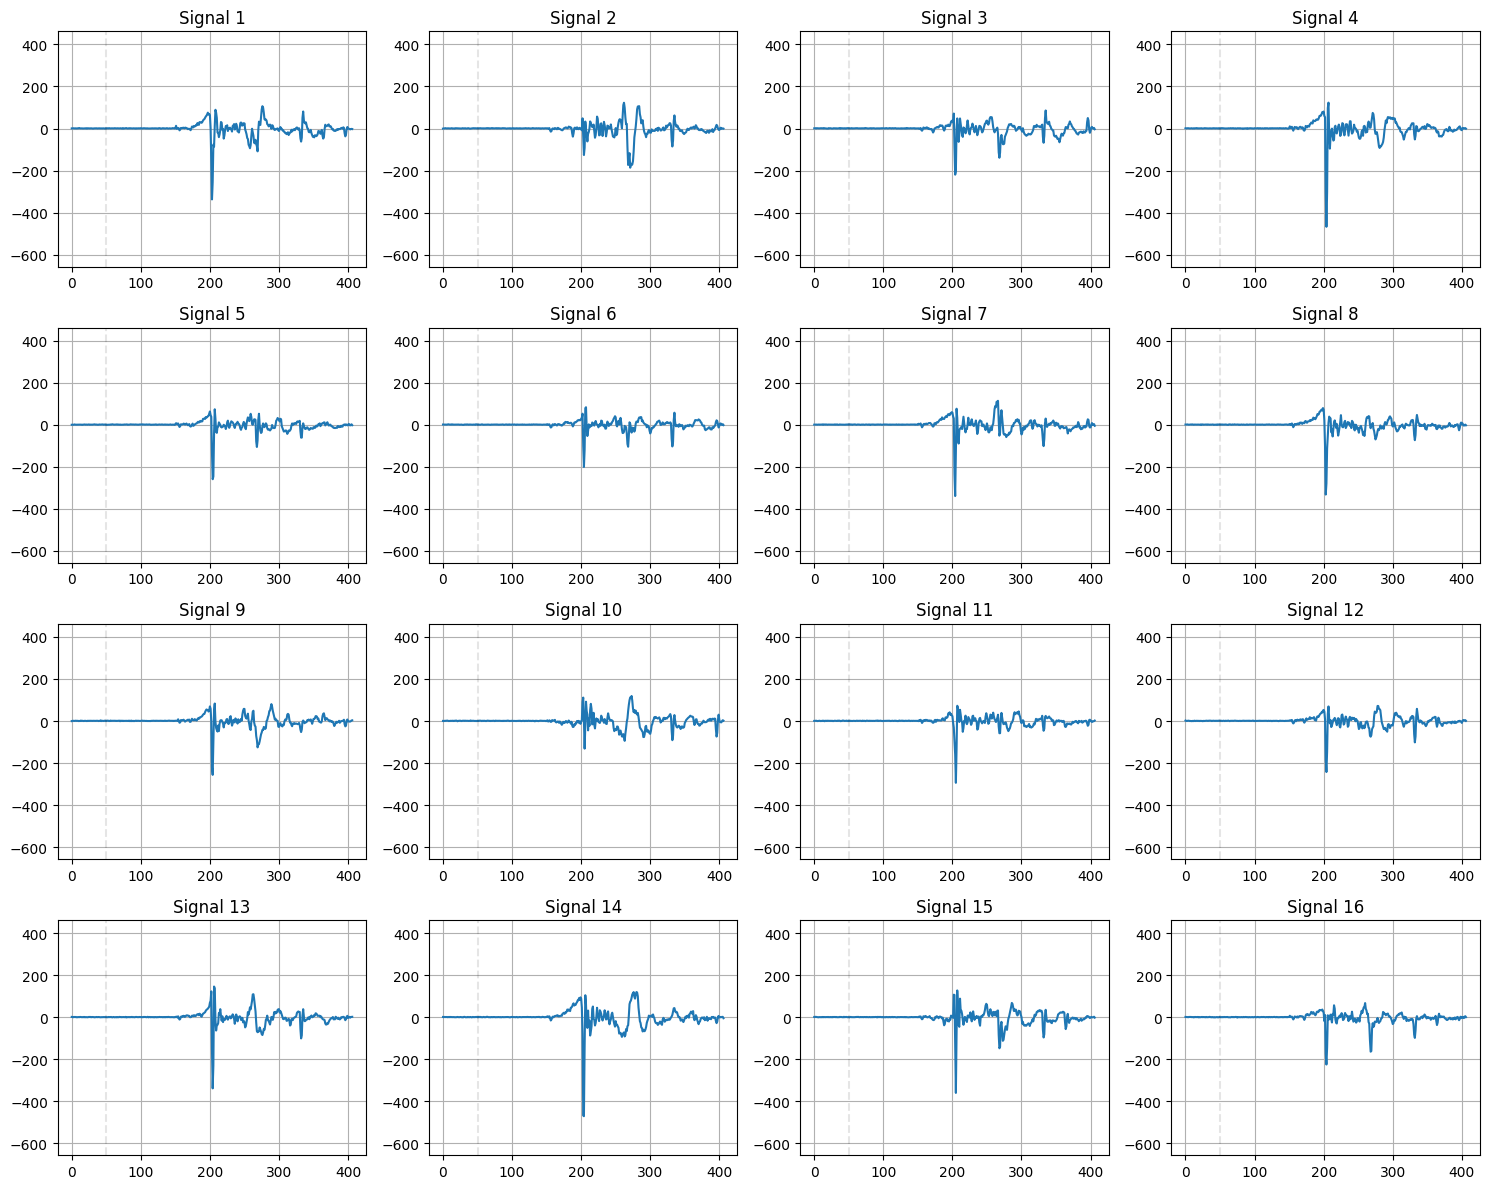

[12/32][0/188]	Loss_D: 0.6738	Loss_G: 1.7515	D(x): 0.8308	D(G(z)): 0.2055 / 0.2532
[12/32][50/188]	Loss_D: 0.5696	Loss_G: 2.0594	D(x): 0.8964	D(G(z)): 0.2052 / 0.2147
[12/32][100/188]	Loss_D: 0.7750	Loss_G: 1.4914	D(x): 0.8219	D(G(z)): 0.2319 / 0.2895
[12/32][150/188]	Loss_D: 0.7086	Loss_G: 1.5222	D(x): 0.8265	D(G(z)): 0.2058 / 0.2956
Epoch 12: SGD Discriminator lr 0.0000160 -> 0.0000157
Epoch 12: SGD Generator lr 0.0000160 -> 0.0000157


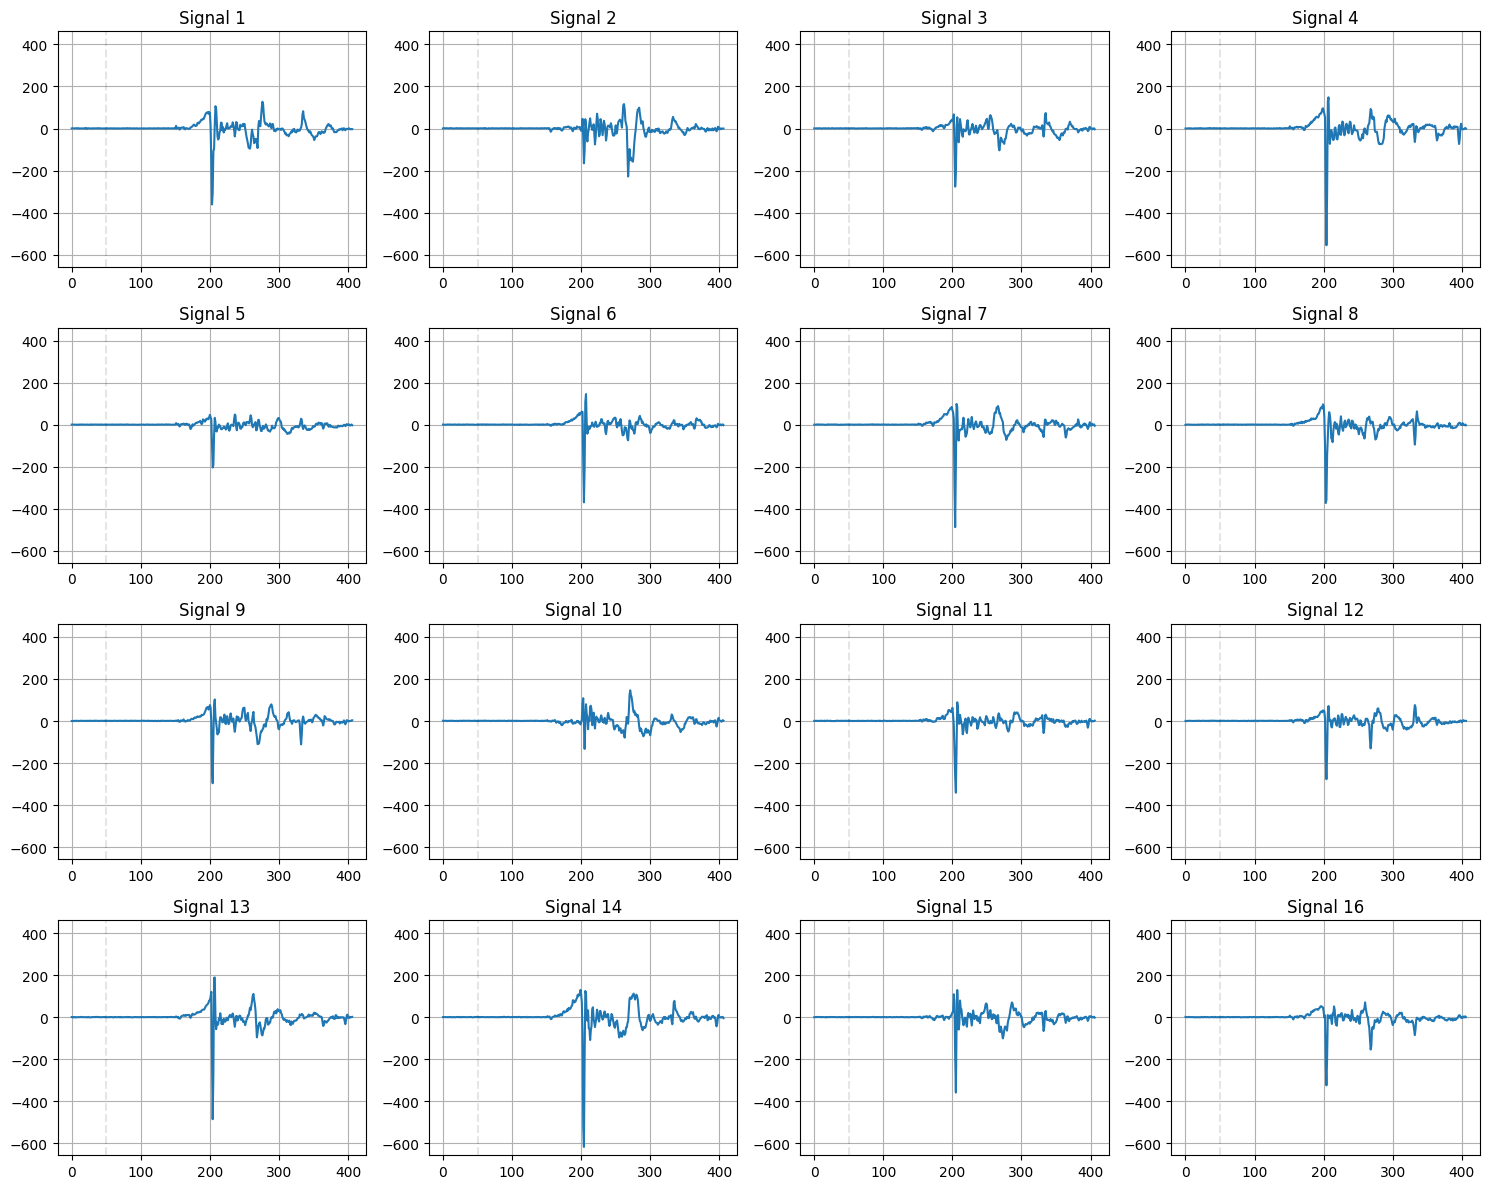

[13/32][0/188]	Loss_D: 0.5818	Loss_G: 1.8474	D(x): 0.9140	D(G(z)): 0.2616 / 0.2201
[13/32][50/188]	Loss_D: 0.6908	Loss_G: 1.5628	D(x): 0.8498	D(G(z)): 0.2825 / 0.2666
[13/32][100/188]	Loss_D: 0.6797	Loss_G: 1.8845	D(x): 0.8499	D(G(z)): 0.1970 / 0.2371
[13/32][150/188]	Loss_D: 0.7476	Loss_G: 1.8255	D(x): 0.8481	D(G(z)): 0.2464 / 0.2606
Epoch 13: SGD Discriminator lr 0.0000157 -> 0.0000153
Epoch 13: SGD Generator lr 0.0000157 -> 0.0000153


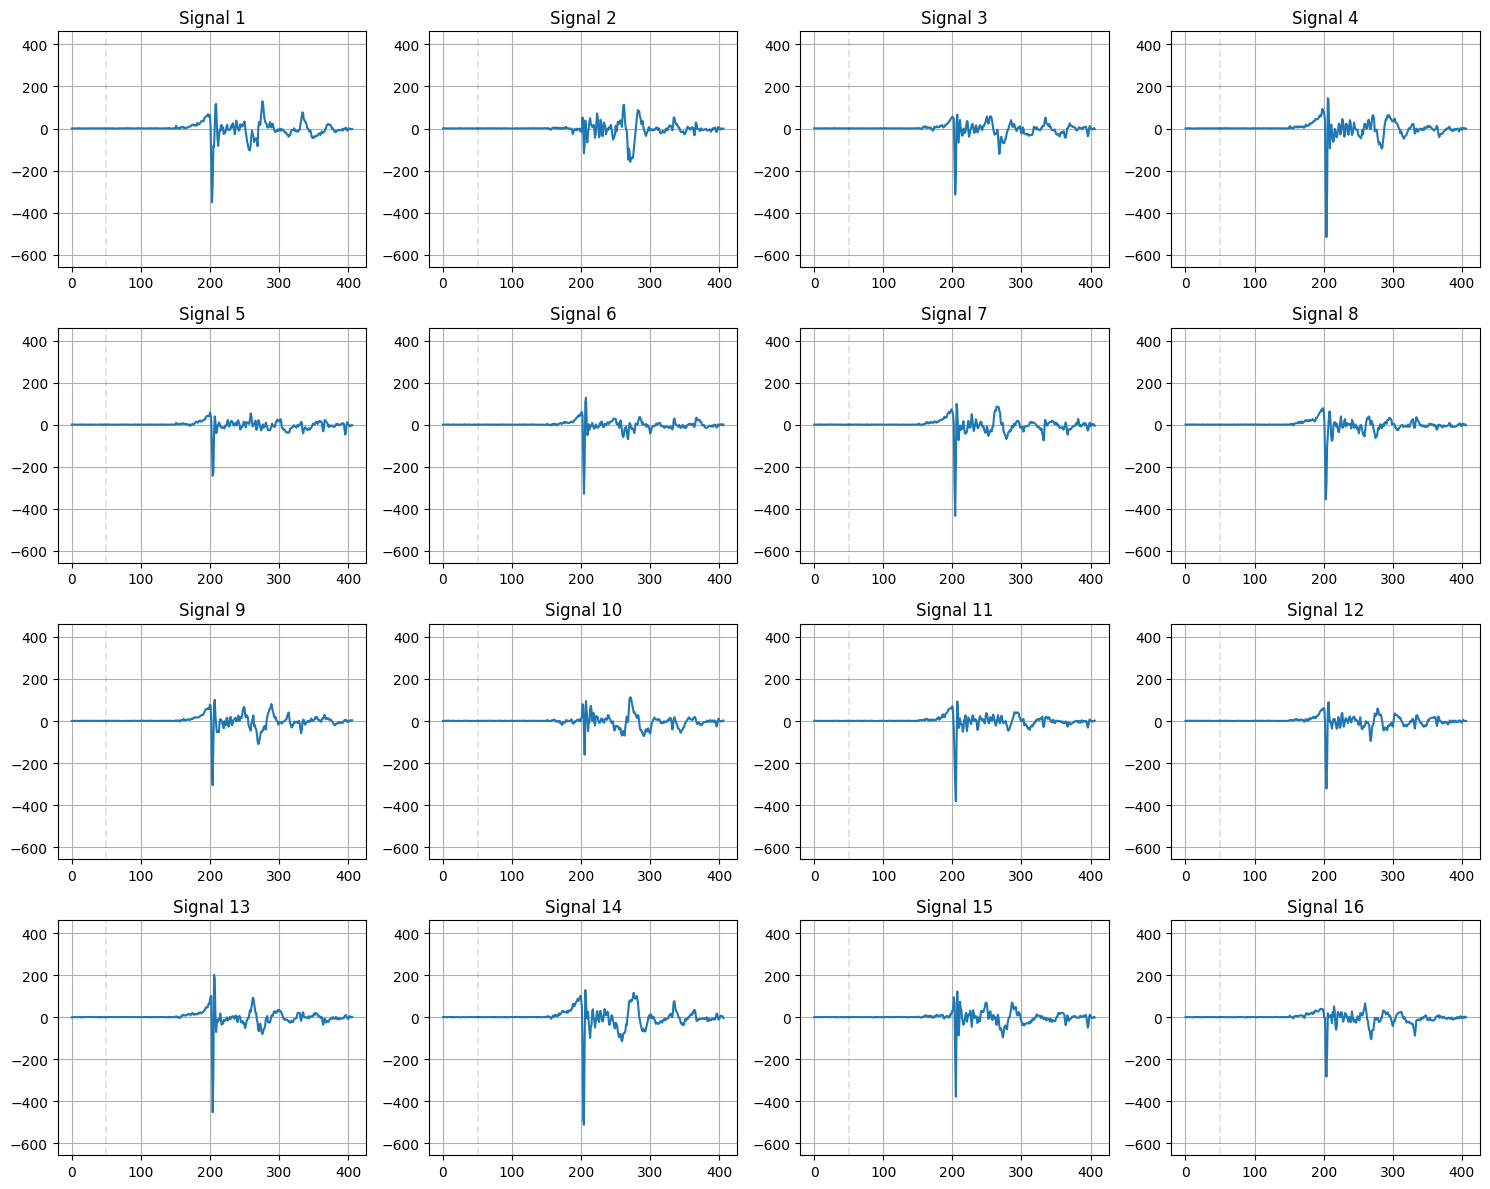

[14/32][0/188]	Loss_D: 0.7078	Loss_G: 2.3629	D(x): 0.8622	D(G(z)): 0.2204 / 0.1844
[14/32][50/188]	Loss_D: 0.6814	Loss_G: 1.7660	D(x): 0.8786	D(G(z)): 0.2812 / 0.2669
[14/32][100/188]	Loss_D: 0.7998	Loss_G: 1.5991	D(x): 0.8116	D(G(z)): 0.3026 / 0.2778
[14/32][150/188]	Loss_D: 0.7275	Loss_G: 1.4624	D(x): 0.8307	D(G(z)): 0.2282 / 0.2960
Epoch 14: SGD Discriminator lr 0.0000153 -> 0.0000150
Epoch 14: SGD Generator lr 0.0000153 -> 0.0000150


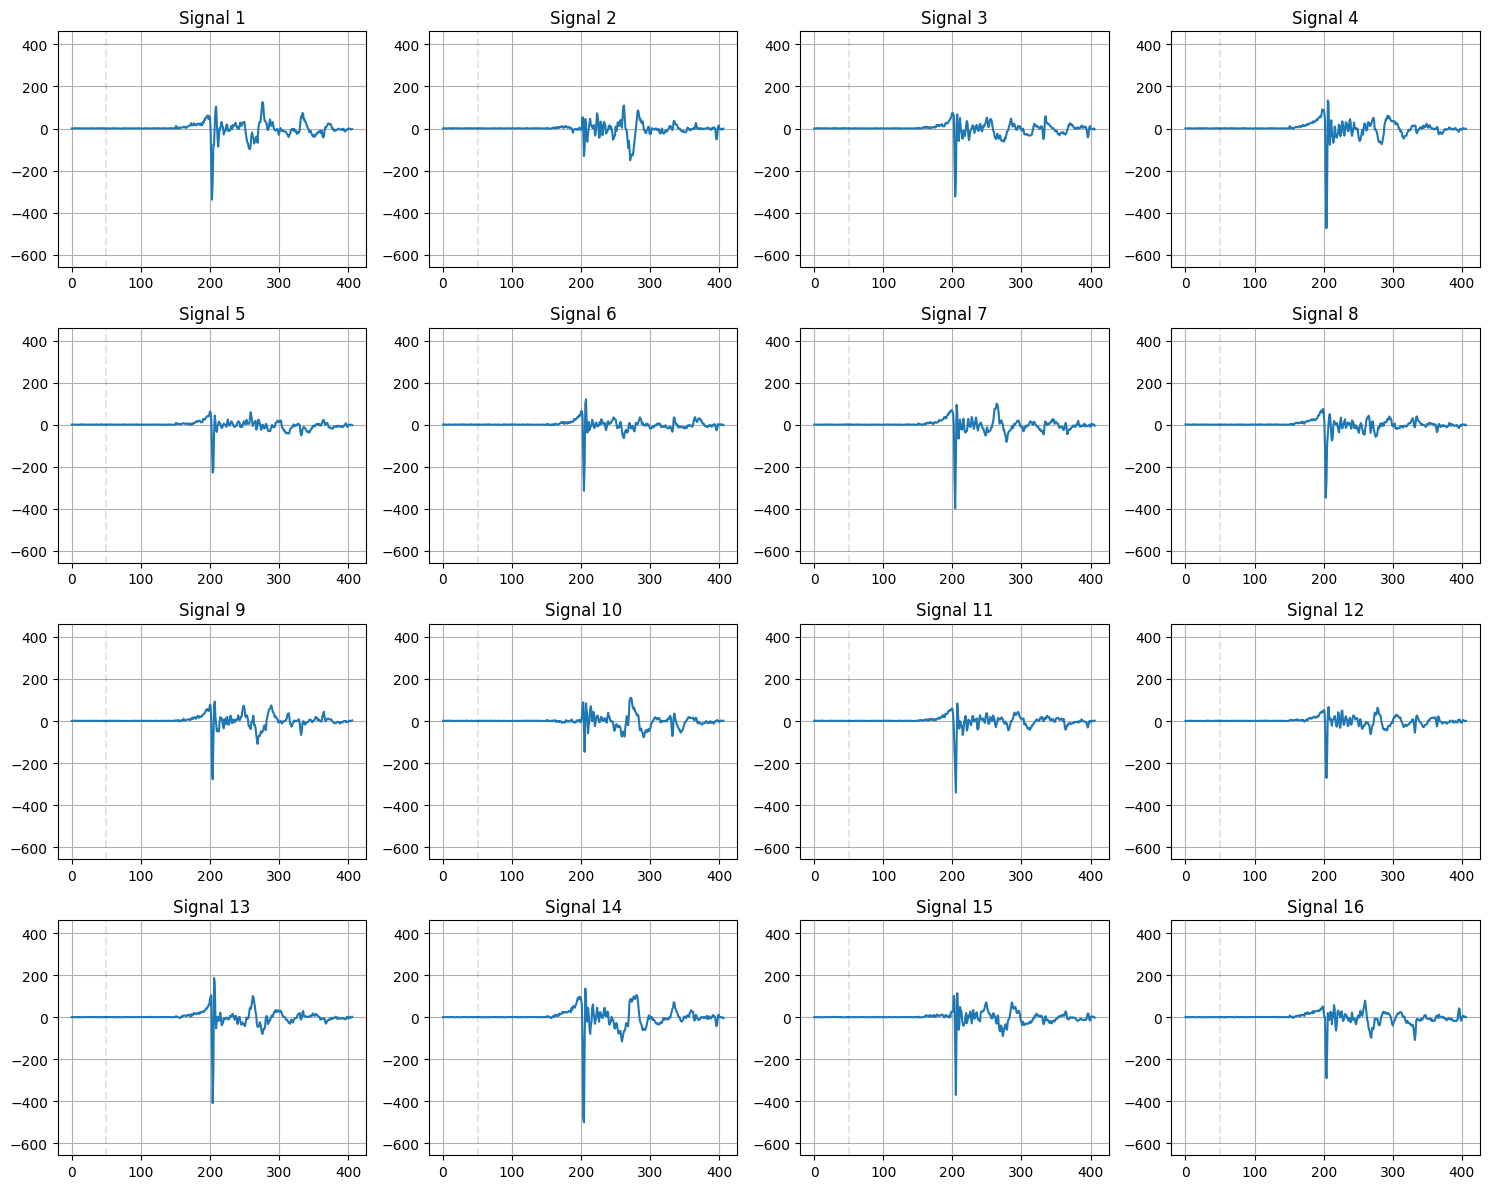

[15/32][0/188]	Loss_D: 0.6111	Loss_G: 1.7377	D(x): 0.8855	D(G(z)): 0.2403 / 0.2649
[15/32][50/188]	Loss_D: 0.7077	Loss_G: 1.9149	D(x): 0.8633	D(G(z)): 0.2025 / 0.2622
[15/32][100/188]	Loss_D: 0.6188	Loss_G: 2.0764	D(x): 0.8737	D(G(z)): 0.1832 / 0.1930
[15/32][150/188]	Loss_D: 0.7505	Loss_G: 1.6142	D(x): 0.8126	D(G(z)): 0.2852 / 0.2732
Epoch 15: SGD Discriminator lr 0.0000150 -> 0.0000147
Epoch 15: SGD Generator lr 0.0000150 -> 0.0000147


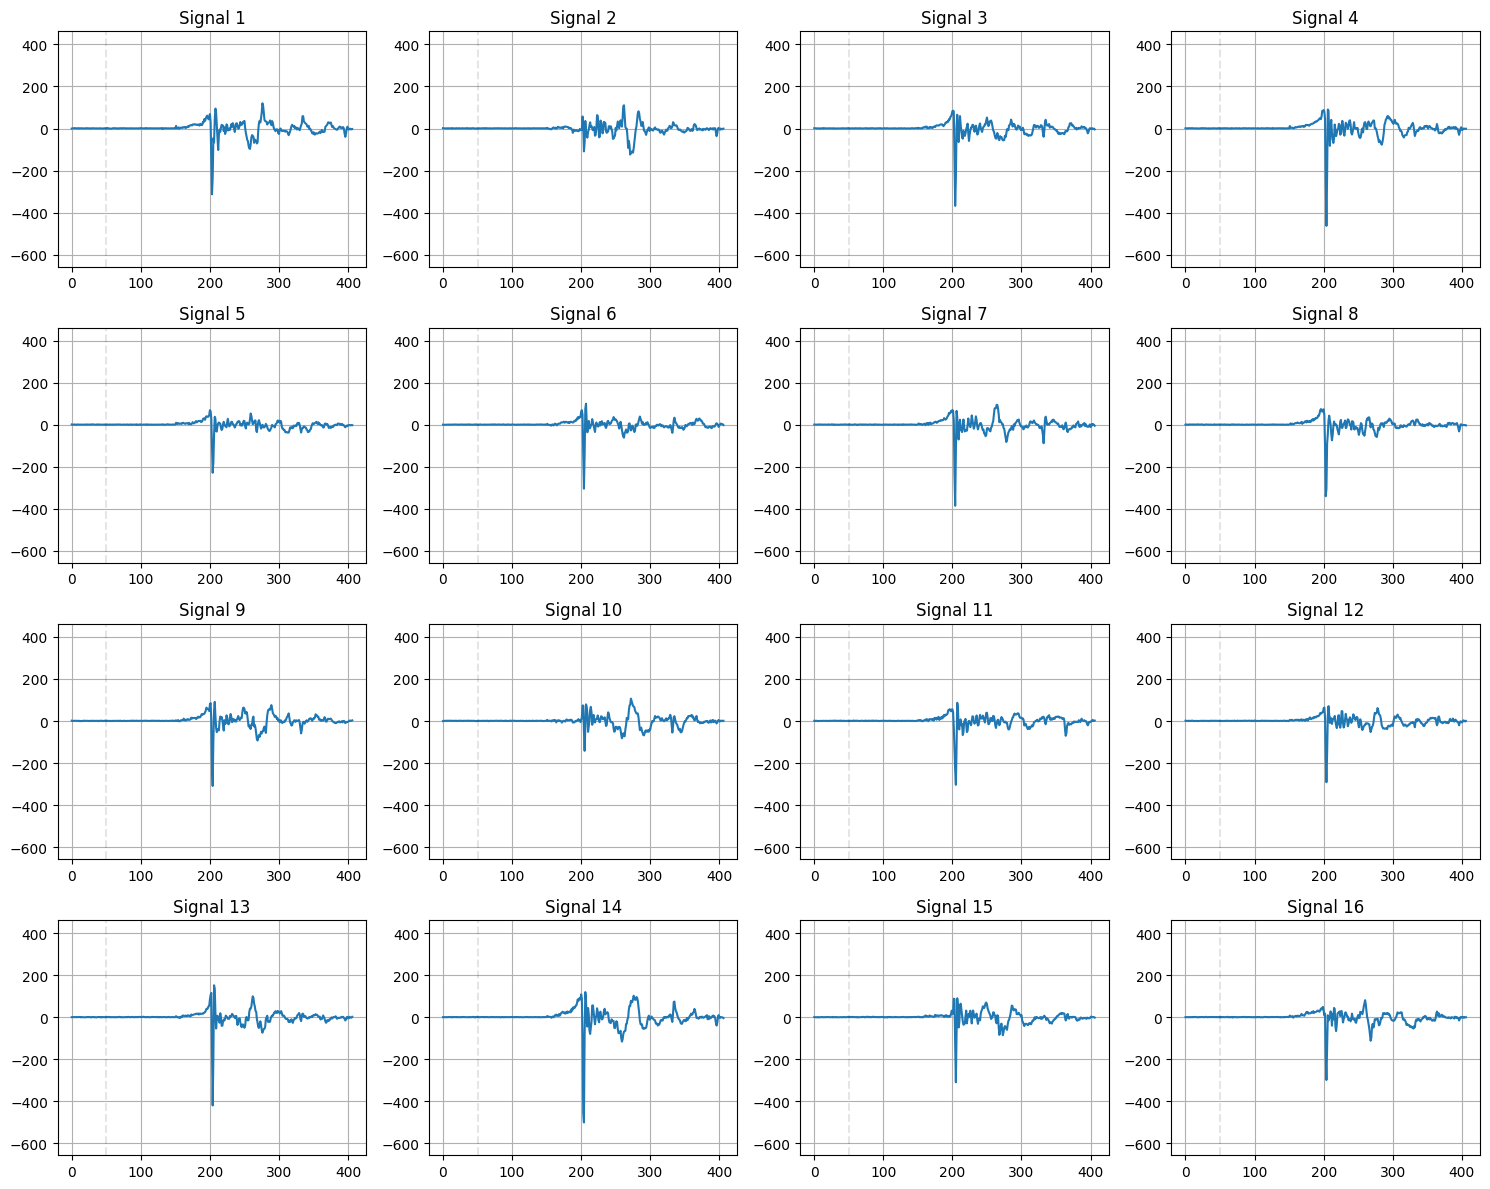

[16/32][0/188]	Loss_D: 0.7121	Loss_G: 1.7988	D(x): 0.8341	D(G(z)): 0.2521 / 0.2571
[16/32][50/188]	Loss_D: 0.7120	Loss_G: 1.9001	D(x): 0.8151	D(G(z)): 0.1960 / 0.2607
[16/32][100/188]	Loss_D: 0.7921	Loss_G: 1.8779	D(x): 0.7956	D(G(z)): 0.2849 / 0.2153
[16/32][150/188]	Loss_D: 0.6497	Loss_G: 1.9835	D(x): 0.8549	D(G(z)): 0.1862 / 0.2235
Epoch 16: SGD Discriminator lr 0.0000147 -> 0.0000143
Epoch 16: SGD Generator lr 0.0000147 -> 0.0000143


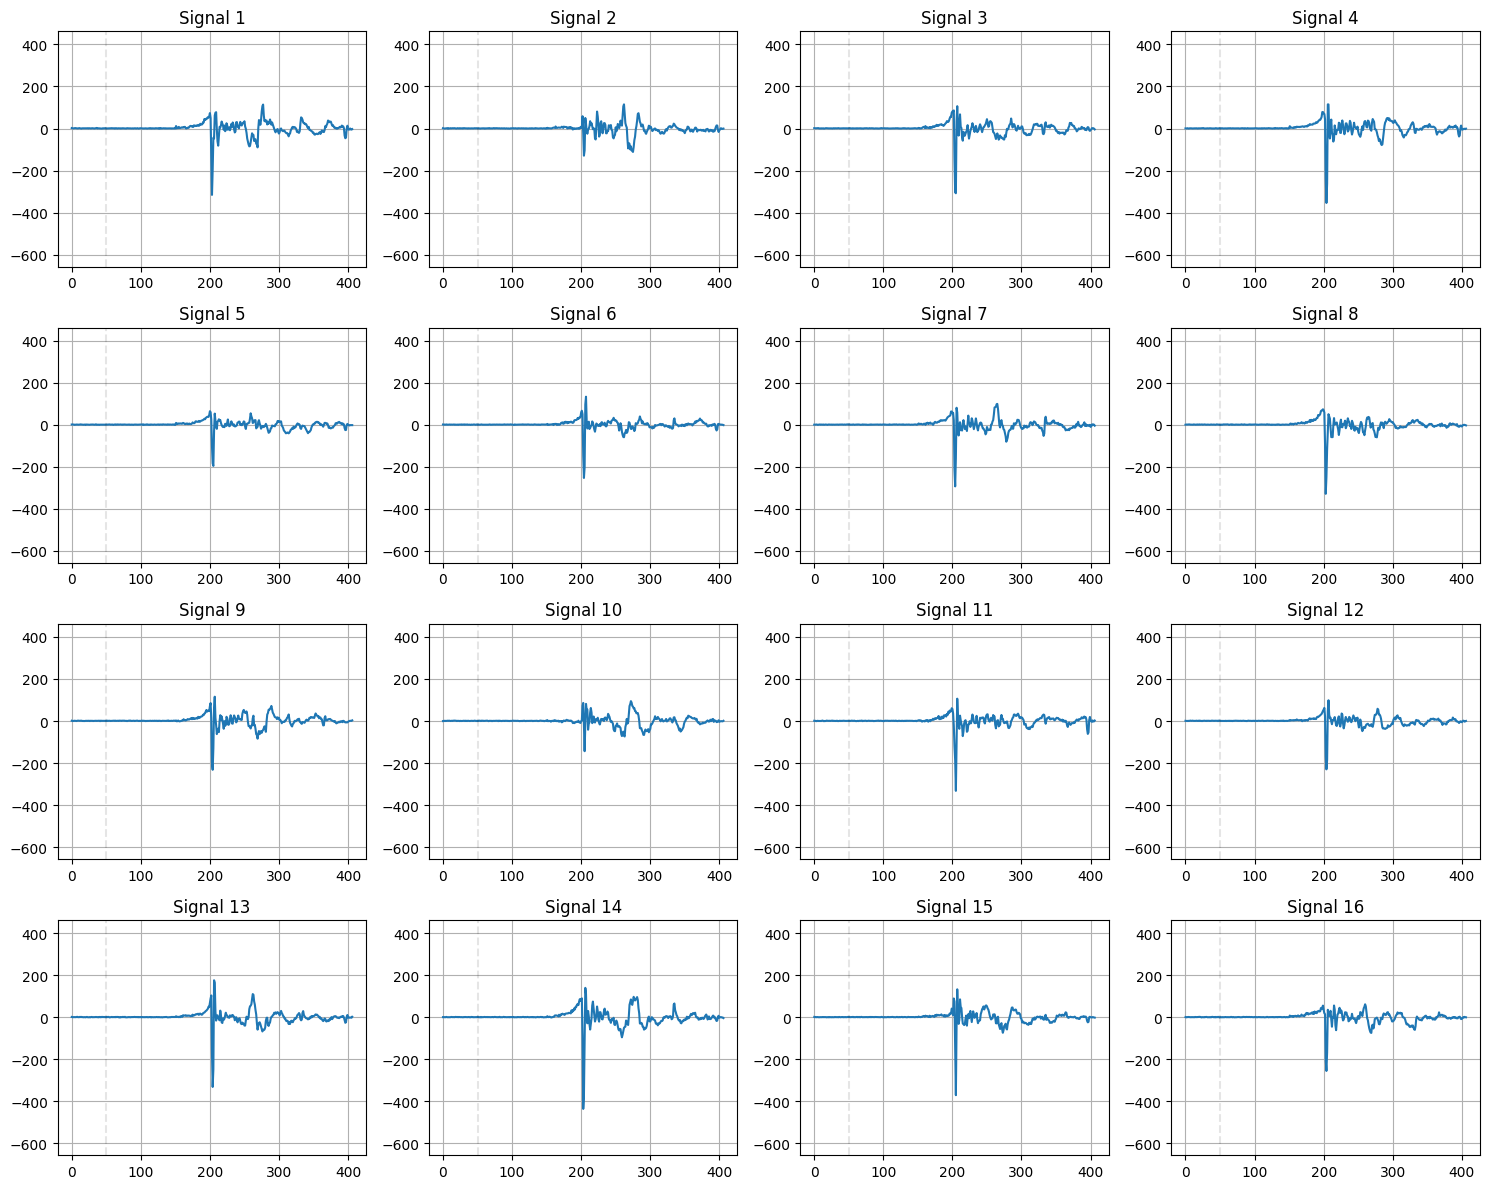

[17/32][0/188]	Loss_D: 0.6932	Loss_G: 1.7678	D(x): 0.8495	D(G(z)): 0.2245 / 0.2241
[17/32][50/188]	Loss_D: 0.6764	Loss_G: 1.5828	D(x): 0.8740	D(G(z)): 0.1777 / 0.2673
[17/32][100/188]	Loss_D: 0.6886	Loss_G: 1.9938	D(x): 0.8518	D(G(z)): 0.1751 / 0.2329
[17/32][150/188]	Loss_D: 0.7038	Loss_G: 1.2790	D(x): 0.8641	D(G(z)): 0.2980 / 0.3428
Epoch 17: SGD Discriminator lr 0.0000143 -> 0.0000140
Epoch 17: SGD Generator lr 0.0000143 -> 0.0000140


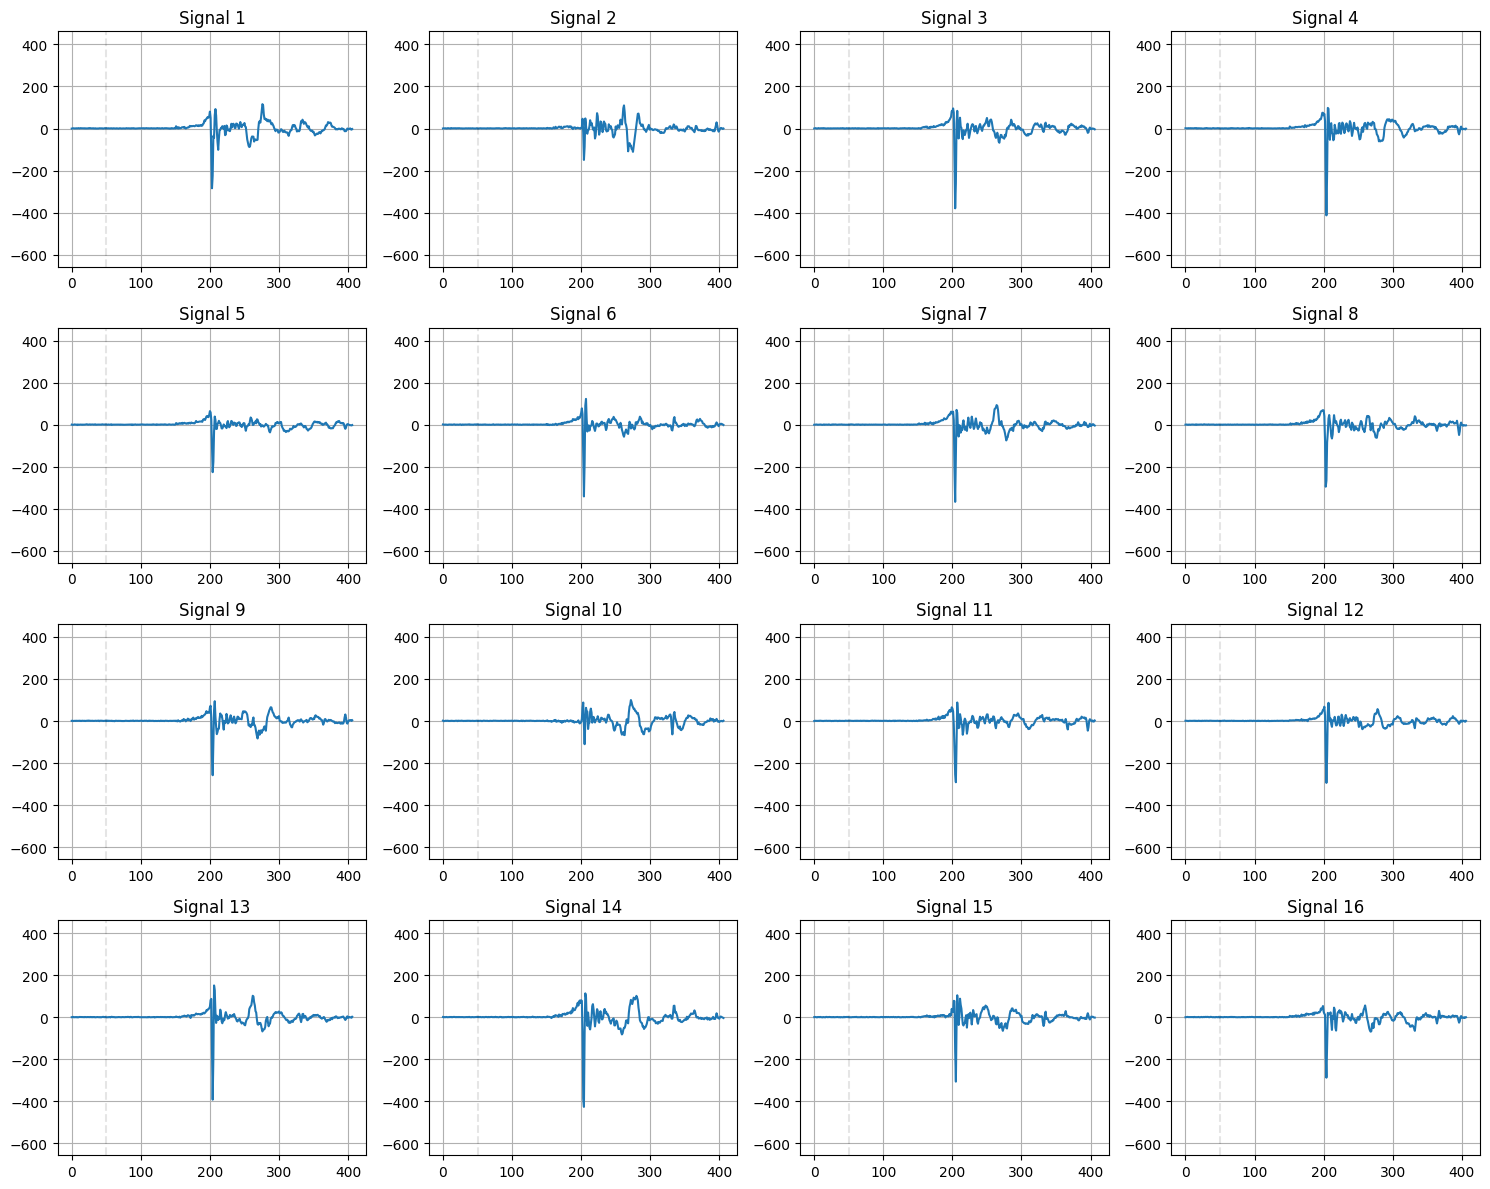

[18/32][0/188]	Loss_D: 0.8062	Loss_G: 1.1520	D(x): 0.8094	D(G(z)): 0.3542 / 0.3841
[18/32][50/188]	Loss_D: 0.6554	Loss_G: 1.6006	D(x): 0.8575	D(G(z)): 0.2653 / 0.2573
[18/32][100/188]	Loss_D: 0.6385	Loss_G: 1.4783	D(x): 0.8845	D(G(z)): 0.3188 / 0.2881
[18/32][150/188]	Loss_D: 0.6804	Loss_G: 1.7277	D(x): 0.8549	D(G(z)): 0.2278 / 0.2456
Epoch 18: SGD Discriminator lr 0.0000140 -> 0.0000137
Epoch 18: SGD Generator lr 0.0000140 -> 0.0000137


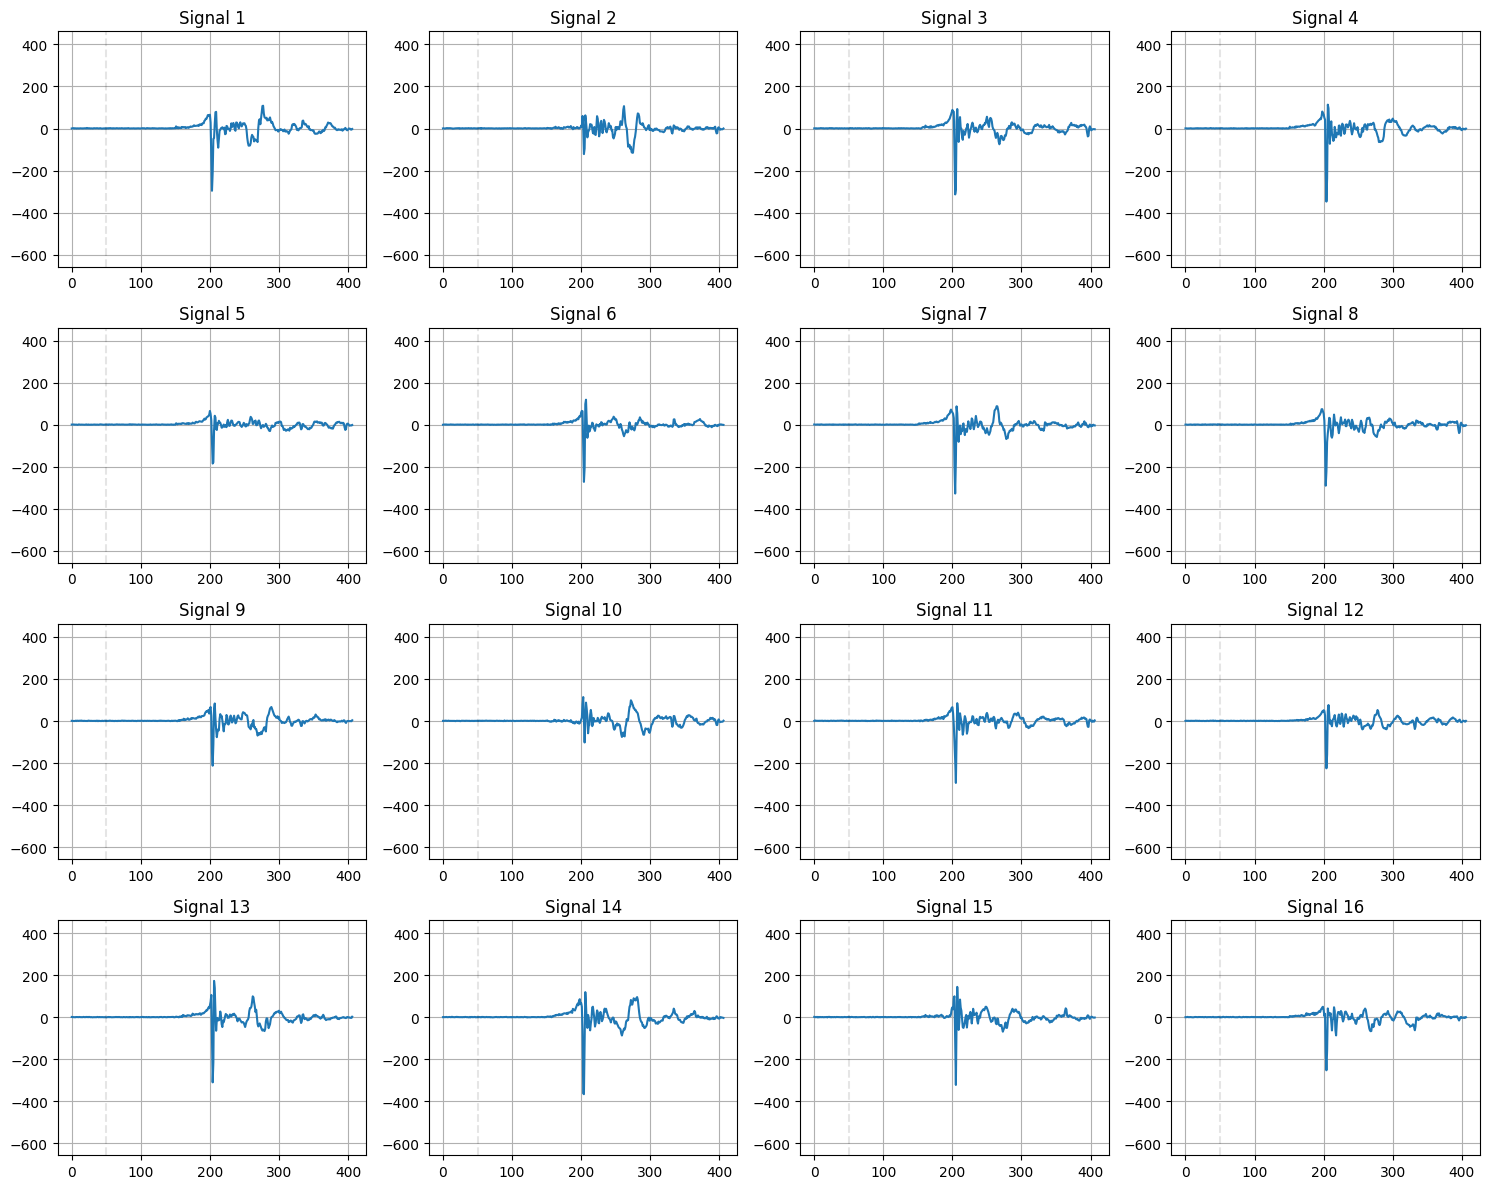

[19/32][0/188]	Loss_D: 0.7110	Loss_G: 1.7510	D(x): 0.8409	D(G(z)): 0.2391 / 0.2515
[19/32][50/188]	Loss_D: 0.5770	Loss_G: 1.2202	D(x): 0.9242	D(G(z)): 0.2925 / 0.3573
[19/32][100/188]	Loss_D: 0.8047	Loss_G: 1.4748	D(x): 0.7669	D(G(z)): 0.2513 / 0.3013
[19/32][150/188]	Loss_D: 0.6538	Loss_G: 1.5622	D(x): 0.9130	D(G(z)): 0.2837 / 0.3010
Epoch 19: SGD Discriminator lr 0.0000137 -> 0.0000133
Epoch 19: SGD Generator lr 0.0000137 -> 0.0000133


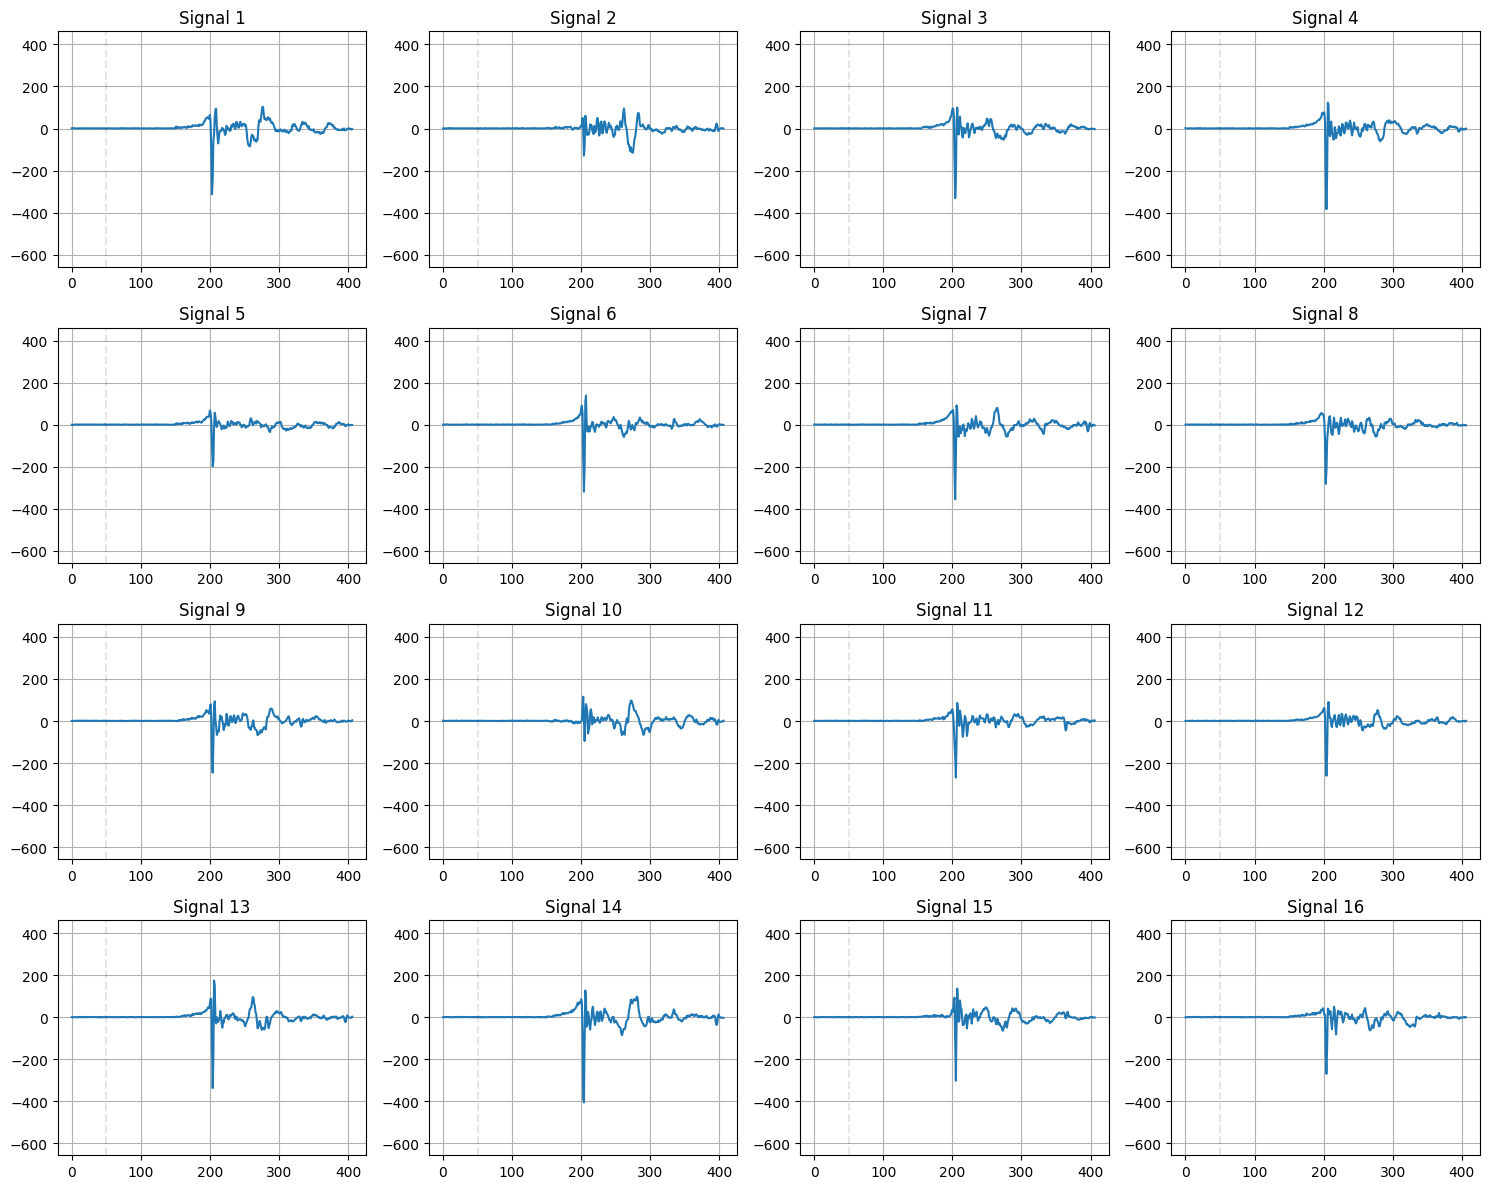

[20/32][0/188]	Loss_D: 0.7262	Loss_G: 1.6078	D(x): 0.8334	D(G(z)): 0.2490 / 0.2862
[20/32][50/188]	Loss_D: 0.8150	Loss_G: 1.7278	D(x): 0.7832	D(G(z)): 0.1562 / 0.2598
[20/32][100/188]	Loss_D: 0.6376	Loss_G: 1.8115	D(x): 0.8440	D(G(z)): 0.2129 / 0.2323
[20/32][150/188]	Loss_D: 0.7407	Loss_G: 1.5713	D(x): 0.8270	D(G(z)): 0.2342 / 0.2761
Epoch 20: SGD Discriminator lr 0.0000133 -> 0.0000130
Epoch 20: SGD Generator lr 0.0000133 -> 0.0000130


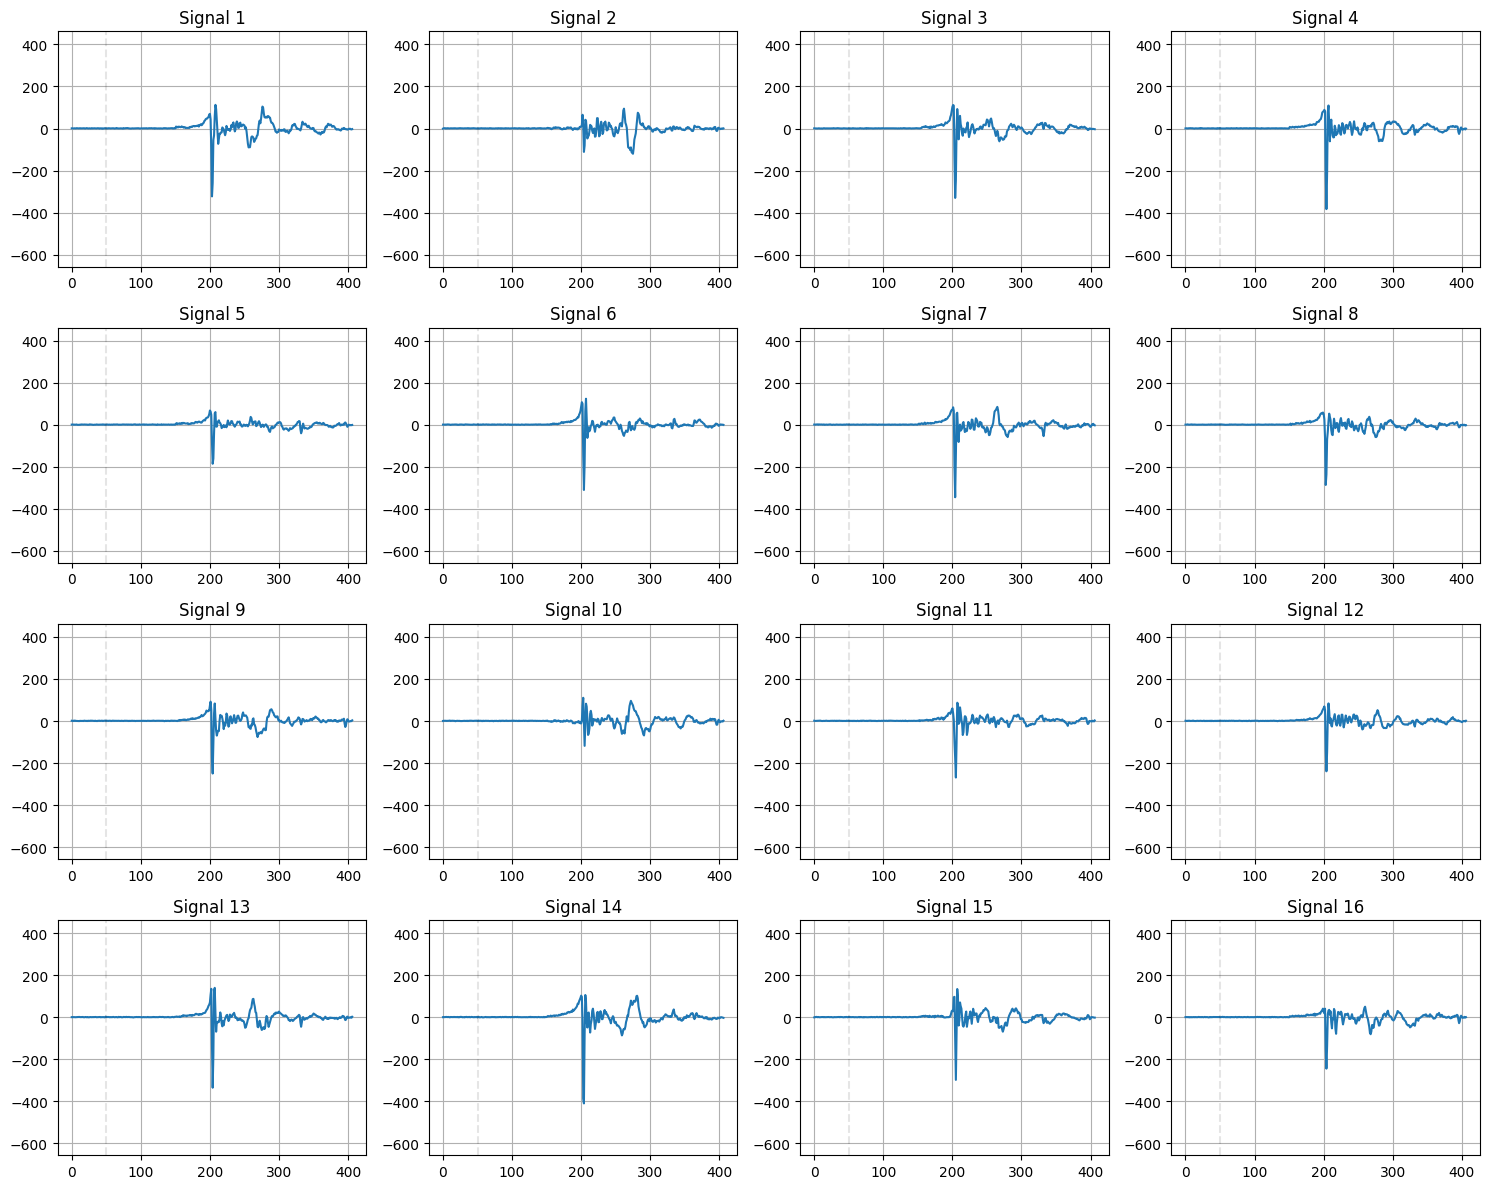

[21/32][0/188]	Loss_D: 0.7563	Loss_G: 2.0112	D(x): 0.8179	D(G(z)): 0.2602 / 0.2297
[21/32][50/188]	Loss_D: 0.6691	Loss_G: 1.5408	D(x): 0.8830	D(G(z)): 0.2602 / 0.3009
[21/32][100/188]	Loss_D: 0.6602	Loss_G: 1.3821	D(x): 0.8810	D(G(z)): 0.2698 / 0.3299
[21/32][150/188]	Loss_D: 0.6705	Loss_G: 1.7825	D(x): 0.8652	D(G(z)): 0.2199 / 0.2545
Epoch 21: SGD Discriminator lr 0.0000130 -> 0.0000127
Epoch 21: SGD Generator lr 0.0000130 -> 0.0000127


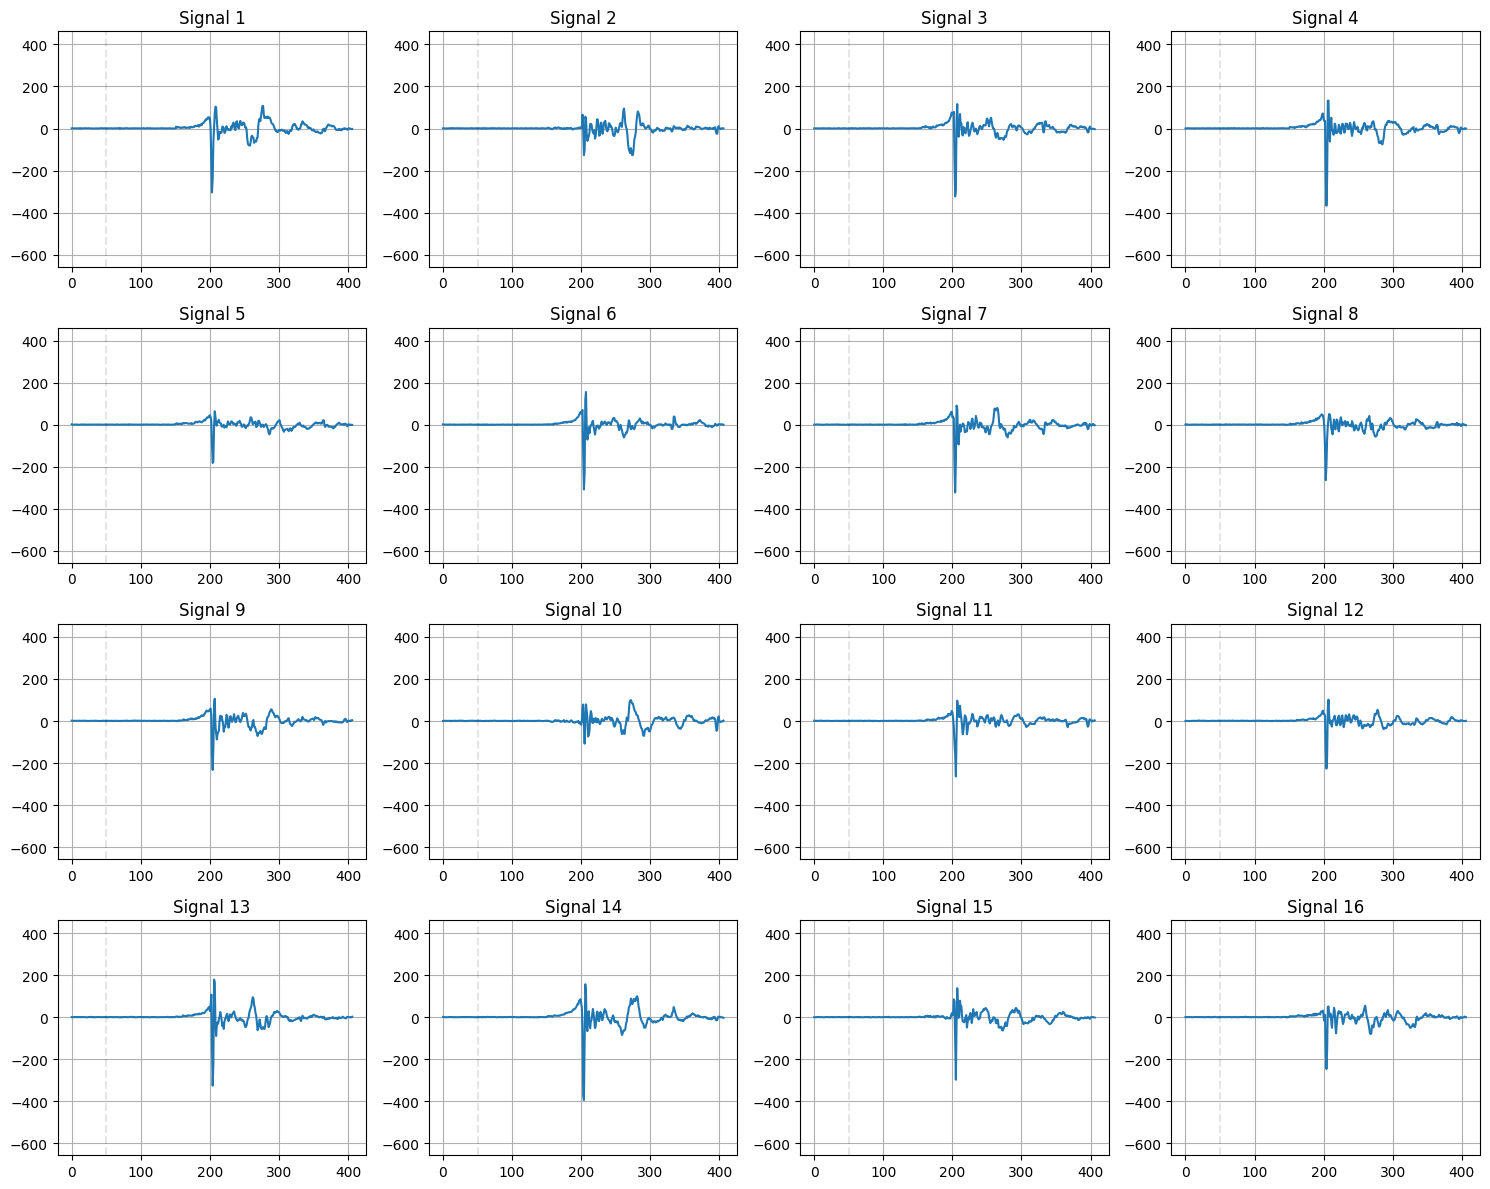

[22/32][0/188]	Loss_D: 0.7214	Loss_G: 1.6529	D(x): 0.8585	D(G(z)): 0.2421 / 0.2876
[22/32][50/188]	Loss_D: 0.7093	Loss_G: 1.6614	D(x): 0.8294	D(G(z)): 0.2678 / 0.2734
[22/32][100/188]	Loss_D: 0.7735	Loss_G: 1.5871	D(x): 0.8286	D(G(z)): 0.2988 / 0.2904
[22/32][150/188]	Loss_D: 0.7870	Loss_G: 1.6688	D(x): 0.8007	D(G(z)): 0.2756 / 0.2726
Epoch 22: SGD Discriminator lr 0.0000127 -> 0.0000123
Epoch 22: SGD Generator lr 0.0000127 -> 0.0000123


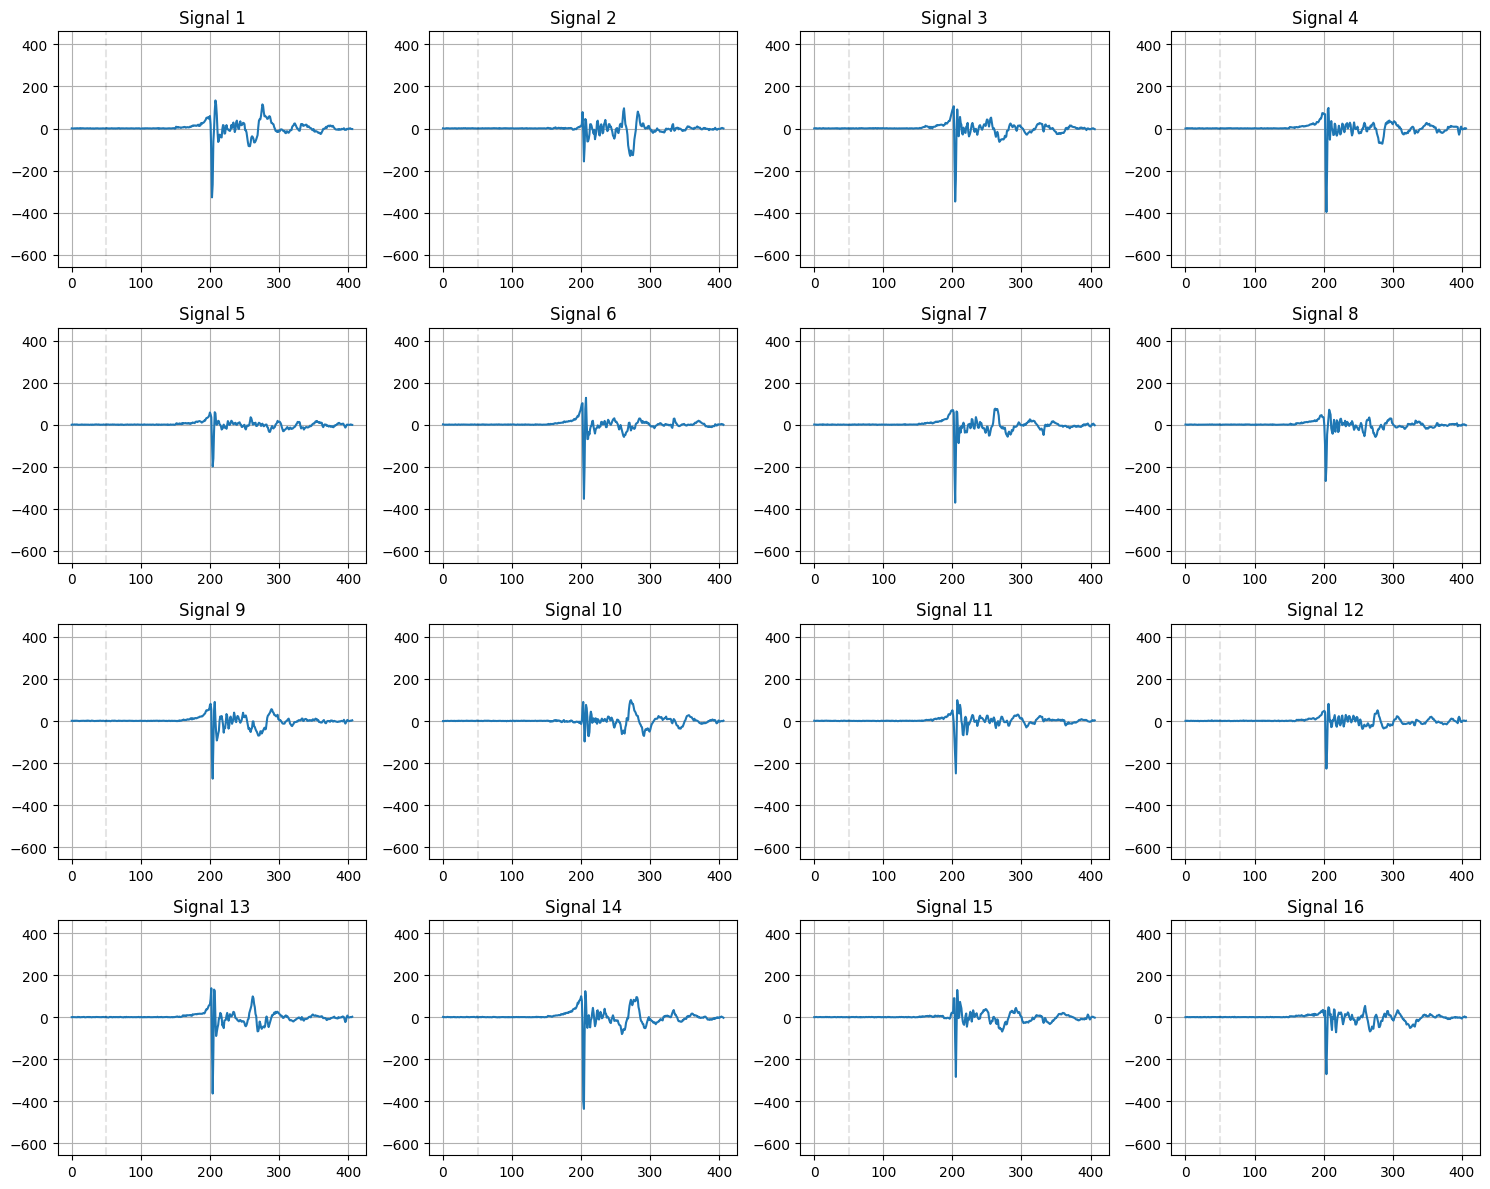

[23/32][0/188]	Loss_D: 0.6167	Loss_G: 1.8309	D(x): 0.8728	D(G(z)): 0.1786 / 0.2529
[23/32][50/188]	Loss_D: 0.6736	Loss_G: 2.0798	D(x): 0.8311	D(G(z)): 0.1956 / 0.1930
[23/32][100/188]	Loss_D: 0.6982	Loss_G: 1.4908	D(x): 0.8602	D(G(z)): 0.2955 / 0.2868
[23/32][150/188]	Loss_D: 0.6146	Loss_G: 1.6605	D(x): 0.8685	D(G(z)): 0.2003 / 0.2394
Epoch 23: SGD Discriminator lr 0.0000123 -> 0.0000120
Epoch 23: SGD Generator lr 0.0000123 -> 0.0000120


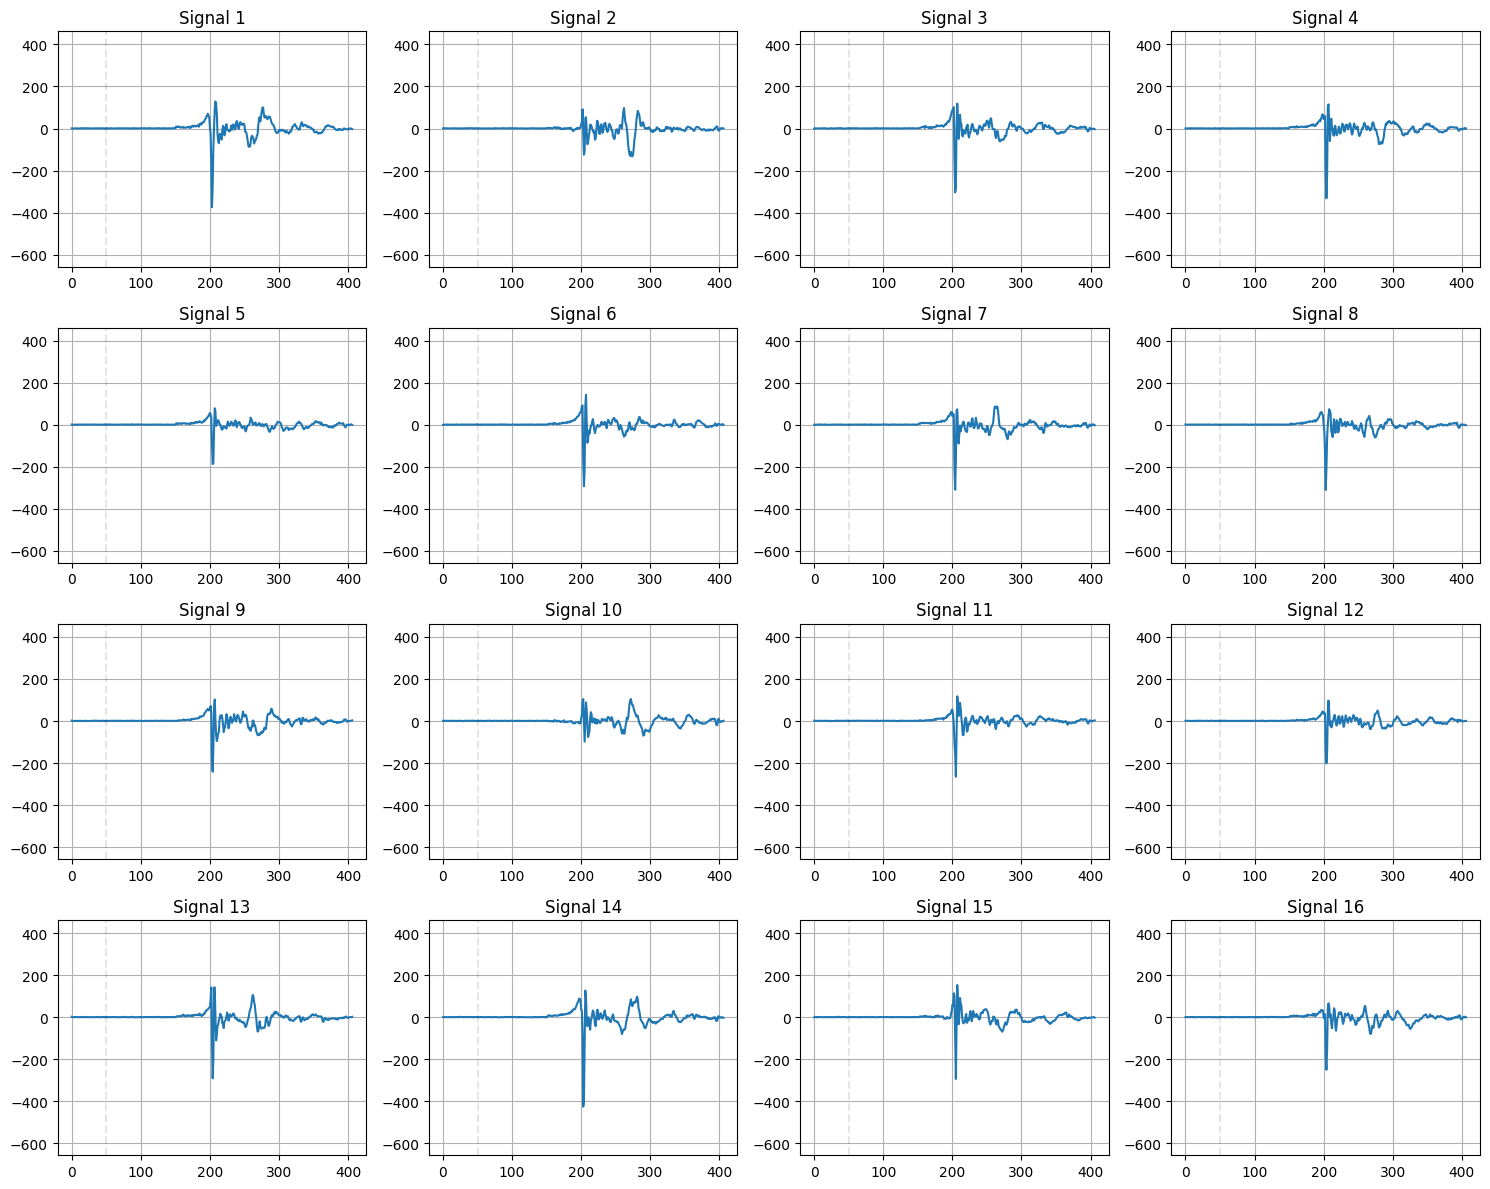

[24/32][0/188]	Loss_D: 0.7455	Loss_G: 1.3846	D(x): 0.8049	D(G(z)): 0.2930 / 0.3210
[24/32][50/188]	Loss_D: 0.6899	Loss_G: 2.6063	D(x): 0.8720	D(G(z)): 0.2284 / 0.1259
[24/32][100/188]	Loss_D: 0.7268	Loss_G: 1.7943	D(x): 0.8630	D(G(z)): 0.3052 / 0.2522
[24/32][150/188]	Loss_D: 0.7694	Loss_G: 1.9251	D(x): 0.8271	D(G(z)): 0.2767 / 0.2404
Epoch 24: SGD Discriminator lr 0.0000120 -> 0.0000117
Epoch 24: SGD Generator lr 0.0000120 -> 0.0000117


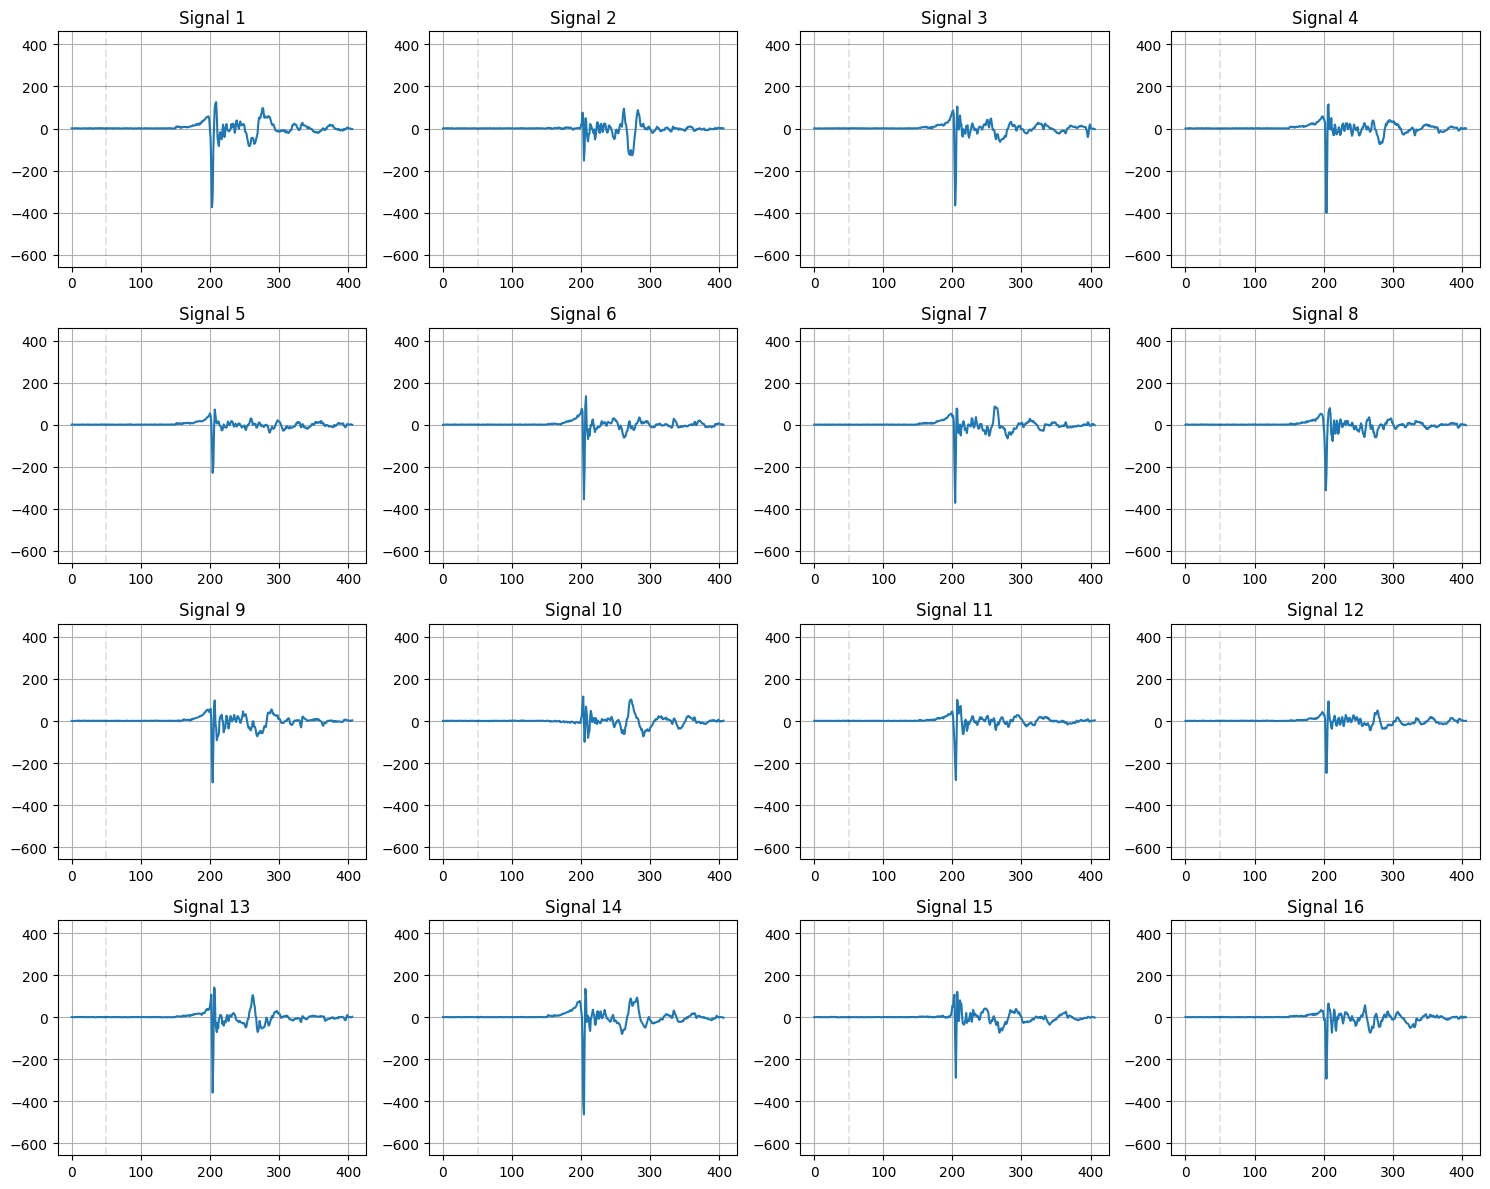

[25/32][0/188]	Loss_D: 0.6050	Loss_G: 2.3558	D(x): 0.8215	D(G(z)): 0.1272 / 0.1935
[25/32][50/188]	Loss_D: 0.7585	Loss_G: 1.4443	D(x): 0.8355	D(G(z)): 0.2900 / 0.3133
[25/32][100/188]	Loss_D: 0.5691	Loss_G: 1.5321	D(x): 0.8830	D(G(z)): 0.2163 / 0.3127
[25/32][150/188]	Loss_D: 0.5524	Loss_G: 2.0072	D(x): 0.9134	D(G(z)): 0.2064 / 0.1853
Epoch 25: SGD Discriminator lr 0.0000117 -> 0.0000113
Epoch 25: SGD Generator lr 0.0000117 -> 0.0000113


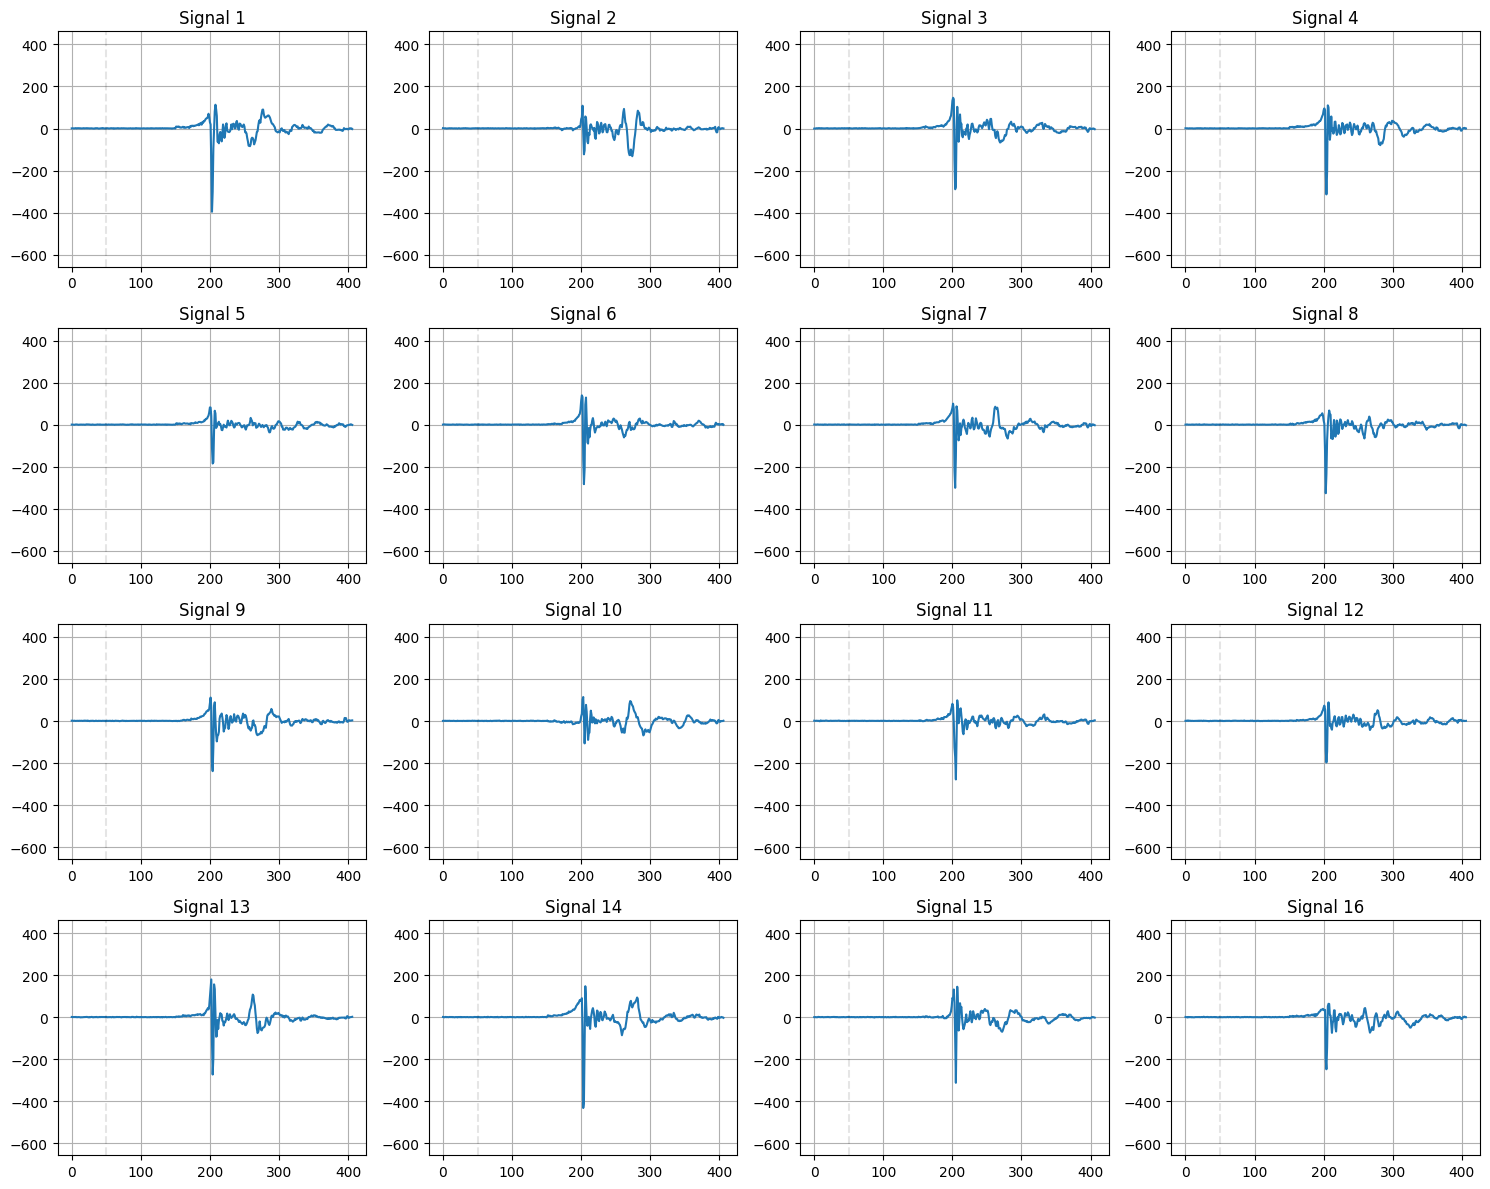

[26/32][0/188]	Loss_D: 0.6459	Loss_G: 1.7949	D(x): 0.8745	D(G(z)): 0.1885 / 0.2678
[26/32][50/188]	Loss_D: 0.7317	Loss_G: 2.0914	D(x): 0.8394	D(G(z)): 0.3003 / 0.2038
[26/32][100/188]	Loss_D: 0.6548	Loss_G: 1.7859	D(x): 0.8405	D(G(z)): 0.1728 / 0.2531
[26/32][150/188]	Loss_D: 0.7326	Loss_G: 1.9397	D(x): 0.8652	D(G(z)): 0.2897 / 0.2141
Epoch 26: SGD Discriminator lr 0.0000113 -> 0.0000110
Epoch 26: SGD Generator lr 0.0000113 -> 0.0000110


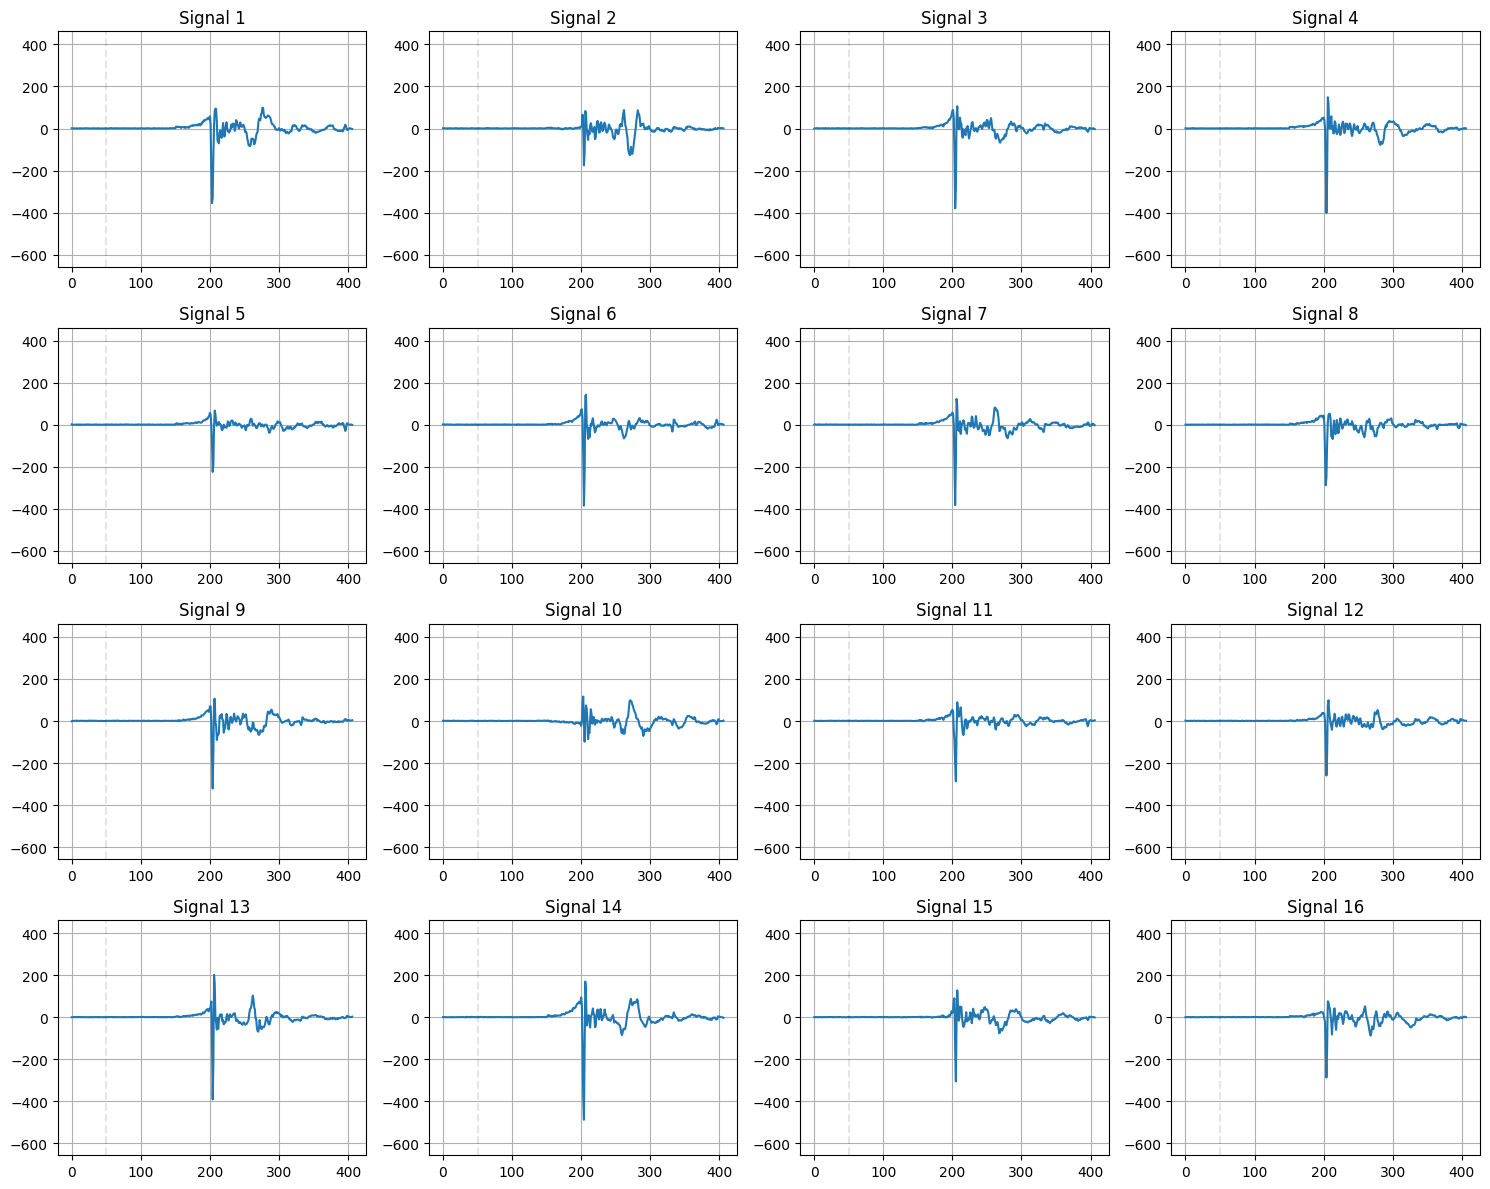

[27/32][0/188]	Loss_D: 0.6706	Loss_G: 1.9494	D(x): 0.8738	D(G(z)): 0.1533 / 0.2454
[27/32][50/188]	Loss_D: 0.8063	Loss_G: 1.7169	D(x): 0.8369	D(G(z)): 0.3395 / 0.2616
[27/32][100/188]	Loss_D: 0.8224	Loss_G: 1.8267	D(x): 0.7794	D(G(z)): 0.1996 / 0.2584
[27/32][150/188]	Loss_D: 0.5917	Loss_G: 2.3870	D(x): 0.8798	D(G(z)): 0.1594 / 0.2105
Epoch 27: SGD Discriminator lr 0.0000110 -> 0.0000107
Epoch 27: SGD Generator lr 0.0000110 -> 0.0000107


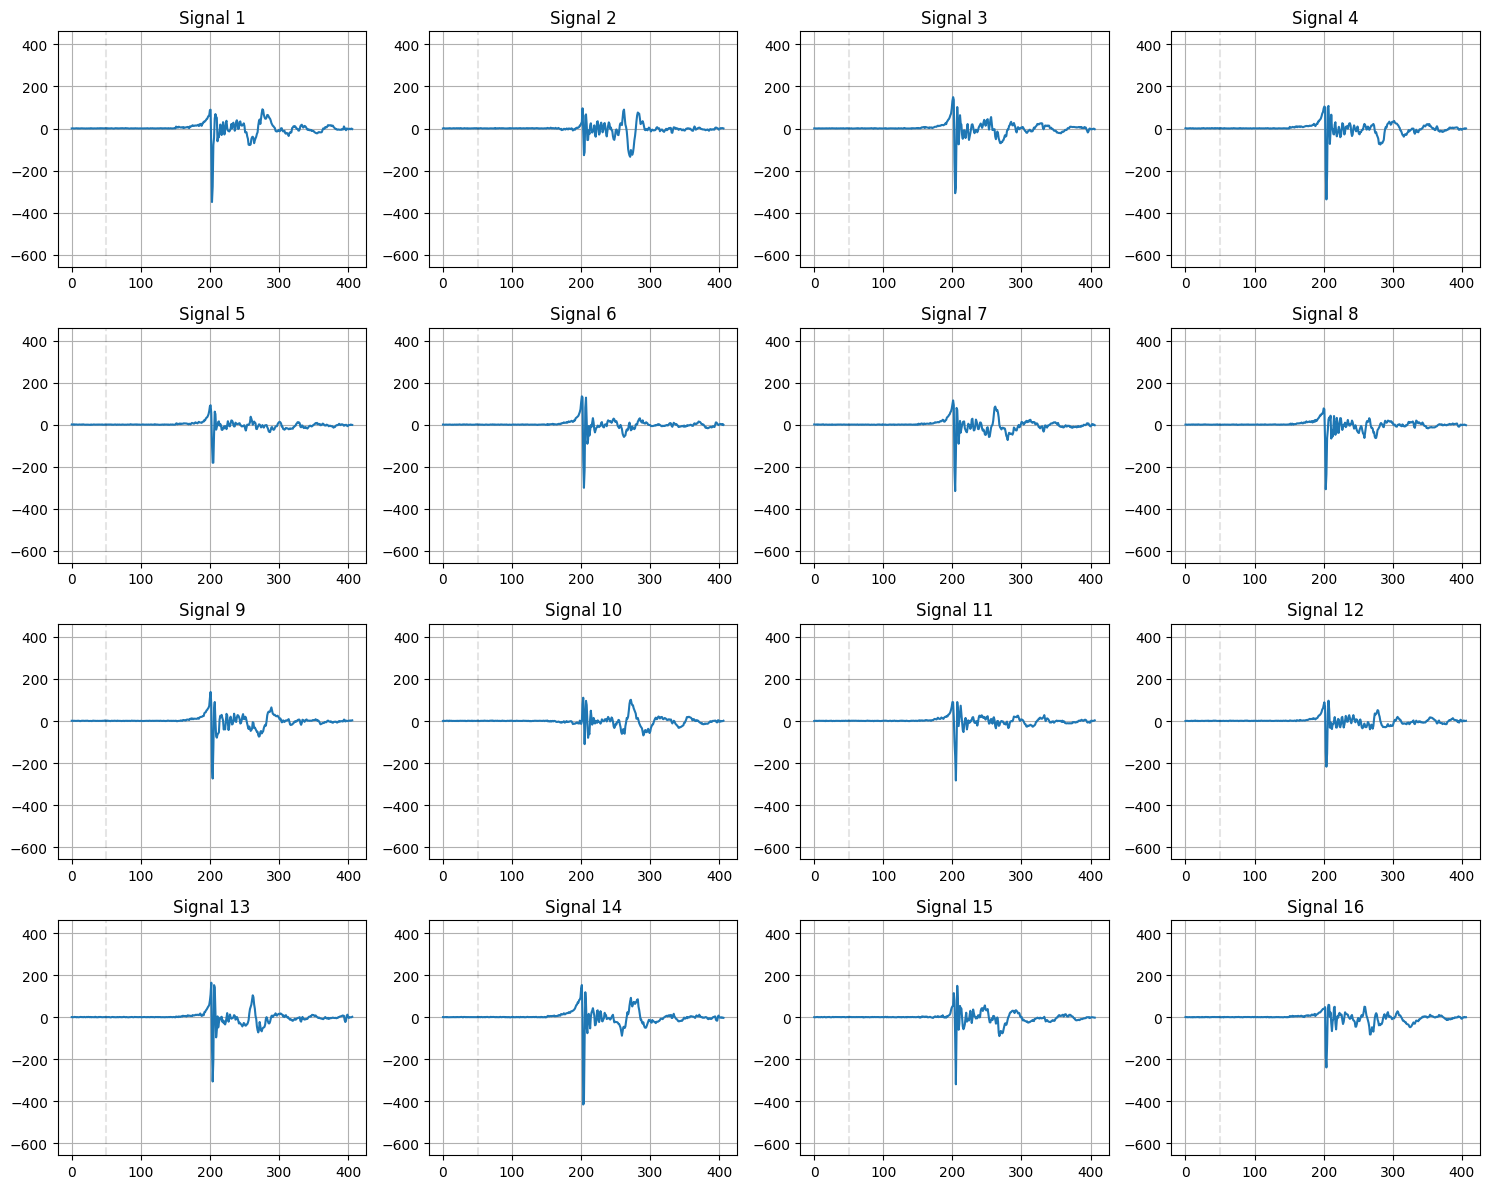

[28/32][0/188]	Loss_D: 0.7033	Loss_G: 1.4128	D(x): 0.8696	D(G(z)): 0.3092 / 0.3193
[28/32][50/188]	Loss_D: 0.7862	Loss_G: 2.0699	D(x): 0.7954	D(G(z)): 0.2687 / 0.1966
[28/32][100/188]	Loss_D: 0.6725	Loss_G: 2.1903	D(x): 0.8539	D(G(z)): 0.2545 / 0.1871
[28/32][150/188]	Loss_D: 0.6740	Loss_G: 1.6425	D(x): 0.8219	D(G(z)): 0.2327 / 0.2594
Epoch 28: SGD Discriminator lr 0.0000107 -> 0.0000103
Epoch 28: SGD Generator lr 0.0000107 -> 0.0000103


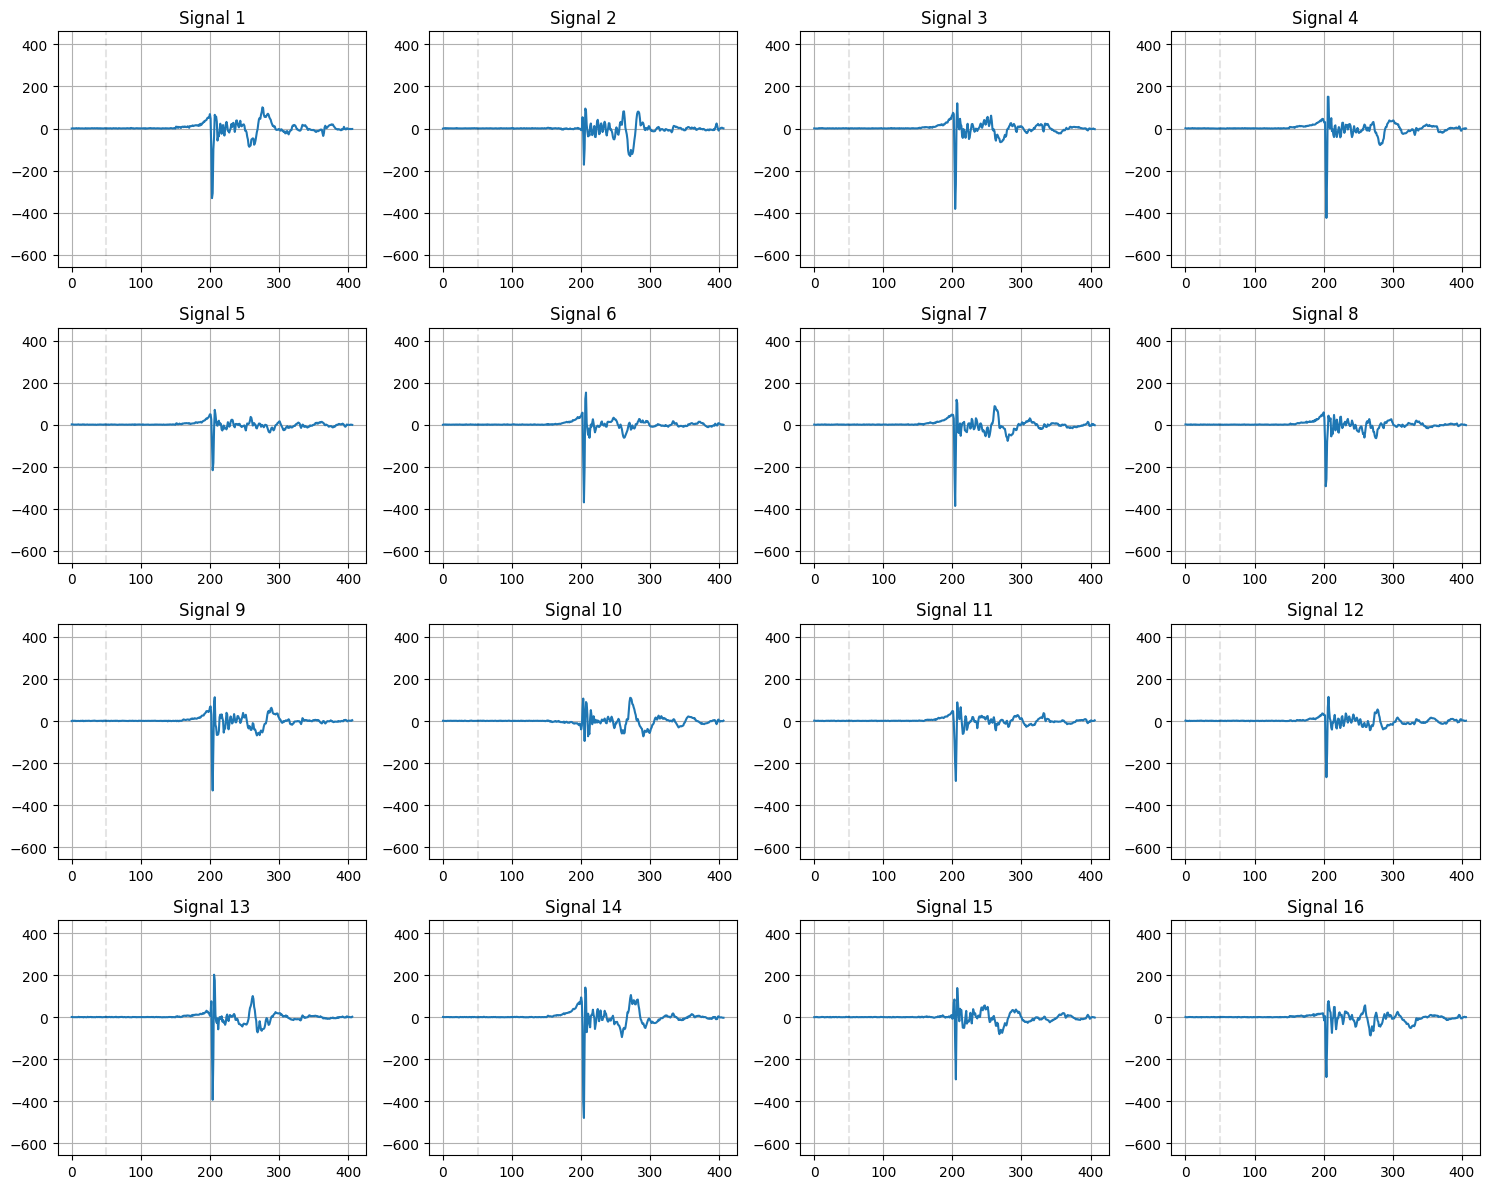

[29/32][0/188]	Loss_D: 0.7310	Loss_G: 2.2839	D(x): 0.8326	D(G(z)): 0.2703 / 0.1775
[29/32][50/188]	Loss_D: 0.6821	Loss_G: 1.9168	D(x): 0.8597	D(G(z)): 0.2193 / 0.2183
[29/32][100/188]	Loss_D: 0.6975	Loss_G: 1.9717	D(x): 0.8506	D(G(z)): 0.2491 / 0.2068
[29/32][150/188]	Loss_D: 0.6527	Loss_G: 2.0196	D(x): 0.8547	D(G(z)): 0.2209 / 0.2085
Epoch 29: SGD Discriminator lr 0.0000103 -> 0.0000100
Epoch 29: SGD Generator lr 0.0000103 -> 0.0000100


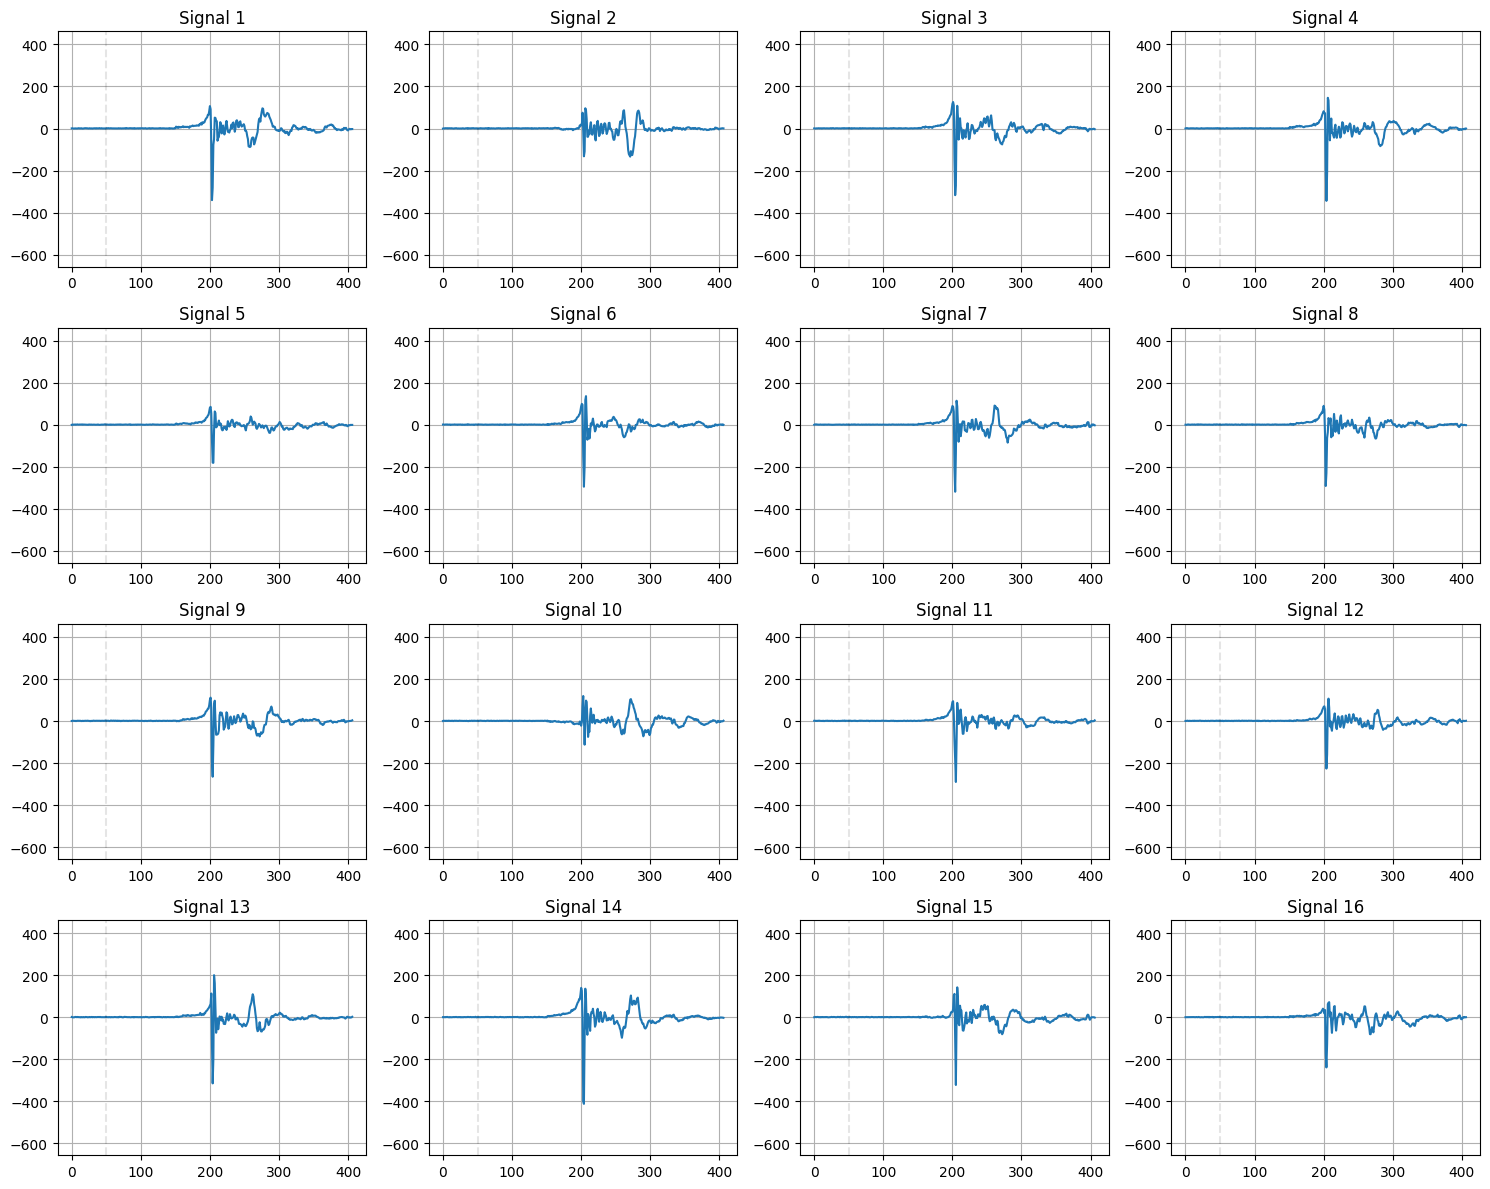

[30/32][0/188]	Loss_D: 0.7284	Loss_G: 1.7428	D(x): 0.8287	D(G(z)): 0.1973 / 0.2573
[30/32][50/188]	Loss_D: 0.5498	Loss_G: 1.9505	D(x): 0.9026	D(G(z)): 0.2047 / 0.2279
[30/32][100/188]	Loss_D: 0.6815	Loss_G: 1.8275	D(x): 0.8632	D(G(z)): 0.2774 / 0.2607
[30/32][150/188]	Loss_D: 0.7109	Loss_G: 1.4772	D(x): 0.8550	D(G(z)): 0.2348 / 0.2944
Epoch 30: SGD Discriminator lr 0.0000100 -> 0.0000100
Epoch 30: SGD Generator lr 0.0000100 -> 0.0000100


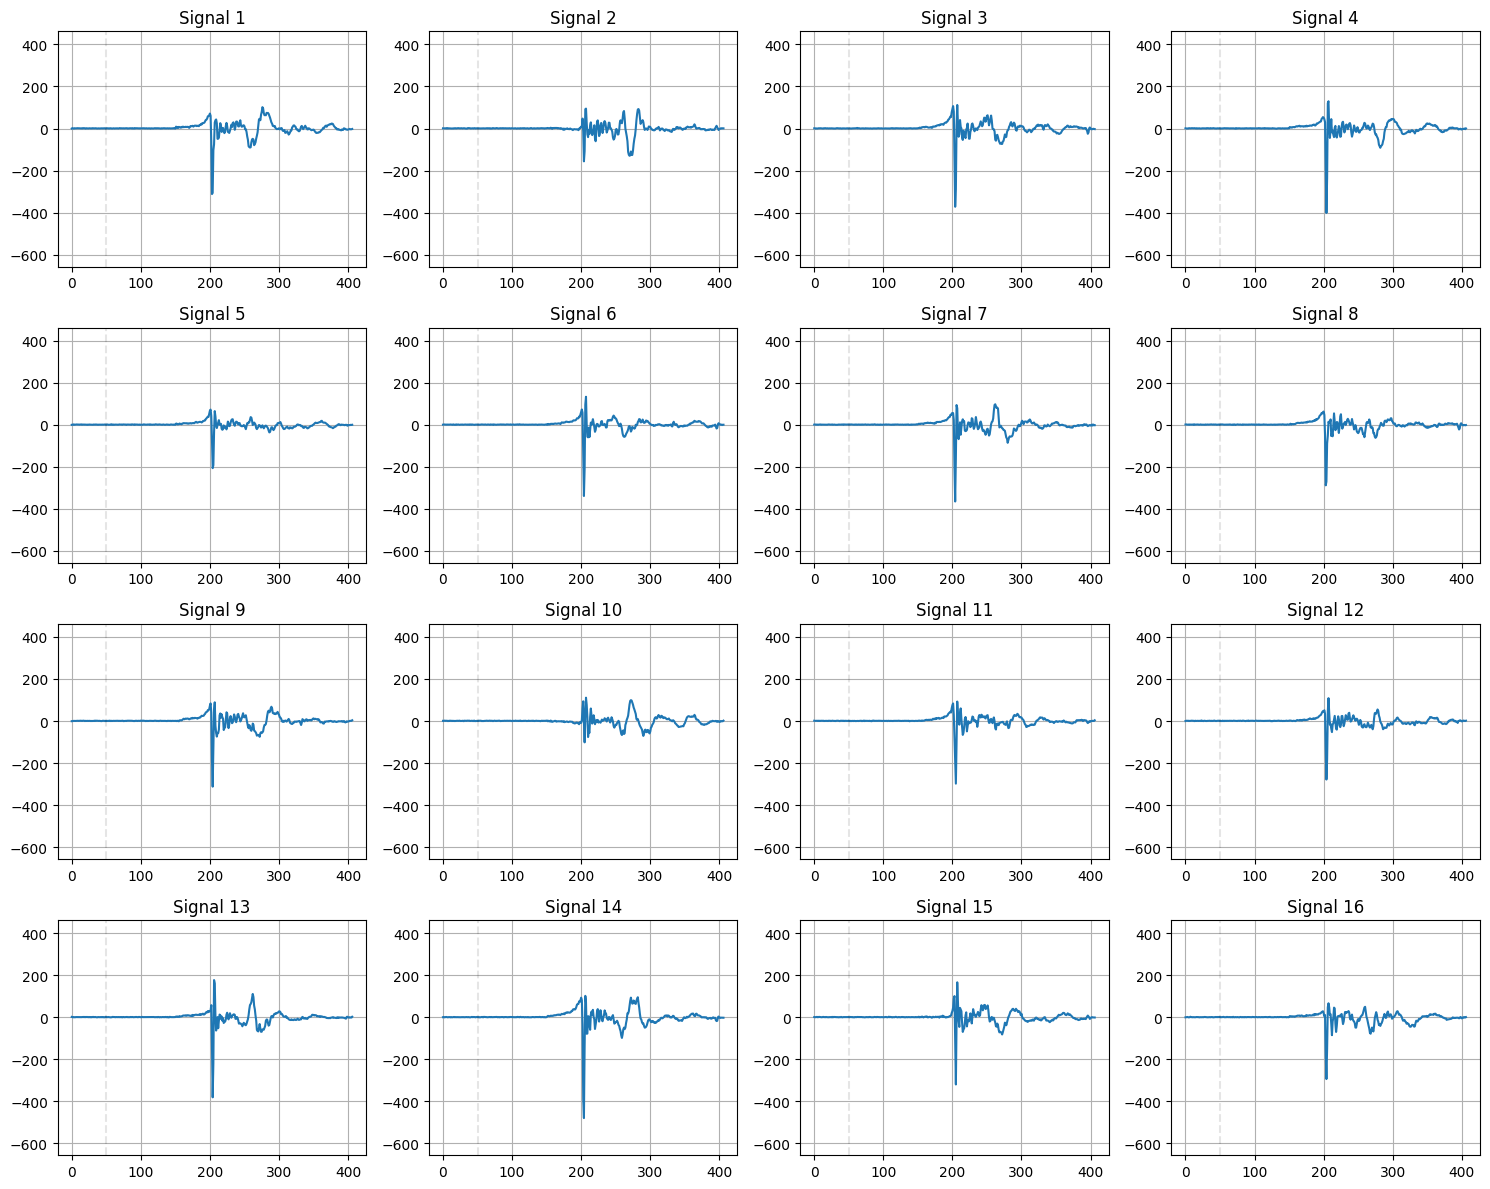

[31/32][0/188]	Loss_D: 0.5550	Loss_G: 2.0594	D(x): 0.8464	D(G(z)): 0.1445 / 0.2021
[31/32][50/188]	Loss_D: 0.6553	Loss_G: 2.0665	D(x): 0.8978	D(G(z)): 0.3357 / 0.1837
[31/32][100/188]	Loss_D: 0.6729	Loss_G: 2.0612	D(x): 0.8525	D(G(z)): 0.2222 / 0.2138
[31/32][150/188]	Loss_D: 0.7695	Loss_G: 1.8757	D(x): 0.8217	D(G(z)): 0.2229 / 0.2636
Epoch 31: SGD Discriminator lr 0.0000100 -> 0.0000100
Epoch 31: SGD Generator lr 0.0000100 -> 0.0000100


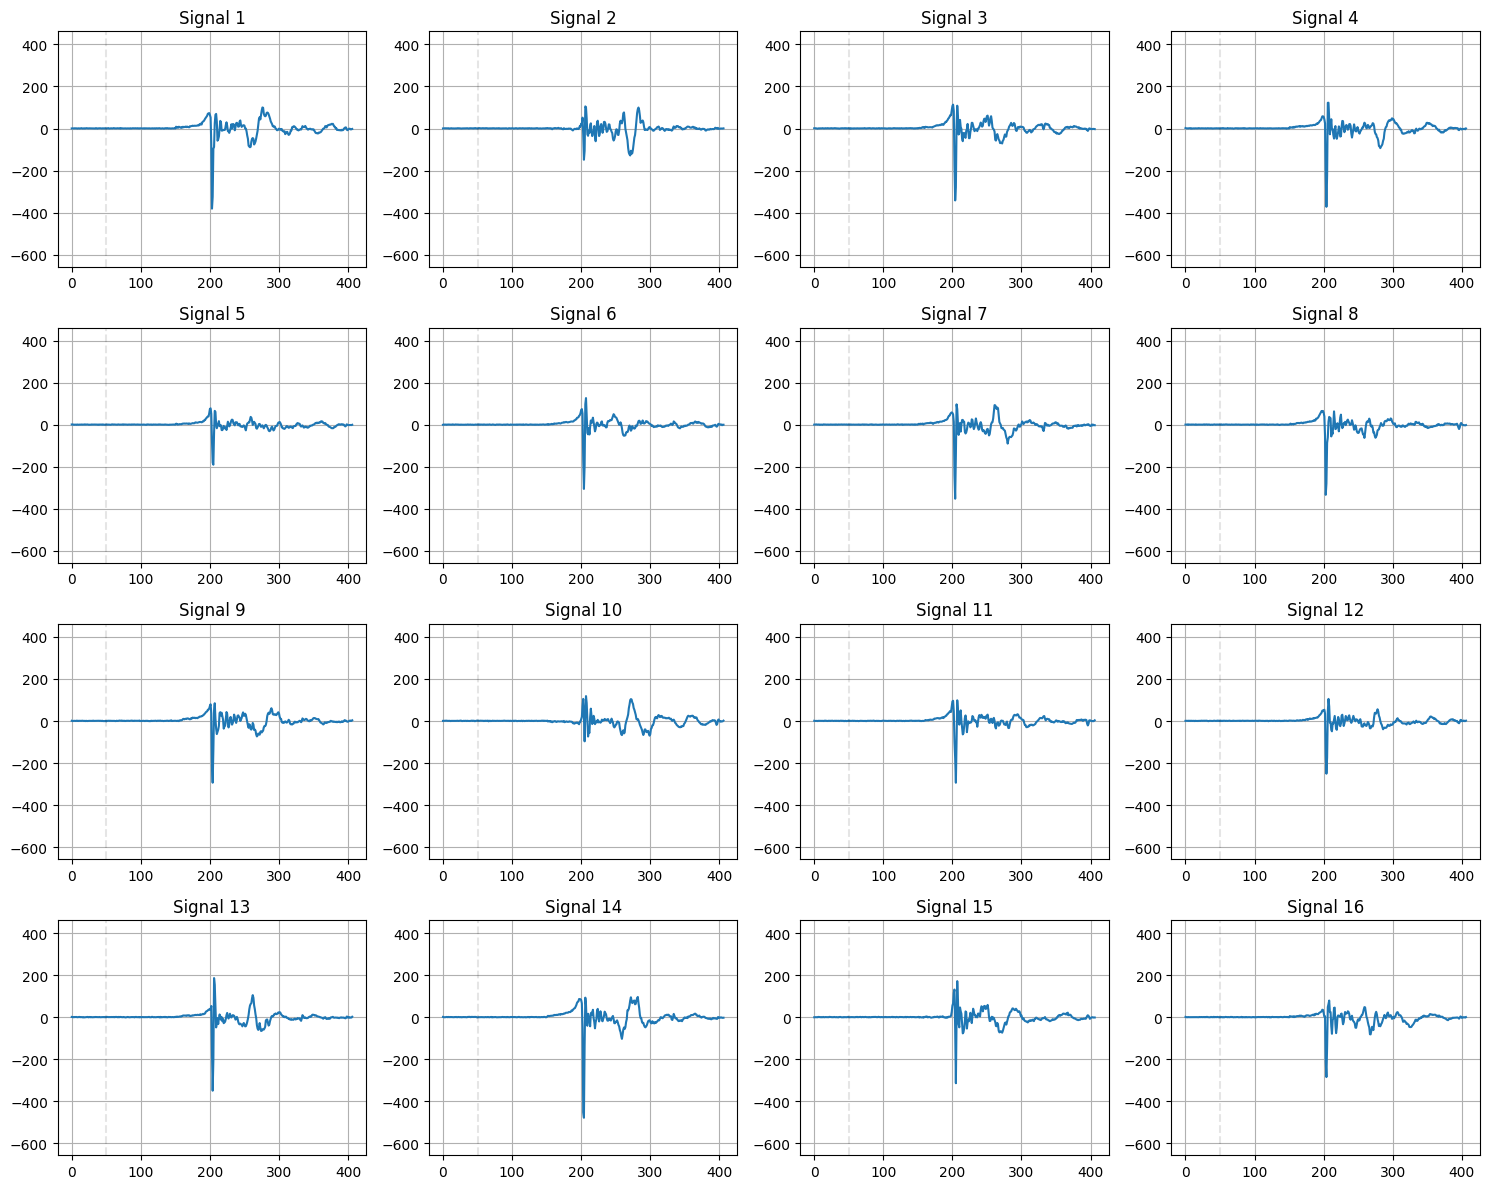

In [258]:
# Training Loop

# Lists to keep track of progress
signal_list = []
G_losses = []
D_losses = []
D_gradients = []
G_gradients = []
iters = 0

# label flip probability
flip_p = 0.0

if (gans_type == 'dcgans' or gans_type == 'gans'):
    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(num_epochs):
        # For each batch in the dataloader
        for i, data in enumerate(dataloader, 0):

            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            real_gpu = data[0].to(device)
            real_parameters_gpu = data[1].to(device)
            b_size = real_gpu.size(0)

            # determine which index of batch to flip on
            flip_mask = torch.rand(b_size) < flip_p

            # label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            # soft labelling
            label = torch.FloatTensor(b_size).uniform_(1.0, 1.0)
            # flip selected labels
            label = torch.where(flip_mask, 1.0 - label, label).to(device)

            # Forward pass real batch through D
            output = netD(real_gpu).view(-1) # add parameters here!!!
            # output = netD(real_gpu, real_parameters_gpu).view(-1)
            # print(output)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, nz, 1, device=device) # do we increase nz by 3 for parameters?
            # Generate fake signal batch with G
            fake = netG(noise)
            # label.fill_(fake_label)
            label = torch.FloatTensor(b_size).uniform_(0.0, 0.25)
            label = torch.where(flip_mask, 1.0 - label, label).to(device)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()
            # Calculate gradients of discriminator parameters
            D_gradients.append([param.grad.norm().item() for param in netD.parameters()])

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            # label.fill_(real_label)  # fake labels are real for generator cost
            label = torch.FloatTensor(b_size).uniform_(1.0, 1.0)
            label = torch.where(flip_mask, 1.0 - label, label).to(device)
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()
            # Calculate gradients of generator parameters
            G_gradients.append([param.grad.norm().item() for param in netG.parameters()])

            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, num_epochs, i, len(dataloader),
                        errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            iters += 1 
        
        # learning-rate decay
        before_lr = optimizerD.param_groups[0]["lr"]
        schedulerD.step()
        after_lr = optimizerD.param_groups[0]["lr"]
        print("Epoch %d: SGD Discriminator lr %.7f -> %.7f" % (epoch, before_lr, after_lr))

        before_lr = optimizerG.param_groups[0]["lr"]
        schedulerG.step()
        after_lr = optimizerG.param_groups[0]["lr"]
        print("Epoch %d: SGD Generator lr %.7f -> %.7f" % (epoch, before_lr, after_lr))
        
        with torch.no_grad():
            fake_signals = netG(fixed_noise).detach().cpu()
            fig, axes = plt.subplots(4, 4, figsize=(15, 12))

            axes = axes.flatten()

            # plot each signal on a separate subplot
            for i, ax in enumerate(axes):
                x = np.arange(407)
                y = fake_signals[i, :, :].flatten()
                y = y * dataset.scaling_factor
                y = y * dataset.std + dataset.mean
                background_noise_generated = np.random.normal(dataset.background_noise_mean, dataset.background_noise_std, int(407-256))
                y = np.concatenate((background_noise_generated, y))
                
                ax.plot(x, y)

                ax.axvline(x=50, color='black', linestyle='--', alpha=0.1)
                ax.set_title(f'Signal {i+1}')
                ax.grid(True)
                ax.set_ylim(common_ylim_signal)

            for i in range(512, 8*4):
                fig.delaxes(axes[i])

            plt.tight_layout()
            # plt.savefig('../data/gw-dcgans-images/gw-dcgans_epoch_non_augment_%d.png' % (epoch + 1))
            plt.show()
        
        # print(time.time())
        signal_list.append(fake_signals)

In [259]:
if (gans_type == 'cdcgans' or gans_type == 'fccdcgans'):
    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(num_epochs):
        # For each batch in the dataloader
        for i, data in enumerate(dataloader, 0):
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            real_signals_gpu = data[0].to(device)
            real_parameters_gpu = data[1].to(device)
            b_size = real_signals_gpu.size(0)

            # determine which index of batch to flip on
            flip_mask = torch.rand(b_size) < flip_p

            # label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            # soft labelling
            label = torch.FloatTensor(b_size).uniform_(1.0, 1.0)
            # flip selected labels
            label = torch.where(flip_mask, 1.0 - label, label).to(device)

            # Forward pass real batch through D
            ### conditional implementation ###
            output = netD(real_signals_gpu, real_parameters_gpu).view(-1)
            ######
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, nz, 1, device=device)

            ### conditional implementation
            # generate random parameters
            # random_indices = torch.randint(0, num_classes, (b_size,)).long()
            # random_one_hot_encoding = torch.nn.functional.one_hot(random_indices, num_classes=num_classes).float()
            # random_one_hot_encoding = random_one_hot_encoding.unsqueeze(-1)
            # Generate fake signal batch with G
            fake = netG(noise, real_parameters_gpu)
            ######

            # label.fill_(fake_label)
            label = torch.FloatTensor(b_size).uniform_(0.0, 0.25)
            label = torch.where(flip_mask, 1.0 - label, label).to(device)
            # Classify all fake batch with D
            ### conditional implementation ###
            output = netD(fake.detach(), real_parameters_gpu).view(-1)
            ######
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()
            # Calculate gradients of discriminator parameters
            # D_gradients.append([param.grad.norm().item() for param in netD.parameters()])

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            # label.fill_(real_label)  # fake labels are real for generator cost
            label = torch.FloatTensor(b_size).uniform_(1.0, 1.0)
            label = torch.where(flip_mask, 1.0 - label, label).to(device)
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake, real_parameters_gpu).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()
            # Calculate gradients of generator parameters
            # G_gradients.append([param.grad.norm().item() for param in netG.parameters()])

            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, num_epochs, i, len(dataloader),
                        errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            iters += 1 
        
        # learning-rate decay
        before_lr = optimizerD.param_groups[0]["lr"]
        schedulerD.step()
        after_lr = optimizerD.param_groups[0]["lr"]
        print("Epoch %d: SGD Discriminator lr %.7f -> %.7f" % (epoch, before_lr, after_lr))

        before_lr = optimizerG.param_groups[0]["lr"]
        schedulerG.step()
        after_lr = optimizerG.param_groups[0]["lr"]
        print("Epoch %d: SGD Generator lr %.7f -> %.7f" % (epoch, before_lr, after_lr))
        
        with torch.no_grad():
            fake_signals = netG(fixed_noise, fixed_random_one_hot_encoding).detach().cpu()
            fig, axes = plt.subplots(4, 4, figsize=(15, 12))

            axes = axes.flatten()

            # plot each signal on a separate subplot
            for i, ax in enumerate(axes):
                x = np.arange(fake_signals.size(dim=2))
                y = fake_signals[i, :, :].flatten()
                y = y * dataset.scaling_factor
                y = y * dataset.std + dataset.mean
                ax.plot(x, y)

                ax.axvline(x=50, color='black', linestyle='--', alpha=0.1)
                ax.set_title(f'Signal {i+1}')
                ax.grid(True)
                ax.set_ylim(common_ylim_signal)

            for i in range(512, 8*4):
                fig.delaxes(axes[i])

            plt.tight_layout()
            plt.savefig('../data/gw-dcgans-images/gw-dcgans_epoch_cgans_%d.png' % (epoch + 1))
            plt.show()
        
        # print(time.time())
        signal_list.append(fake_signals)

### Gradients

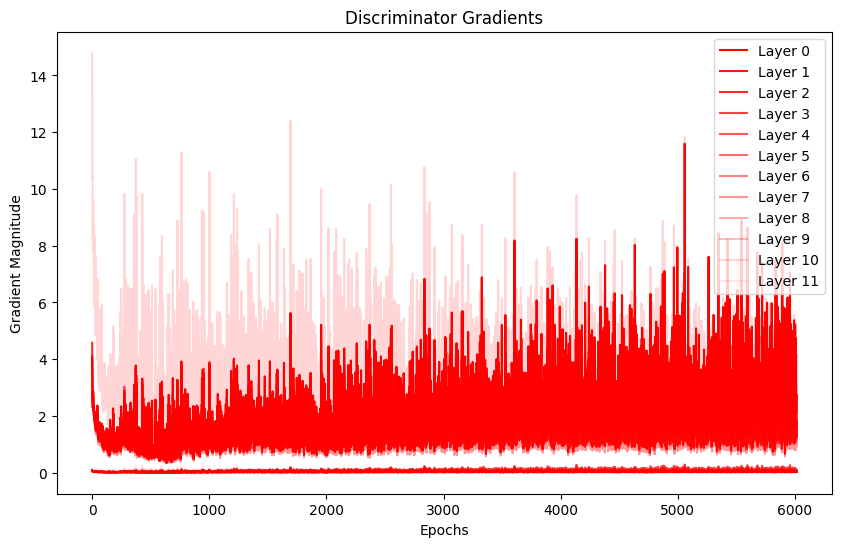

In [260]:
# Get the total number of layers in the discriminator
D_gradients = np.array(D_gradients)
num_layers = D_gradients.shape[1]

# Plot the gradients over training epochs
plt.figure(figsize=(10, 6))
for i in range(num_layers):
    # Calculate alpha value based on layer index
    alpha = 1 - (i / num_layers)  # Higher layers are more transparent
    plt.plot(D_gradients[:, i], label=f'Layer {i}', alpha=alpha, color=(1, 0, 0, alpha))

plt.xlabel('Epochs')
plt.ylabel('Gradient Magnitude')
plt.title('Discriminator Gradients')
plt.legend()
plt.show()

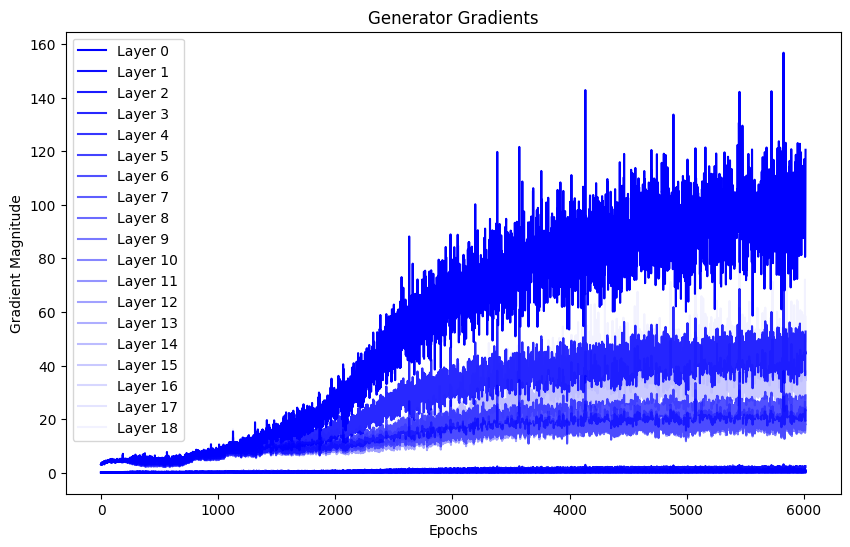

In [261]:
# Get the total number of layers in the discriminator
G_gradients = np.array(G_gradients)
num_layers = G_gradients.shape[1]

# Plot the gradients over training epochs
plt.figure(figsize=(10, 6))
for i in range(num_layers):
    # Calculate alpha value based on layer index
    alpha = 1 - (i / num_layers)  # Higher layers are more transparent
    plt.plot(G_gradients[:, i], label=f'Layer {i}', alpha=alpha, color=(0, 0, 1, alpha))

plt.xlabel('Epochs')
plt.ylabel('Gradient Magnitude')
plt.title('Generator Gradients')
plt.legend()
plt.show()

### Loss

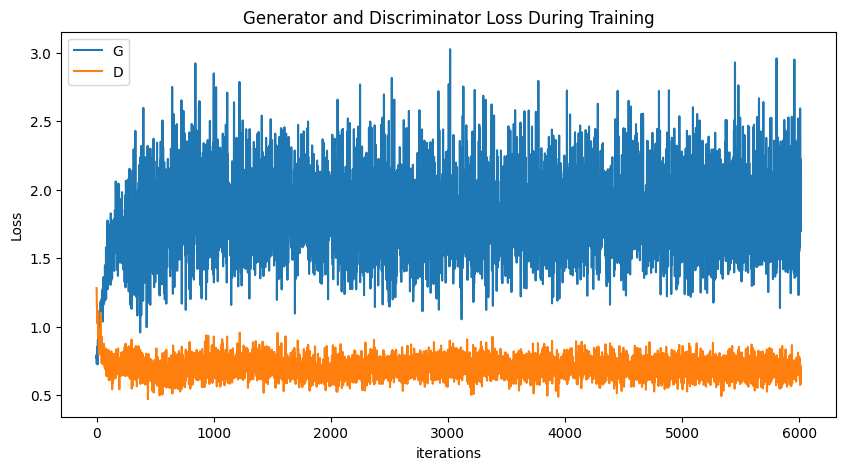

In [262]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("../plots/gw_dcgans_train_losses.png")
plt.show()

### Generated Signals

torch.Size([32, 1, 256])


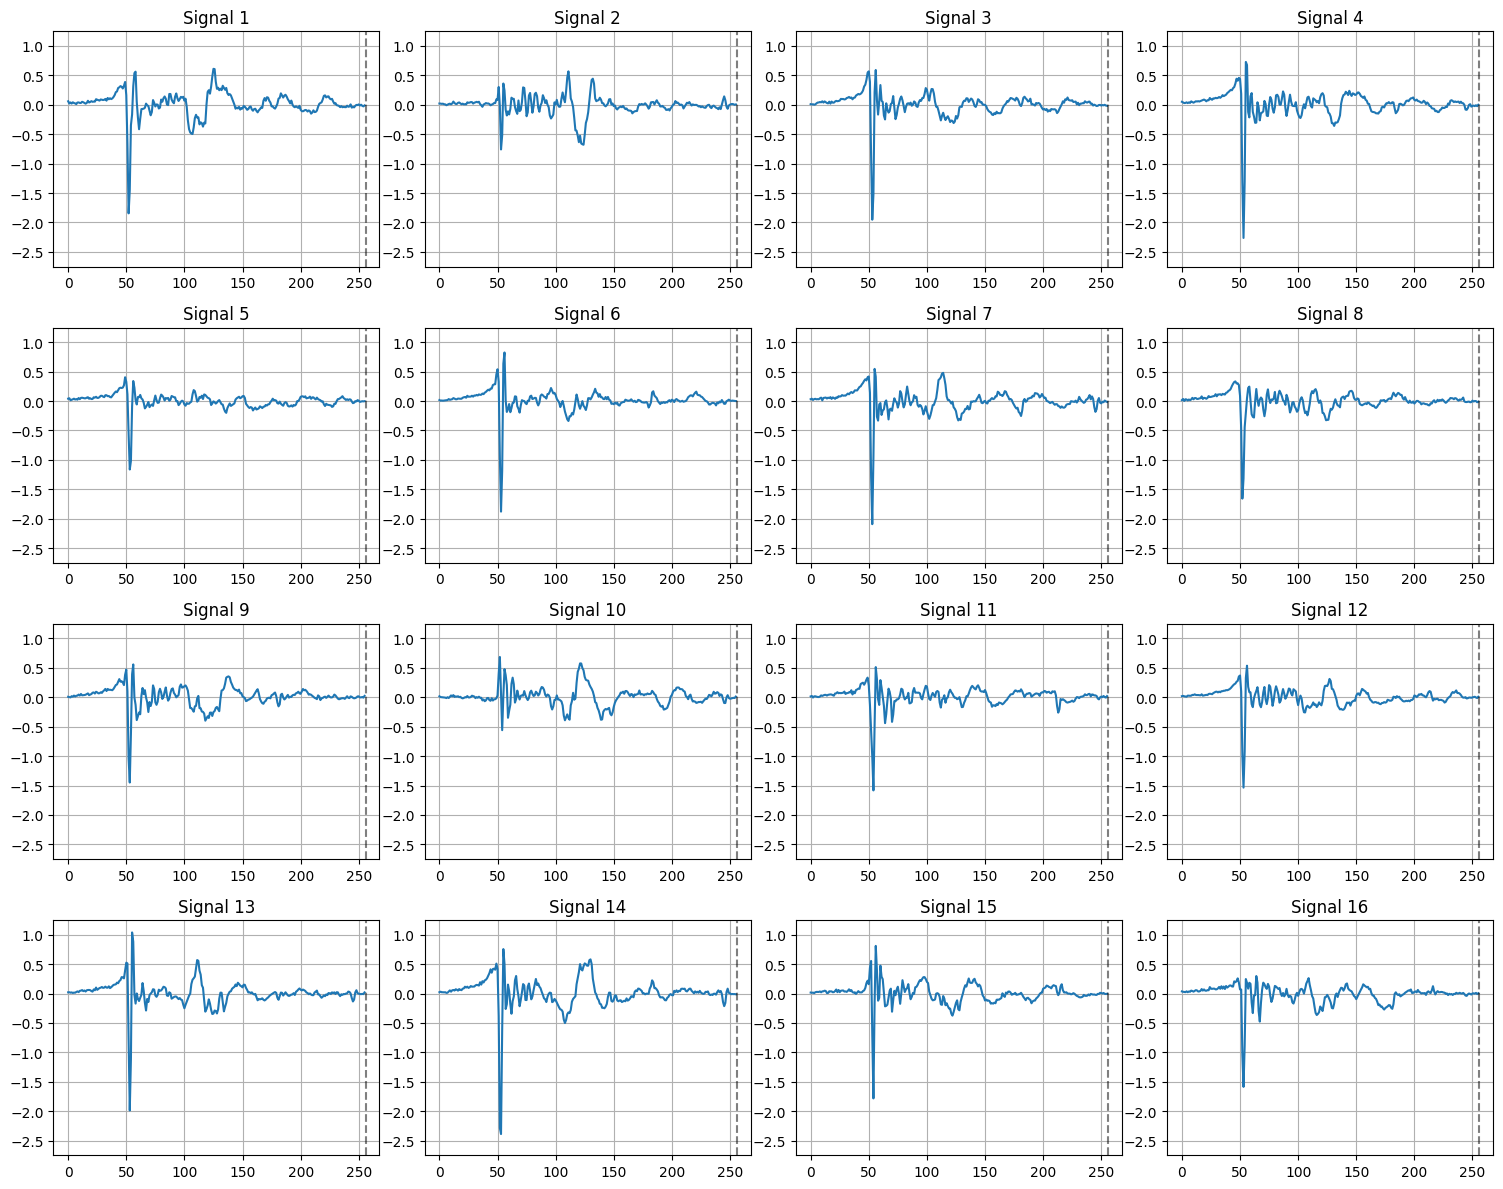

In [263]:
batch = signal_list[19]

# # plotting a single batch
# def plot_waveforms(batch):
#     fig, axs = plt.subplots(8, int(batch_size/8), figsize=(12, 12))
#     axs = axs.ravel()
    
#     for i in range(len(batch)):
#         signal = batch[i].squeeze()
#         axs[i].plot(signal)
#         axs[i].set_title(f'Signal {i+1}')
#         axs[i].axis('off')
    
#     plt.tight_layout()
#     plt.show()

# plot_waveforms(batch)

# Expecting: (32, 1, 512)
print(batch.shape)

# common_ylim = (batch[:,:,:].min(), batch[:,:,:].max())

fig, axes = plt.subplots(4, 4, figsize=(15, 12))

axes = axes.flatten()

# plot each signal on a separate subplot
for i, ax in enumerate(axes):
    x = np.arange(batch.size(dim=2))
    y = batch[i, :, :].flatten()
    ax.plot(x, y)

    ax.axvline(x=256, color='black', linestyle='--', alpha=0.5)
    ax.set_title(f'Signal {i+1}')
    ax.grid(True)
    ax.set_ylim(common_ylim)

for i in range(512, 8*4):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig('../data/gw-dcgans-plots/generated_data.png')
plt.show()

In [264]:
# for signal processing
%store signal_list

Stored 'signal_list' (list)


### Evaluation Metrics for GANS